# **Figures and Queries**
For paper on **Vaccine Effectiveness** - CoronaVac

In [14]:
# -- Config
import sys
sys.path.append("..")

# -- Essential
import os
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from collections import defaultdict
import lib.utils as utils
import lib.etc_utils as etc_utils

# -- Filter warnings
import uuid
import warnings
warnings.filterwarnings("ignore")

# -- Plotting 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker
import seaborn as sns
from IPython.display import Image
%matplotlib inline

## **Set paths**

In [2]:
base_path = os.path.join(os.environ["USERPROFILE"], "Documents")
parquet_folder = os.path.join(base_path, "data", "PARQUET_TRANSFORMED")
project_folder = os.path.join(base_path, "projects", "vaccine-eff-fortaleza")
fig_folder = os.path.join(project_folder, "output", "figs", "FIG_PAPER_AUG2022")

schema_folder = os.path.join(project_folder, "output", "data")
pareamento_folder = os.path.join(project_folder, "output", "PAREAMENTO")

## **Load data**

In [3]:
pop2021 = pd.read_excel(os.path.join(base_path, "data", "pop_2021.xlsx"))

In [4]:
#integra_df = pd.read_parquet(os.path.join(parquet_folder, "INTEGRASUS_2022_08_09_FMT.parquet"))
#integra_df = integra_df[integra_df["municipio_paciente"]=="FORTALEZA"]
#positivos = integra_df[integra_df["resultado_final_exame"]=="Positivo"]

fschema = pd.read_parquet(os.path.join(schema_folder, "SCHEMA_21JAN2021_31AUG2021.parquet"))
vacinados_df = pd.read_parquet(os.path.join(parquet_folder, "VACINADOS.parquet"))

In [19]:
str(uuid.uuid4())[:8]

'62e22f88'

In [28]:
# DEIDENTIFICATION
cols_deid = ["IDH2010", "POSITIVOS COLETA DATA", "POSITIVOS SOLICITACAO DATA", "INTEGRA PRI SINTOMAS DATA", "INTEGRA HOSPITALIZACAO DATA", 
             "VACINA APLICADA", "DATA D1", "DATA D2", "DATA D3", "DATA D4", "GRUPO PRIORITARIO", "DATA OBITO", "DATA FALECIMENTO(CARTORIOS)",
             "UTI", "DATA UTI", "STATUS VACINACAO DURANTE COORTE", "IDADE",
             "DATA HOSPITALIZACAO"]

rename = {"IDH2010": "hdi2010", "POSITIVOS COLETA DATA": "positive_sample_date", "POSITIVOS SOLICITACAO DATA": "positive_request_date",
          "INTEGRA PRI SINTOMAS DATA": "first_symptoms_date_integrasus", "INTEGRA HOSPITALIZACAO DATA": "hospital_date_integrasus",
          "VACINA APLICADA": "vaccine", "DATA D1": "dose_one_date", "DATA D2": "dose_two_date", "DATA D3": "dose_three_date", 
          "DATA D4": "dose_four_date", "GRUPO PRIORITARIO": "priority_group", "DATA OBITO": "covid_death_date", 
          "DATA FALECIMENTO(CARTORIOS)":"death_date_not_covid", "UTI": "ICU", "DATA UTI": "ICU_admission", "STATUS VACINACAO DURANTE COORTE": "vaccination_status_cohort",
          "STATUS VACINACAO DURANTE COORTE": "vaccination_status_cohort", "IDADE": "age", "DATA HOSPITALIZACAO": "hospital_admission_date"}

new_schema = fschema[cols_deid].rename(rename, axis=1)
new_schema["person_random_id"] = [ str(uuid.uuid4())[:16] for n in range(new_schema.shape[0]) ]

In [29]:
new_schema1 = new_schema[new_schema["age"]>=60].copy()

In [32]:
new_schema1[new_schema1.columns[::-1]].to_parquet(os.path.join("..", "output", "PAREAMENTO", "persons_fortaleza_cohort.parquet"))

## **FIGURE 1: CASES-DEATHS-LOCKDOWN-VACCINE-COVERAGE**

### **Process data:** Confirmed cases and deaths Covid-19

In [5]:
# --> CASOS CONFIRMADOS
casos_confirmados = positivos.drop_duplicates(subset=["codigo_paciente"])["data_inicio_sintomas"].value_counts().sort_index().reset_index()
casos_confirmados = casos_confirmados.rename({"index": "Data", "data_inicio_sintomas": "# casos confirmados"}, axis=1)
# --> OBITOS CONFIRMADOS
obitos = positivos[pd.notna(positivos["data_obito"])]
obitos_confirmados = obitos.drop_duplicates(subset=["codigo_paciente"])["data_obito"].value_counts().sort_index().reset_index()
obitos_confirmados = obitos_confirmados.rename({"index": "Data", "data_obito": "# obitos confirmados"}, axis=1)
# --> JOIN
init_data = dt.date(2020,1,1)
final_data = dt.date(2022,8,1)
temp = [init_data]
while temp[-1]<=final_data:
    temp.append(temp[-1]+timedelta(days=1))
complete_data = pd.DataFrame({"Data": temp})

curve = casos_confirmados.merge(obitos_confirmados, on="Data", how="outer").fillna(0.0)
curve["Data"] = curve["Data"].apply(lambda x: x.date())
curve = complete_data.merge(curve, on="Data", how="left").fillna(0.0)

datas = curve["Data"].tolist()
casos = curve["# casos confirmados"].tolist()
obitos = curve["# obitos confirmados"].tolist()

In [6]:
# --> Média movel
def media_movel(lst):
    mean_lst = []
    for k in range(len(lst)):
        if k<3:
            mean_lst.append(np.mean(lst[:k+4]))
        else:
            mean_lst.append(np.mean(lst[k-3:k+4]))
    return mean_lst

In [7]:
casos_media = media_movel(casos)
obitos_media = media_movel(obitos)
curve["# casos - media movel"] = casos_media
curve["# obitos - media movel"] = obitos_media
curve = curve.fillna(0.0)

In [8]:
curve[:5]

,Data,# casos confirmados,# obitos confirmados,# casos - media movel,# obitos - media movel
0,2020-01-01,38.0,0.0,14.000000,0.0
1,2020-01-02,8.0,0.0,11.800000,0.0
2,2020-01-03,5.0,0.0,10.000000,0.0
3,2020-01-04,5.0,0.0,8.571429,0.0
4,2020-01-05,3.0,0.0,3.285714,0.0


### **Process data:** Vaccine coverage on eligible individuals

In [9]:
# -- Vaccine coverage
df_eligible = fschema.copy()
vaccine = "CORONAVAC"
# eligbility
# Zeroth rule: Filter by age range. (OK)
df_eligible = df_eligible[(df_eligible["IDADE"]>=60) & (df_eligible["IDADE"]<=200)]

# First rule: Filter out uncommon vaccination schemes. (OK)
ruleout = ["(D2)", "(D1)(D4)", "(D1)(D2)(D4)"]
df_eligible = df_eligible[~df_eligible["STATUS VACINACAO DURANTE COORTE"].isin(ruleout)]

# Second rule: Remove everyone with positive test before cohort. (OK)
df_eligible = df_eligible[df_eligible["TESTE POSITIVO ANTES COORTE"]==False]

# Third rule: Remove all inconsistencies between death date and vaccination. (OK)
df_eligible = df_eligible[(df_eligible["OBITO INCONSISTENCIA CARTORIOS"]==False) & (df_eligible["OBITO INCONSISTENCIA COVID"]==False)]

 # Fourth rule: Remove all deaths before cohort. (OK)
df_eligible = df_eligible[df_eligible["OBITO ANTES COORTE"]==False]

# Fifth rule(for hospitalization): Remove all hospitalization before cohort. (OK)
df_eligible = df_eligible[df_eligible["HOSPITALIZACAO ANTES COORTE"]==False]

# Sixth rule: Remove health workers and health profissionals (OK)
df_eligible = df_eligible[~df_eligible["GRUPO PRIORITARIO"].isin(["PROFISSIONAL DE SAUDE", "TRABALHADOR DA SAUDE"])]

# Seventh rule: Remove records without info on matching variables. (OK)
df_eligible = df_eligible[(pd.notna(df_eligible["IDADE"])) & (pd.notna(df_eligible["SEXO"])) & (pd.notna(df_eligible[f"IDH2010"]))]
print(f"Eligible: {df_eligible.shape[0]}")
df = df_eligible

Eligible: 324302


In [10]:
df_coronavac = df[df["VACINA APLICADA"]=="CORONAVAC"]
df_other = df[(df["VACINA APLICADA"]!="CORONAVAC") & (pd.notna(df["VACINA APLICADA"]))]
freq_d2_coronavac = df_coronavac["DATA D2"].value_counts().sort_index().reset_index().rename({"index": "Data", "DATA D2": "# DOSES CORONAVAC"}, axis=1)
freq_d2_other = df_other["DATA D2"].value_counts().sort_index().reset_index().rename({"index": "Data", "DATA D2": "# DOSES OUTRAS"}, axis=1)

# --> JOIN
init_data = dt.date(2021,1,21)
final_data = dt.date(2021,8,31)
temp = [init_data]
while temp[-1]<=final_data:
    temp.append(temp[-1]+timedelta(days=1))
complete_data_1 = pd.DataFrame({"Data": temp})

curve1 = freq_d2_coronavac.merge(freq_d2_other, on="Data", how="outer").fillna(0.0)
curve1["Data"] = curve1["Data"].apply(lambda x: x.date())
curve1 = complete_data_1.merge(curve1, on="Data", how="left").fillna(0.0)

curve1["# DOSES CORONAVAC ACUM."] = curve1["# DOSES CORONAVAC"].cumsum()
curve1["# DOSES OUTRAS ACUM."] = curve1["# DOSES OUTRAS"].cumsum()
curve1

,Data,# DOSES CORONAVAC,# DOSES OUTRAS,# DOSES CORONAVAC ACUM.,# DOSES OUTRAS ACUM.
0,2021-01-21,0.0,0.0,0.0,0.0
1,2021-01-22,0.0,0.0,0.0,0.0
2,2021-01-23,0.0,0.0,0.0,0.0
3,2021-01-24,0.0,0.0,0.0,0.0
4,2021-01-25,0.0,0.0,0.0,0.0
...,...,...,...,...,...
219,2021-08-28,12.0,118.0,166711.0,114390.0
220,2021-08-29,3.0,30.0,166714.0,114420.0
221,2021-08-30,24.0,234.0,166738.0,114654.0
222,2021-08-31,11.0,166.0,166749.0,114820.0


### Plotting v1

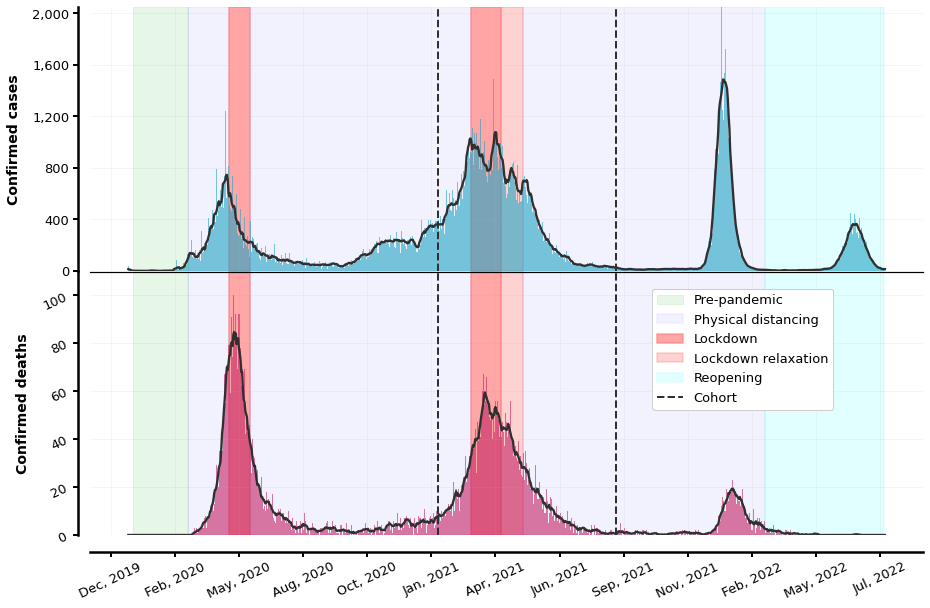

In [64]:
fig1_1, (ax1_1, ax2_1) = plt.subplots(2,1, figsize=(13,8.5), sharex=True)

subdata = curve[:].fillna(0.0)
dates_ = subdata["Data"].tolist()
ticks_ = np.arange(len(dates_))
ax2_1.set_xticks(ticks_, labels=dates_)
ax1_1.set_xticks(ticks_, labels=dates_)

ax1_1.tick_params(direction="out", width=2, top=False, right=False, bottom=False, labelsize=13, length=5)
ax2_1.tick_params(direction="out", width=2, top=False, right=False, rotation=25, labelsize=13, length=5)

for ax in [ax1_1, ax2_1]:
    for i in ["left", "bottom"]:
        ax.spines[i].set_linewidth(2.5)
    for i in ["top", "right"]:
        ax.spines[i].set_linewidth(0)
ax1_1.spines["bottom"].set_linewidth(1.2)
ax2_1.spines["top"].set_linewidth(1.2)

ax1_1.set_ylim([0, 2050])
ax2_1.set_ylim([0, 110])

ax2_1.xaxis.set_major_locator(mdates.MonthLocator())
ax2_1.xaxis.set_major_formatter(mdates.DateFormatter(fmt="%b, %Y"))

for ax in [ax1_1, ax2_1]:
    ax.grid(alpha=0.15)
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.yaxis.set_major_locator(plt.MaxNLocator(6))
    
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_position(('data', 18199))
    ax.spines['bottom'].set_position(('data',-7.0))   

ax1_1.set_ylabel("Confirmed cases", weight="bold", fontsize=14, labelpad=11)
ax2_1.set_ylabel("Confirmed deaths", weight="bold", fontsize=14, labelpad=11)
for axi in [ax2_1]:
    axi.xaxis.set_major_locator(plt.MaxNLocator(16))

# --------------------
# -- Fill with data --
# --------------------

intm1_init, intm1_final = dates_.index(dt.date(2020,1,7)), dates_.index(dt.date(2020,3,16)) # GREEN
#int0_init, int0_final = dates_.index(dt.date(2020,3,16)), dates_.index(dt.date(2020,3,19)) # GREEN
int1_init, int1_final = dates_.index(dt.date(2020,3,16)), dates_.index(dt.date(2020,5,5)) # LIGHT RED
int2_init, int2_final = dates_.index(dt.date(2020,5,5)), dates_.index(dt.date(2020,6,1)) # DARKER RED
int3_init, int3_final = dates_.index(dt.date(2020,6,1)), dates_.index(dt.date(2021,3,4)) # GREEN
int4_init, int4_final = dates_.index(dt.date(2021,3,4)), dates_.index(dt.date(2021,4,10)) # DARKER RED
int4_1_init, int4_1_final = dates_.index(dt.date(2021,4,10)), dates_.index(dt.date(2021,5,8)) # LIGHT RED
int5_init, int5_final = dates_.index(dt.date(2021,5,8)), dates_.index(dt.date(2022,3,5)) # GREEN
int6_init, int6_final = dates_.index(dt.date(2022,3,5)), dates_.index(dt.date(2022,8,1)) # BLUE
int7_init, int7_final = dates_.index(dt.date(2021,1,21)), dates_.index(dt.date(2021,8,31)) # COHORT

# 1st lockdown
ax1_1.axvspan(dates_[intm1_init], dates_[intm1_final], alpha=.2, color='#84D288', label="Pre-pandemic")
ax2_1.axvspan(dates_[intm1_init], dates_[intm1_final], alpha=.2, color='#84D288')
# --
#ax1_1.axvspan(dates_[int0_init], dates_[int0_final], alpha=.1, color='#9966CC')
#ax2_1.axvspan(dates_[int0_init], dates_[int0_final], alpha=.1, color='#9966CC')
# --
ax1_1.axvspan(dates_[int1_init], dates_[int1_final], alpha=.1, color='#8080ff', lw=1.5, label="Physical distancing")
ax2_1.axvspan(dates_[int1_init], dates_[int1_final], alpha=.1, color='#8080ff', lw=1.5)
# --
ax1_1.axvspan(dates_[int2_init], dates_[int2_final], alpha=.7, color="#ff8080", lw=1.5, label="Lockdown")
ax2_1.axvspan(dates_[int2_init], dates_[int2_final], alpha=.7, color="#ff8080", lw=1.5)
# --
ax1_1.axvspan(dates_[int3_init], dates_[int3_final], alpha=.1, color='#8080ff', lw=1.5)
ax2_1.axvspan(dates_[int3_init], dates_[int3_final], alpha=.1, color='#8080ff', lw=1.5)
# --
ax1_1.axvspan(dates_[int4_init], dates_[int4_final], alpha=.7, color="#ff8080", lw=1.5)
ax2_1.axvspan(dates_[int4_init], dates_[int4_final], alpha=.7, color="#ff8080", lw=1.5)
# --
ax1_1.axvspan(dates_[int4_1_init], dates_[int4_1_final], alpha=.35, color="#ff8080", lw=1.5, label="Lockdown relaxation")
ax2_1.axvspan(dates_[int4_1_init], dates_[int4_1_final], alpha=.35, color="#ff8080", lw=1.5)
# --
ax1_1.axvspan(dates_[int5_init], dates_[int5_final], alpha=.1, color='#8080ff', lw=1.5)
ax2_1.axvspan(dates_[int5_init], dates_[int5_final], alpha=.1, color='#8080ff', lw=1.5)
# --
ax1_1.axvspan(dates_[int6_init], dates_[int6_final], alpha=.225, color='#80ffff', lw=1.5, label="Reopening")
ax2_1.axvspan(dates_[int6_init], dates_[int6_final], alpha=.225, color='#80ffff', lw=1.5)
# -- Cohort period --
ax1_1.axvline(dates_[int7_init], 0, 2000, color="#303030", lw=2, ls="--", label="Cohort")
ax1_1.axvline(dates_[int7_final], 0, 2000, color="#303030", lw=2, ls="--")
ax2_1.axvline(dates_[int7_init], 0, 130, color="#303030", lw=2, ls="--")
ax2_1.axvline(dates_[int7_final], 0, 130, color="#303030", lw=2, ls="--")

ax1_1.bar(dates_, subdata["# casos confirmados"], facecolor="#22a4c4", edgecolor=None, alpha=0.6, width=1.0)
ax1_1.plot(dates_, subdata["# casos - media movel"], color="#303030", ls="-", lw=2.3)
ax2_1.bar(dates_, subdata["# obitos confirmados"], facecolor="#c42263", edgecolor=None, alpha=0.6, width=1.0)
ax2_1.plot(dates_, subdata["# obitos - media movel"], color="#303030", ls="-", lw=2.3)

ax1_1.legend(loc=4, bbox_to_anchor=(0.9, -0.55), prop={'size':13,}, framealpha=1.0, fancybox=True, markerscale=15)
ax1_1.set_zorder(2)  

plt.tight_layout()
ax1_1.patch.set_visible(False)
plt.subplots_adjust(hspace=0.00)

### Plotting v2

In [46]:
color_palette_0 =  {"cases": "#c7c7c7", "deaths": "#de425b", "lockdown": "#e4707a", 
                    "physical distancing": "#cce7ff", "reopening": '#87e7b2', "pre-pandemic": '#87e7b2'}
color_palette_1 = {"cases": "#c7c7c7", "deaths": "#de425b", "lockdown": "#e4707a", 
                   "physical distancing": "#cce7ff", "reopening": '#fe5a1c', "pre-pandemic": '#fe5a1c'}
color_palette_2 = {"cases": "#c7c7c7", "deaths": '#faac3d', "lockdown": "#e4707a", 
                   "physical distancing": "#cce7ff", "reopening": '#ffa600', "pre-pandemic": '#87e7b2'}
color_palette_3 = {"cases": "#b3b3b3", "deaths": '#df676e', "lockdown": "#e4707a", 
                   "physical distancing": "#ccdfdf", "reopening": '#f3ff82', "pre-pandemic": '#009b9c'}
color_palette_4 = {"cases": "#b3b3b3", "deaths": '#df676e', "lockdown": "#e4707a", 
                   "physical distancing": "#ccdfdf", "reopening": '#abeb88', "pre-pandemic": '#009b9c'}
color_palette_5 = {"cases": "#b3b3b3", "deaths": '#df676e', "lockdown": "#e4707a", 
                   "physical distancing": "#cce7ff", "reopening": '#abeb88', "pre-pandemic": '#009b9c'}
color_palette_6 = {"cases": "#b3b3b3", "deaths": '#df676e', "lockdown": "#e4707a", 
                   "physical distancing": "#cce7ff", "reopening": '#009b9c', "pre-pandemic": '#009b9c'}
color_palette_7 = {"cases": "#b3b3b3", "deaths": '#fa807a', "lockdown": "#e4707a", 
                   "physical distancing": "#cce7ff", "reopening": '#009b9c', "pre-pandemic": '#009b9c'}

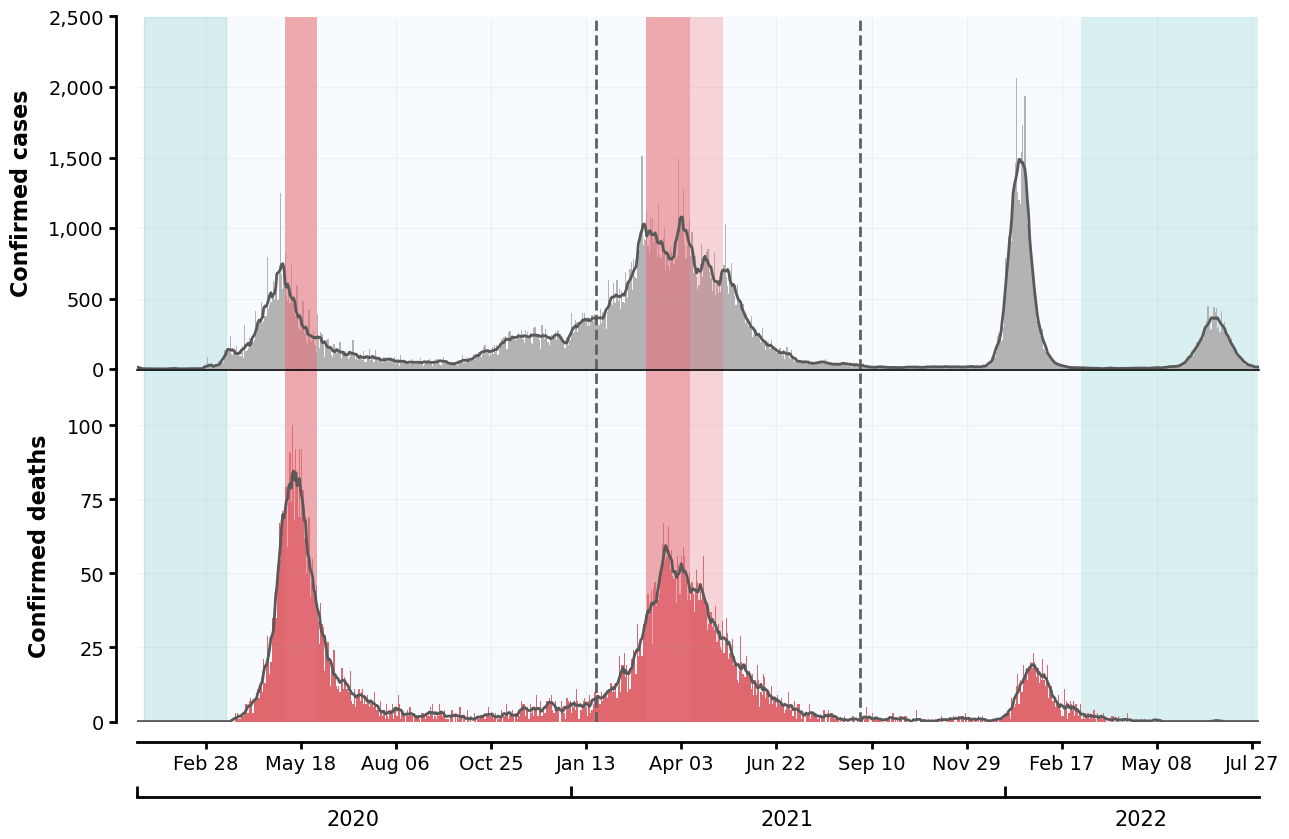

In [66]:
fig1_1, (ax1_1, ax2_1) = plt.subplots(2,1, figsize=(13,8.5), sharex=True)

subdata = curve[:].fillna(0.0)
dates_ = subdata["Data"].tolist()
ticks_ = np.arange(len(dates_))
ax2_1.set_xticks(ticks_, labels=dates_)
ax1_1.set_xticks(ticks_, labels=dates_)

# --> Grid
ax1_1.grid(alpha=0.15)
ax2_1.grid(alpha=0.15)

# --> Main tick params
ax1_1.tick_params(direction="out", width=2., top=False, right=False, bottom=False, labelsize=14, length=5)
ax2_1.tick_params(direction="out", width=2., top=False, right=False, rotation=0, labelsize=14, length=5)

# --> Spines
lw_spine = 2.0
for ax in [ax1_1, ax2_1]:
    for i in ["left", "bottom"]:
        ax.spines[i].set_linewidth(lw_spine)
    for i in ["top", "right"]:
        ax.spines[i].set_linewidth(0)
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_position(('outward', 15))
    ax.spines['bottom'].set_position(('outward',15)) 
ax1_1.spines["bottom"].set_linewidth(1.2)
ax2_1.spines["top"].set_linewidth(1.2)
ax1_1.spines['bottom'].set_position(('outward',1))  

# --> Axis limits
ax1_1.set_ylim([0, 2200])
ax2_1.set_xlim([dates_[0], dates_[-1]])
ax1_1.set_yticks(np.arange(0,2501, 500))
ax2_1.set_yticks(np.arange(0,130, 25))
ax2_1.set_ylim([0, 119])

# --> Tick locators and settings
ax2_1.xaxis.set_major_locator(mdates.MonthLocator())
ax2_1.xaxis.set_major_formatter(mdates.DateFormatter(fmt="%b %d"))
ax1_1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2_1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2_1.xaxis.set_major_locator(plt.MaxNLocator(14))

# --> Axis labels
ax1_1.set_ylabel("Confirmed cases", fontsize=16, weight='bold', labelpad=11)
ax2_1.set_ylabel("Confirmed deaths", fontsize=16, weight='bold', labelpad=11)

# --> Second X-axis for YEAR
ax22_1 = ax2_1.twiny()
ax22_1.spines["bottom"].set_position(("outward", 54))
for axis in ["left", "top", "right"]:
    ax22_1.spines[axis].set_linewidth(0)
ax22_1.tick_params('both', length=0, width=0, which='minor')
ax22_1.tick_params('both', direction='in', which='major', width=2, length=8, labelsize=13)
ax22_1.xaxis.set_ticks_position("bottom")
ax22_1.xaxis.set_label_position("bottom")
ax22_1.spines["bottom"].set_linewidth(lw_spine)
ax22_1.set_xticks(ticks_, labels=dates_)
ax22_1.xaxis.set_major_locator(mdates.YearLocator())
ax22_1.xaxis.set_major_formatter(mdates.DateFormatter(fmt=""))
#ax22_1.set_xticks([0.0, 0.6, 1.0])
#ax22_1.xaxis.set_major_formatter(ticker.NullFormatter())
ax22_1.xaxis.set_minor_locator(ticker.FixedLocator([ticks_[182], ticks_[547], ticks_[845]]))
ax22_1.xaxis.set_minor_formatter(ticker.FixedFormatter(['2020', '2021', '2022']))
ax22_1.tick_params(which='minor', labelsize=15, pad=9)


# --------------------
# -- Fill with data --
# --------------------

intm1_init, intm1_final = dates_.index(dt.date(2020,1,7)), dates_.index(dt.date(2020,3,16)) # GREEN
int1_init, int1_final = dates_.index(dt.date(2020,3,16)), dates_.index(dt.date(2020,5,5)) # LIGHT RED
int2_init, int2_final = dates_.index(dt.date(2020,5,5)), dates_.index(dt.date(2020,6,1)) # DARKER RED
int3_init, int3_final = dates_.index(dt.date(2020,6,1)), dates_.index(dt.date(2021,3,4)) # GREEN
int4_init, int4_final = dates_.index(dt.date(2021,3,4)), dates_.index(dt.date(2021,4,10)) # DARKER RED
int4_1_init, int4_1_final = dates_.index(dt.date(2021,4,10)), dates_.index(dt.date(2021,5,8)) # LIGHT RED
int5_init, int5_final = dates_.index(dt.date(2021,5,8)), dates_.index(dt.date(2022,3,5)) # GREEN
int6_init, int6_final = dates_.index(dt.date(2022,3,5)), dates_.index(dt.date(2022,8,1)) # BLUE
int7_init, int7_final = dates_.index(dt.date(2021,1,21)), dates_.index(dt.date(2021,8,31)) # COHORT

# --> choose palette
color_dict = color_palette_6

# 1st lockdown
ax1_1.axvspan(dates_[intm1_init], dates_[intm1_final], alpha=.16, color=color_dict["pre-pandemic"], label="Pre-pandemic")
ax2_1.axvspan(dates_[intm1_init], dates_[intm1_final], alpha=.16, color=color_dict["pre-pandemic"])
# --
ax1_1.axvspan(dates_[int1_init], dates_[int1_final], alpha=.15, color=color_dict["physical distancing"], lw=0., label="Physical distancing")
ax2_1.axvspan(dates_[int1_init], dates_[int1_final], alpha=.15, color=color_dict["physical distancing"], lw=0.)
# --
ax1_1.axvspan(dates_[int3_init], dates_[int3_final], alpha=.15, color=color_dict["physical distancing"], lw=0.)
ax2_1.axvspan(dates_[int3_init], dates_[int3_final], alpha=.15, color=color_dict["physical distancing"], lw=0.)
# --
ax1_1.axvspan(dates_[int5_init], dates_[int5_final], alpha=.15, color=color_dict["physical distancing"], lw=0.)
ax2_1.axvspan(dates_[int5_init], dates_[int5_final], alpha=.15, color=color_dict["physical distancing"], lw=0.)
# --
ax1_1.axvspan(dates_[int6_init], dates_[int6_final], alpha=.15, color=color_dict["reopening"], lw=0., label="Reopening")
ax2_1.axvspan(dates_[int6_init], dates_[int6_final], alpha=.15, color=color_dict["reopening"], lw=0.)
# -- Cohort period --
ax1_1.axvline(dates_[int7_init], 0, 2000, color="#606060", lw=2, ls="--", label="Cohort")
ax1_1.axvline(dates_[int7_final], 0, 2000, color="#606060", lw=2, ls="--")
ax2_1.axvline(dates_[int7_init], 0, 130, color="#606060", lw=2, ls="--")
ax2_1.axvline(dates_[int7_final], 0, 130, color="#606060", lw=2, ls="--")

ax1_1.bar(dates_, subdata["# casos confirmados"], facecolor=color_dict["cases"], edgecolor=None, alpha=1.0, width=1.0)
ax1_1.plot(dates_, subdata["# casos - media movel"], color="#595959", ls="-", lw=2.)
ax2_1.bar(dates_, subdata["# obitos confirmados"], facecolor=color_dict["deaths"], edgecolor=None, alpha=1.0, width=1.0)
ax2_1.plot(dates_, subdata["# obitos - media movel"], color="#595959", ls="-", lw=2.)

ax1_1.axvspan(dates_[int2_init], dates_[int2_final], alpha=.6, color=color_dict["lockdown"], lw=0., label="Lockdown")
ax2_1.axvspan(dates_[int2_init], dates_[int2_final], alpha=.6, color=color_dict["lockdown"], lw=0.)

ax1_1.axvspan(dates_[int4_init], dates_[int4_final], alpha=.6, color=color_dict["lockdown"], lw=0.)
ax2_1.axvspan(dates_[int4_init], dates_[int4_final], alpha=.6, color=color_dict["lockdown"], lw=0.)

ax1_1.axvspan(dates_[int4_1_init], dates_[int4_1_final], alpha=.3, color=color_dict["lockdown"], lw=0., label="Lockdown relaxation")
ax2_1.axvspan(dates_[int4_1_init], dates_[int4_1_final], alpha=.3, color=color_dict["lockdown"], lw=0.)
ax1_1.set_zorder(2)  

plt.tight_layout()
ax1_1.patch.set_visible(False)
plt.subplots_adjust(hspace=0.00)

[Text(18636.35, 0, 'Jan 09, 2021'),
 Text(18677.233333333334, 0, 'Feb 19, 2021'),
 Text(18718.116666666665, 0, 'Apr 01, 2021'),
 Text(18759.0, 0, 'May 12, 2021'),
 Text(18799.883333333335, 0, 'Jun 21, 2021'),
 Text(18840.766666666666, 0, 'Aug 01, 2021'),
 Text(18881.65, 0, 'Sep 11, 2021')]

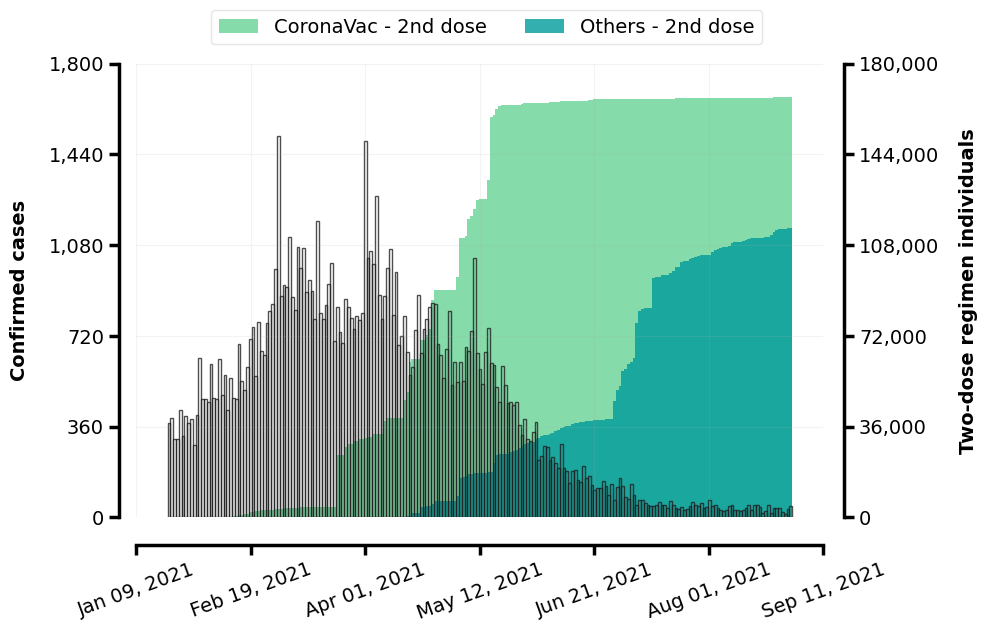

In [65]:
fig1_2, ax1_2 = plt.subplots(1,1, figsize=(10,6))
ax2_2 = ax1_2.twinx()

subdata_obito = curve[(curve["Data"]>=dt.date(2021,1,21)) & (curve["Data"]<=dt.date(2021, 8, 31))]

subdata = curve1[:-1].fillna(0.0)
dates_ = subdata["Data"].tolist()
ticks_ = np.arange(len(dates_))
ax1_2.set_xticks(ticks_, labels=dates_)
ax1_2.tick_params(direction="out", width=2.5, top=False, right=False, labelsize=14, length=7)
ax2_2.tick_params(direction="out", width=2.5, top=False, right=True, bottom=False, left=False, labelsize=14, length=7)

for axis in [ax1_2, ax2_2]:
    axis.grid(alpha=0.15)
    axis.xaxis.set_major_locator(plt.MaxNLocator(11))
    axis.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
ax1_2.spines['top'].set_color('none')
ax1_2.spines['right'].set_color('none')
ax1_2.spines['left'].set_position(('data', 18630))
ax1_2.spines['bottom'].set_position(('outward', 20.0))
ax2_2.spines['right'].set_position(('outward', 15))
    
ax1_2.xaxis.set_major_locator(mdates.MonthLocator())
ax1_2.xaxis.set_major_formatter(mdates.DateFormatter(fmt="%b %d, %Y"))
    
ax1_2.spines["left"].set_linewidth(2.5)
ax1_2.spines["bottom"].set_linewidth(2.5)
ax1_2.spines["top"].set_linewidth(0)
ax1_2.spines["right"].set_linewidth(2.5)
ax2_2.spines["left"].set_linewidth(0)
ax2_2.spines["bottom"].set_linewidth(0)
ax2_2.spines["top"].set_linewidth(0)
ax2_2.spines["right"].set_linewidth(2.5)
ax2_2.grid(alpha=0.0)
#abeb88
ax1_2.bar(dates_, subdata_obito["# casos confirmados"], facecolor="none", edgecolor='#202020', alpha=0.8, width=1)
ax2_2.bar(dates_, subdata["# DOSES CORONAVAC ACUM."], color='#67d294', alpha=0.8, width=1.0, label="CoronaVac - 2nd dose")
ax2_2.bar(dates_, subdata["# DOSES OUTRAS ACUM."], color='#009b9c', alpha=0.8, width=1.0, label="Others - 2nd dose")
#66d9ff
ax2_2.legend(ncol=2, prop={'size': 14,}, loc=2, bbox_to_anchor=(0.095, 1.14), framealpha=0.5, fancybox=True)

ax1_2.set_xticks(np.linspace(ax1_2.get_xbound()[0], ax1_2.get_xbound()[1], 7))
ax1_2.set_yticks(np.linspace(0, 1800, 6))
ax2_2.set_yticks(np.linspace(0, 180000, 6))
ax1_2.set_ylabel("Confirmed cases", weight="bold", fontsize=14, labelpad=14)
ax2_2.set_ylabel("Two-dose regimen individuals", weight="bold", fontsize=14, labelpad=14)

ax1_2.set_zorder(1)  
ax1_2.patch.set_visible(False)

plt.tight_layout()
ax1_2.set_xticklabels([ n.get_text() for n in  ax1_2.get_xticklabels() ], rotation=20)

[Text(18636.35, 0, 'Jan 09, 2021'),
 Text(18677.233333333334, 0, 'Feb 19, 2021'),
 Text(18718.116666666665, 0, 'Apr 01, 2021'),
 Text(18759.0, 0, 'May 12, 2021'),
 Text(18799.883333333335, 0, 'Jun 21, 2021'),
 Text(18840.766666666666, 0, 'Aug 01, 2021'),
 Text(18881.65, 0, 'Sep 11, 2021')]

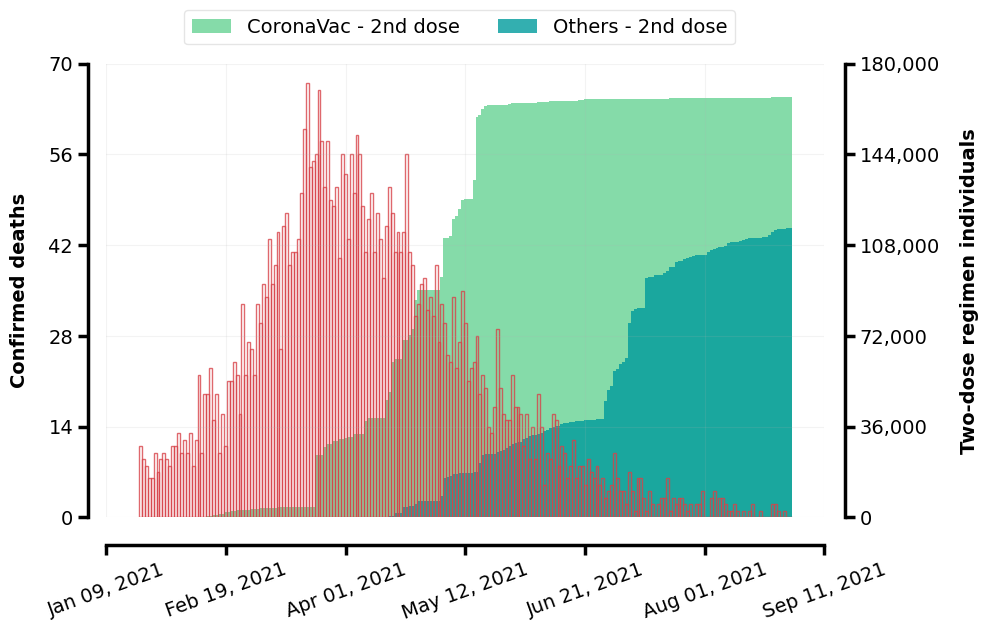

In [64]:
fig1_3, ax1_3 = plt.subplots(1,1, figsize=(10,6))
ax2_3 = ax1_3.twinx()

subdata_obito = curve[(curve["Data"]>=dt.date(2021,1,21)) & (curve["Data"]<=dt.date(2021, 8, 31))]

subdata = curve1[:-1].fillna(0.0)
dates_ = subdata["Data"].tolist()
ticks_ = np.arange(len(dates_))
ax1_3.set_xticks(ticks_, labels=dates_)
ax1_3.tick_params(direction="out", width=2.5, top=False, right=False, labelsize=14, length=7)
ax2_3.tick_params(direction="out", width=2.5, top=False, right=True, bottom=False, left=False, labelsize=14, length=7)

for axis in [ax1_3, ax2_3]:
    axis.grid(alpha=0.15)
    axis.xaxis.set_major_locator(plt.MaxNLocator(11))
    axis.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
ax1_3.spines['top'].set_color('none')
ax1_3.spines['right'].set_color('none')
ax1_3.spines['left'].set_position(('data', 18630))
ax1_3.spines['bottom'].set_position(('outward', 20.0))
ax2_3.spines['right'].set_position(('outward', 15))
    
ax1_3.xaxis.set_major_locator(mdates.MonthLocator())
ax1_3.xaxis.set_major_formatter(mdates.DateFormatter(fmt="%b %d, %Y"))
    
ax1_3.spines["left"].set_linewidth(2.5)
ax1_3.spines["bottom"].set_linewidth(2.5)
ax1_3.spines["top"].set_linewidth(0)
ax1_3.spines["right"].set_linewidth(2.5)
ax2_3.spines["left"].set_linewidth(0)
ax2_3.spines["bottom"].set_linewidth(0)
ax2_3.spines["top"].set_linewidth(0)
ax2_3.spines["right"].set_linewidth(2.5)
ax2_3.grid(alpha=0.0)

#plt.show()
#ax1_2.axvline(dates_[0], 0, 2000, color="#202020", lw=1.5, ls="--")
#ax1_2.axvline(dates_[-1], 0, 2000, color="#202020", lw=1.5, ls="--")

ax1_3.bar(dates_, subdata_obito["# obitos confirmados"], facecolor="none", edgecolor='#d74249', alpha=0.8, width=1)
ax2_3.bar(dates_, subdata["# DOSES CORONAVAC ACUM."], color='#67d294', alpha=0.8, width=1.0, label="CoronaVac - 2nd dose")
ax2_3.bar(dates_, subdata["# DOSES OUTRAS ACUM."], color="#009b9c", alpha=0.8, width=1.0, label="Others - 2nd dose")

ax2_3.legend(ncol=2, prop={'size': 14, }, loc=2, bbox_to_anchor=(0.095, 1.14), framealpha=0.5, fancybox=True)

ax1_3.set_xticks(np.linspace(ax1_2.get_xbound()[0], ax1_2.get_xbound()[1], 7))
ax1_3.set_yticks(np.linspace(0, 70, 6))
ax2_3.set_yticks(np.linspace(0, 180000, 6))
ax1_3.set_ylim([0,70])
#ax2_2.legend()
ax1_3.set_ylabel("Confirmed deaths", weight="bold", fontsize=14, labelpad=14)
ax2_3.set_ylabel("Two-dose regimen individuals", weight="bold", fontsize=14, labelpad=14)

ax1_3.set_zorder(1)  # default zorder is 0 for ax1 and ax2
ax1_3.patch.set_visible(False)  # prevents ax1 from hiding ax2

plt.tight_layout()
ax1_3.set_xticklabels([ n.get_text() for n in  ax1_3.get_xticklabels() ], rotation=20)

### Save figs

In [67]:
fig1_1.savefig(os.path.join(fig_folder, "WAVES_VAC_COVERAGE", "FIG_1_PART1_V6.svg"), dpi=150, transparent=False, facecolor='white', bbox_inches="tight")
fig1_1.savefig(os.path.join(fig_folder, "WAVES_VAC_COVERAGE", "FIG_1_PART1_V6.png"), dpi=150, transparent=False, facecolor='white', bbox_inches="tight")
fig1_1.savefig(os.path.join(fig_folder, "WAVES_VAC_COVERAGE", "FIG_1_PART1_V6.pdf"), dpi=150, transparent=False, facecolor='white', bbox_inches="tight")
fig1_1.savefig(os.path.join(fig_folder, "WAVES_VAC_COVERAGE", "FIG_1_PART1_V6.jpg"), dpi=150, transparent=False, facecolor='white', bbox_inches="tight")
fig1_2.savefig(os.path.join(fig_folder, "WAVES_VAC_COVERAGE", "FIG_1_PART2_V6.svg"), dpi=150, transparent=False, facecolor='white', bbox_inches="tight")
fig1_2.savefig(os.path.join(fig_folder, "WAVES_VAC_COVERAGE", "FIG_1_PART2_V6.png"), dpi=150, transparent=False, facecolor='white', bbox_inches="tight")
fig1_2.savefig(os.path.join(fig_folder, "WAVES_VAC_COVERAGE", "FIG_1_PART2_V6.jpg"), dpi=150, transparent=False, facecolor='white', bbox_inches="tight")
fig1_2.savefig(os.path.join(fig_folder, "WAVES_VAC_COVERAGE", "FIG_1_PART2_V6.pdf"), dpi=150, transparent=False, facecolor='white', bbox_inches="tight")
fig1_3.savefig(os.path.join(fig_folder, "WAVES_VAC_COVERAGE", "FIG_1_PART3_V6.svg"), dpi=150, transparent=False, facecolor='white', bbox_inches="tight")
fig1_3.savefig(os.path.join(fig_folder, "WAVES_VAC_COVERAGE", "FIG_1_PART3_V6.png"), dpi=150, transparent=False, facecolor='white', bbox_inches="tight")
fig1_3.savefig(os.path.join(fig_folder, "WAVES_VAC_COVERAGE", "FIG_1_PART3_V6.jpg"), dpi=150, transparent=False, facecolor='white', bbox_inches="tight")
fig1_3.savefig(os.path.join(fig_folder, "WAVES_VAC_COVERAGE", "FIG_1_PART3_V6.pdf"), dpi=150, transparent=False, facecolor='white', bbox_inches="tight")

## **FIGURE 2 (SUPP): D1 TO D2 INTERVAL**

In [6]:
day = 0
dose = "D1"
seed = 2
pair_df = pd.read_parquet(os.path.join("..", "output", "PAREAMENTO", "CORONAVAC", 'NOVO_D1D2REG_HDI_2_21JAN2021_31AUG2021', f'PAREADOS_CPF_{dose}_DAY{day}_{seed}.parquet'))
df_sub = fschema[(fschema["CPF"].isin(pair_df["CPF CASO"])) | (fschema["CPF"].isin(pair_df["CPF CONTROLE"]))]

In [7]:
df_sub[["DATA D1", "DATA D2"]].sample(n=6)

,DATA D1,DATA D2
777740,2021-04-02,2021-05-08
71414,2021-04-02,2021-05-15
2221908,2021-05-26,2021-08-25
1005087,2021-04-15,2021-07-07
2251773,2021-03-27,2021-04-24
1728700,2021-03-30,2021-05-05


In [8]:
df_sub["DIFF"] = df_sub[["DATA D1", "DATA D2"]].apply(lambda x: (x["DATA D2"]-x["DATA D1"]).days, axis=1)
diff_days = df_sub["DIFF"].array
diff_days = diff_days[~np.isnan(diff_days)]
print(f"Max and Min interval: {diff_days.max()}, {diff_days.min()}")
diff_days

Max and Min interval: 341.0, -143.0


<PandasArray>
[75.0, 89.0, 76.0, 60.0, 63.0, 15.0, 65.0, 85.0, 22.0, 81.0,
 ...
 89.0, 43.0, 81.0, 37.0, 13.0, 65.0, 90.0, 26.0,  0.0, 43.0]
Length: 188876, dtype: float64

(172335,)


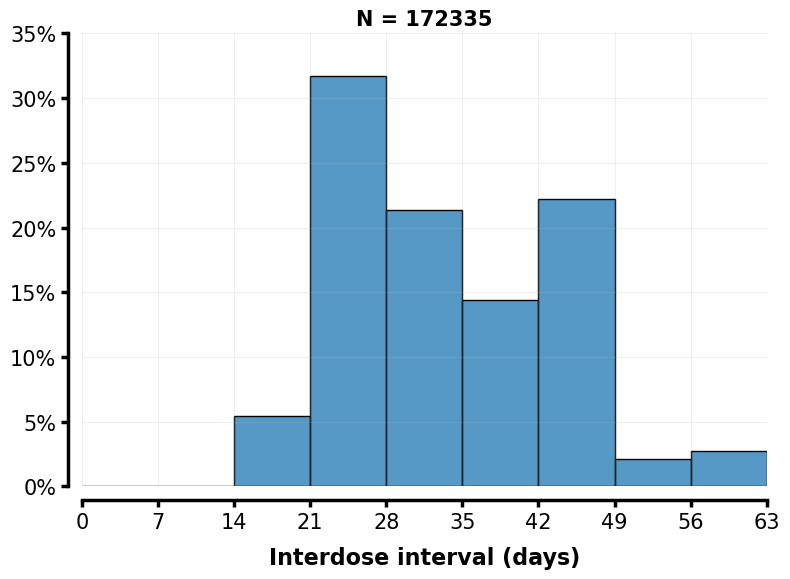

In [9]:
fig2, ax2 = plt.subplots(1,1, figsize=(8.,5.9))

lower_perc = np.percentile(diff_days, 5)
upper_perc = np.percentile(diff_days, 95)
diff_days_1 = diff_days[np.logical_and(diff_days>=lower_perc,  diff_days<=upper_perc)]
print(diff_days_1.shape)
bins=np.arange(0, 70, 7)

s = sns.histplot(data=diff_days_1, bins=bins, ax=ax2, stat='percent')
ax2.grid(alpha=0.2)
ax2.set_xlabel("Interdose interval (days)", weight='bold', fontsize=16, labelpad=10)
ax2.set_ylabel("", weight='bold', fontsize=16, labelpad=12)
ax2.tick_params(labelsize=13)
ax2.set_title(f"N = {diff_days_1.shape[0]}", fontsize=15, weight='bold')
ax2.set_xticks(bins)

ax2.spines['top'].set_color('none')
ax2.spines['right'].set_color('none')
ax2.spines['left'].set_position(('outward', 10))
ax2.spines['bottom'].set_position(('outward', 10.0))

ax2.spines["left"].set_linewidth(2.5)
ax2.spines["bottom"].set_linewidth(2.5)
ax2.spines["top"].set_linewidth(2.5)
ax2.spines["right"].set_linewidth(2.5)
ax2.set_xlim([bins[0], bins[-1]])
ax2.set_ylim([0,35])
ax2.yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))

ax2.tick_params(labelsize=15, width=2.5, length=5)
plt.tight_layout()

### Save figs

In [384]:
fig2.savefig(os.path.join(fig_folder, "DOSES_INTERVAL", "DOSES_INTERVAL_FIXED.svg"), transparent=False, facecolor='white')
fig2.savefig(os.path.join(fig_folder, "DOSES_INTERVAL", "DOSES_INTERVAL_FIXED.png"), transparent=False, facecolor='white')
fig2.savefig(os.path.join(fig_folder, "DOSES_INTERVAL", "DOSES_INTERVAL_FIXED.jpg"), transparent=False, facecolor='white')
fig2.savefig(os.path.join(fig_folder, "DOSES_INTERVAL", "DOSES_INTERVAL_FIXED.pdf"), transparent=False, facecolor='white')

## **QUERY**: 

In [15]:
seed_cohort = 21
test = "NOVO_D1D2REG"
event = "HOSPITAL"

#### Follow-up details for the main text - **Study population** section

In [16]:
age_cond = fschema["IDADE"]>=60
vac_dates = (fschema["DATA D1"]<=dt.datetime(2021, 8, 31)) & (fschema["VACINA APLICADA"]=="CORONAVAC")
age_vac = fschema[(age_cond) & (vac_dates)]

In [17]:
coronavac_60yo = age_vac["VACINA APLICADA"].shape[0]
print(f"{coronavac_60yo:,} were vaccinated with CoronaVac before the end of cohort")

186,939 were vaccinated with CoronaVac before the end of cohort


In [18]:
cohort_period = (df_eligible["DATA D1"]>=dt.datetime(2021, 1, 21)) & (df_eligible["DATA D1"]<=dt.datetime(2021, 8, 31))
cohort_period = df_eligible["DATA D1"]<=dt.datetime(2021, 8, 31)
vaccine_taken = df_eligible["VACINA APLICADA"]=="CORONAVAC"

coron = df_eligible[(cohort_period) & (vaccine_taken)]
print(f"Eligible to participate in the cohort: {df_eligible.shape[0]}")
print(f"Vaccinated with coronavac before end of cohort: {coron.shape[0]}")
print(f"Status vaccination during cohort:")
print(coron["STATUS VACINACAO DURANTE COORTE"].value_counts())

Eligible to participate in the cohort: 324302
Vaccinated with coronavac before end of cohort: 170386
Status vaccination during cohort:
(D1)(D2)    166748
(D1)          3637
(D4)             1
Name: STATUS VACINACAO DURANTE COORTE, dtype: int64


In [19]:
pair_d1 = etc_utils.open_survival(pareamento_folder, "CORONAVAC", test, 2, "D1", "21JAN2021_31AUG2021", event, 14, seed=seed_cohort)
km_d1 = etc_utils.open_km(pareamento_folder, "CORONAVAC", test, 2, "D1", "21JAN2021_31AUG2021", event, 14, seed=seed_cohort)

In [12]:
n_pairs_d1 = pair_d1[pair_d1['TIPO']=='CASO'].shape[0]
print(f"Number of matched pairs (D1): {n_pairs_d1:,}")

Number of matched pairs (D1): 124,609


In [13]:
pair_d1[f"t - {event} - fmt"] = pair_d1[f"t - {event}"].apply(lambda x: x if x<=90 else np.nan)

In [20]:
pair_d2 = etc_utils.open_survival(pareamento_folder, "CORONAVAC", test, 2, "D2", "21JAN2021_31AUG2021", event, 14, seed=seed_cohort)
km_d2 = etc_utils.open_km(pareamento_folder, "CORONAVAC", test, 2, "D2", "21JAN2021_31AUG2021", event, 14, seed=seed_cohort)

In [24]:
pair_d2_e = etc_utils.get_pairs_events(pareamento_folder, "CORONAVAC", test, 2, "D2", "21JAN2021_31AUG2021", 14, seed=seed_cohort)

In [22]:
pair_d2["E - HOSPITAL"].value_counts()

False    124752
True        212
Name: E - HOSPITAL, dtype: int64

In [28]:
pair_d2_e

,CPF,DATA D1,DATA D2,DATA OBITO COVID,DATA OBITO GERAL,DATA HOSPITALIZACAO,DATA UTI,TIPO,PAR,CASO INTERVALO,CASO CENSURADO,CONTROLE INTERVALO,CONTROLE CENSURADO
0,13548310397,2021-02-11,2021-02-12,NaT,NaT,NaT,NaT,CASO,12382124334,50.0,True,50.0,True
2,13640151372,2021-02-10,2021-02-12,NaT,NaT,NaT,NaT,CASO,19033486334,200.0,True,200.0,True
4,26320053372,2021-02-12,2021-02-12,NaT,NaT,NaT,NaT,CASO,38273896315,46.0,True,46.0,True
6,21858594391,2021-02-11,2021-02-12,NaT,NaT,NaT,NaT,CASO,24140503300,68.0,True,68.0,True
8,15618161320,2021-02-11,2021-02-12,NaT,NaT,NaT,NaT,CASO,89302800300,200.0,True,200.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
124956,15517446353,2021-07-30,2021-08-30,NaT,NaT,NaT,NaT,CASO,30793130468,1.0,True,1.0,True
124958,44784678387,2021-07-30,2021-08-30,NaT,NaT,NaT,NaT,CASO,21855170310,1.0,True,1.0,True
124960,19552777372,2021-07-21,2021-08-30,NaT,NaT,NaT,NaT,CASO,42557518387,1.0,True,1.0,True
124962,27761339368,2021-08-30,2021-08-30,NaT,NaT,NaT,NaT,CASO,20971656304,1.0,True,1.0,True


In [15]:
n_pairs_d2 = pair_d2[pair_d2['TIPO']=='CASO'].shape[0]
print(f"Number of matched pairs (D2): {n_pairs_d2:,}")

Number of matched pairs (D2): 62,482


In [16]:
# Pairs with more than 90 days of follow-up are said to have 90 follow-up days in the analysis.
pair_d2[f"t - {event} - fmt"] = pair_d2[f"t - {event}"].apply(lambda x: x if x<=90 else np.nan)

In [17]:
median_d2_0 = pair_d2[pair_d2[f"t - {event} - fmt"]>=0][f"t - {event} - fmt"].median()
median_d2_14 = pair_d2[pair_d2[f"t - {event} - fmt"]>=14][f"t - {event} - fmt"].median()
print(f"Median follow-up time (all pairs): {median_d2_0}")
print(f"Median follow-up time (only pairs still at risk at day 13): {median_d2_14}")

Median follow-up time (all pairs): 16.0
Median follow-up time (only pairs still at risk at day 13): 36.0


In [18]:
iqr_median_d2_0_lower = np.percentile(pair_d2[pair_d2[f"t - {event} - fmt"]>=0][f"t - {event} - fmt"].array, 25)
iqr_median_d2_14_lower = np.percentile(pair_d2[pair_d2[f"t - {event} - fmt"]>=14][f"t - {event} - fmt"].array, 25)
print(f"IQR(lower) of median follow-up time (all pairs): {iqr_median_d2_0_lower}")
print(f"IQR(lower) of median follow-up time (only pairs still at risk at day 13): {iqr_median_d2_14_lower}")

IQR(lower) of median follow-up time (all pairs): 4.0
IQR(lower) of median follow-up time (only pairs still at risk at day 13): 24.0


In [19]:
iqr_median_d2_0_upper = np.percentile(pair_d2[pair_d2[f"t - {event} - fmt"]>=0][f"t - {event} - fmt"].array, 75)
iqr_median_d2_14_upper = np.percentile(pair_d2[pair_d2[f"t - {event} - fmt"]>=14][f"t - {event} - fmt"].array, 75)
print(f"IQR(upper) of median follow-up time (all pairs): {iqr_median_d2_0_upper}")
print(f"IQR(upper) of median follow-up time (only pairs still at risk at day 13): {iqr_median_d2_14_upper}")

IQR(upper) of median follow-up time (all pairs): 40.0
IQR(upper) of median follow-up time (only pairs still at risk at day 13): 55.0


In [20]:
mean_d2_0 = np.mean(pair_d2[pair_d2[f"t - {event} - fmt"]>=0][f"t - {event} - fmt"].array)
mean_d2_14 = np.mean(pair_d2[pair_d2[f"t - {event} - fmt"]>=14][f"t - {event} - fmt"].array)
print(f"Mean follow-up time (all pairs): {mean_d2_0}")
print(f"Mean follow-up time (only pairs still at risk at day 13): {mean_d2_14}")

Mean follow-up time (all pairs): 24.61733792445287
Mean follow-up time (only pairs still at risk at day 13): 40.47084167157151


In [21]:
total_followup_d1_0 = np.sum(pair_d1[pair_d1[f"t - {event} - fmt"]>=0][f"t - {event} - fmt"].array)
total_followup_d1_14 = np.sum(pair_d1[pair_d1[f"t - {event} - fmt"]>=14][f"t - {event} - fmt"].array)
print(f"Total follow-up time (all pairs): {total_followup_d1_0}")
print(f"Total follow-up time (only pairs still at risk at day 13): {total_followup_d1_14}")

Total follow-up time (all pairs): 3595040.0
Total follow-up time (only pairs still at risk at day 13): 3061577.0


In [30]:
total_followup_d2_0 = np.sum(pair_d2[pair_d2[f"t - {event} - fmt"]>=0][f"t - {event} - fmt"].array)
total_followup_d2_14 = np.sum(pair_d2[pair_d2[f"t - {event} - fmt"]>=14][f"t - {event} - fmt"].array)
print(f"Total follow-up time (all pairs): {total_followup_d2_0}")
print(f"Total follow-up time (only pairs still at risk at day 13): {total_followup_d2_14}")

Total follow-up time (all pairs): 1908853.0
Total follow-up time (only pairs still at risk at day 13): 1718999.0


In [22]:
# --> Vaccinated controls
controle_cpfs = pair_d2[pair_d2["TIPO"]=="CONTROLE"]["CPF"]
sub_df = fschema[fschema["CPF"].isin(controle_cpfs)]
controle_vacinados = sub_df[sub_df["STATUS VACINACAO DURANTE COORTE"]!=""]
controle_vacinados = controle_vacinados["CPF"]

status = sub_df["STATUS VACINACAO DURANTE COORTE"].value_counts()
other_vac = sub_df[(sub_df["VACINA APLICADA"]!="CORONAVAC") & (sub_df["STATUS VACINACAO DURANTE COORTE"]!="")]
n_control_vac = status.loc["(D1)(D2)"] + status.loc["(D1)"] + status.loc["(D4)"]

n_control_corona = sub_df[(sub_df["VACINA APLICADA"]=="CORONAVAC") & (sub_df["STATUS VACINACAO DURANTE COORTE"]!="")].shape[0]
n_control_other = sub_df[(sub_df["VACINA APLICADA"]!="CORONAVAC") & (sub_df["STATUS VACINACAO DURANTE COORTE"]!="")].shape[0]

In [23]:
print(f"# of controls: {sub_df.shape[0]}")
print(f"# of controls received Vaccine: {n_control_vac} ({(n_control_vac/sub_df.shape[0])*100:.2f}%)")
print(f"# of controls received CoronaVac: {n_control_corona} ({(n_control_corona/sub_df.shape[0])*100:.2f}%)")
print(f"# of controls received Other: {n_control_other} ({(n_control_other/sub_df.shape[0])*100:.2f}%)")

# of controls: 62482
# of controls received Vaccine: 41202 (65.94%)
# of controls received CoronaVac: 18752 (30.01%)
# of controls received Other: 22450 (35.93%)


In [24]:
others = other_vac["VACINA APLICADA"].value_counts()
print(f"# of controls with ASTRAZENECA: {others.loc['ASTRAZENECA']} ({(others.loc['ASTRAZENECA']/sub_df.shape[0])*100:.2f}%)")
print(f"# of controls with PFIZER: {others.loc['PFIZER']} ({(others.loc['PFIZER']/sub_df.shape[0])*100:.2f}%)")
print(f"# of controls with JANSSEN: {others.loc['JANSSEN']} ({(others.loc['JANSSEN']/sub_df.shape[0])*100:.2f}%)")

# of controls with ASTRAZENECA: 19302 (30.89%)
# of controls with PFIZER: 2798 (4.48%)
# of controls with JANSSEN: 350 (0.56%)


In [25]:
censored_control = pair_d2[(pair_d2["CPF"].isin(controle_vacinados)) & (pair_d2["TIPO"]=="CONTROLE")][f"E - {event}"].value_counts()
print(f"Controls censured: {censored_control.loc[False]}")

Controls censured: 41157


In [26]:
vaccinated_during_cohort = fschema[fschema["STATUS VACINACAO DURANTE COORTE"]!=""].shape[0]
print(f"Vaccinated during cohort: {vaccinated_during_cohort}")

Vaccinated during cohort: 1693174


In [28]:
# IRREGULAR+323
(1399+136+11402)/(324302)

0.039891829220911376

In [31]:
text = f'''
Considering the {fschema.shape[0]:,} individuals included in the VACINE JÁ database, 
{vaccinated_during_cohort:,} were vaccinated during the duration of the cohort. Four 
types of vaccines were applied during the period of the cohort, and CoronaVac was the most 
one used among elderly adults in the first three months of the campaign. For individuals 
aged ≥ 60 years, {coronavac_60yo:,} were vaccinated with CoronaVac before the end of the cohort and 
{df_eligible.shape[0]:,} were eligible to participate in the cohort. From the eligible population, {n_pairs_d2:,} 
were matched to unvaccinated controls for the two-dose regimen cohort. For the analysis 
regarding a single dose of CoronaVac, {n_pairs_d1:,} were matched to unvaccinated controls. 
The total follow-up time was {total_followup_d2_0:,.0f} days, with a median 
follow-up time of {median_d2_14:0.0f} days (IQR {iqr_median_d2_14_lower:0.0f}-{iqr_median_d2_14_upper:0.0f}) 
after the first 13 days in the two-dose regimen in both groups, with a maximum follow-up 
time of 90 days. During the cohort, a total of 149,694 confirmed tests for Covid-19 were 
performed, consisting of both RT-PCR and rapid antigen tests.

Most of the controls received the first dose during the cohort, independent of which vaccine 
they received (Table I); {(n_control_corona/sub_df.shape[0])*100:.1f}% of the controls received 
CoronaVac, and then were included in the vaccinated group and matched with a new unvaccinated 
control, while {(n_control_other/sub_df.shape[0])*100:.1f}% of the controls received a different vaccine: 
{(others.loc['ASTRAZENECA']/sub_df.shape[0])*100:.1f}% ChAdOx1 nCoV-19 (AstraZeneca), 
{(others.loc['PFIZER']/sub_df.shape[0])*100:.1f}% BNT162b2 (Pfizer-BioNtech), and 
{(others.loc['JANSSEN']/sub_df.shape[0])*100:.1f}% Ad26.COV2.S (Janssen). A total of {censored_control.loc[False]:,} matched pairs 
in which controls were eventually vaccinated during the follow-up were censored, and about 10% 
of the eligible persons were dropped from the analysis due to irregular information or missing 
essential data for matching (Fig. 4).

As the registration on the platform VACINE JÁ is done by individuals willing to receive a vaccine, 
there is a valid concern that the population associated with the registry might not represent well 
the population of Fortaleza. However, while it is expected that specific groups should be excluded 
from the database, such as individuals who are avowedly against vaccines, the uptake in Fortaleza 
was very high, reinforced by the obligation of “vaccination passports” [47]. Indeed, the main 
characteristics of the 60+ years population registered in VACINE JÁ and that estimated for Fortaleza 
in 2021 are quite similar (Fig. 5).
'''
print(text)


Considering the 2,275,309 individuals included in the VACINE JÁ database, 
1,693,174 were vaccinated during the duration of the cohort. Four 
types of vaccines were applied during the period of the cohort, and CoronaVac was the most 
one used among elderly adults in the first three months of the campaign. For individuals 
aged ≥ 60 years, 186,939 were vaccinated with CoronaVac before the end of the cohort and 
324,302 were eligible to participate in the cohort. From the eligible population, 62,482 
were matched to unvaccinated controls for the two-dose regimen cohort. For the analysis 
regarding a single dose of CoronaVac, 124,609 were matched to unvaccinated controls. 
The total follow-up time was 1,908,853 days, with a median 
follow-up time of 36 days (IQR 24-55) 
after the first 13 days in the two-dose regimen in both groups, with a maximum follow-up 
time of 90 days. During the cohort, a total of 149,694 confirmed tests for Covid-19 were 
performed, consisting of both RT-PCR and 

In [30]:
pair_d2["CPF"]

12218898349    2
21367752353    2
18910858320    2
08827621334    2
23376961387    2
              ..
14159520359    1
35944765372    1
12063436304    1
24488364349    1
54235880306    1
Name: CPF, Length: 123365, dtype: int64

#### Follow-up details for the main text - **Vaccine Effectiveness** section

In [31]:
df_elig = df_eligible
pair_d2 = etc_utils.open_survival(pareamento_folder, "CORONAVAC", test, 2, "D2", "21JAN2021_31AUG2021", event, 14, seed=seed_cohort)
#km_d2 = etc_utils.open_km(pareamento_folder, "CORONAVAC", test, 2, "D2", "21JAN2021_31AUG2021", event, 14, seed=seed_cohort)
matched_df = df_elig[df_elig["CPF"].isin(pair_d2["CPF"].unique())]
# --> KM & VE
hosp_km_d2 = etc_utils.open_km(pareamento_folder, "CORONAVAC", test, 2, "D2", "21JAN2021_31AUG2021", "HOSPITAL", 14, seed=seed_cohort)
uti_km_d2 = etc_utils.open_km(pareamento_folder, "CORONAVAC", test, 2, "D2", "21JAN2021_31AUG2021", "UTI", 14, seed=seed_cohort)
obito_km_d2 = etc_utils.open_km(pareamento_folder, "CORONAVAC", test, 2, "D2", "21JAN2021_31AUG2021", "OBITO", 14, seed=seed_cohort)
hosp_km_d2["KM_DOSE"]["OBSERVED(CASO)_CUMM"] = hosp_km_d2["KM_DOSE"]["observed(caso)"].cumsum()
uti_km_d2["KM_DOSE"]["OBSERVED(CASO)_CUMM"] = uti_km_d2["KM_DOSE"]["observed(caso)"].cumsum()
obito_km_d2["KM_DOSE"]["OBSERVED(CASO)_CUMM"] = obito_km_d2["KM_DOSE"]["observed(caso)"].cumsum()
hosp_km_d2["KM_DOSE"]["OBSERVED(CONTROLE)_CUMM"] = hosp_km_d2["KM_DOSE"]["observed(controle)"].cumsum()
uti_km_d2["KM_DOSE"]["OBSERVED(CONTROLE)_CUMM"] = uti_km_d2["KM_DOSE"]["observed(controle)"].cumsum()
obito_km_d2["KM_DOSE"]["OBSERVED(CONTROLE)_CUMM"] = obito_km_d2["KM_DOSE"]["observed(controle)"].cumsum()

hosp_km_d2["KM_MALE"]["OBSERVED(CASO)_CUMM"] = hosp_km_d2["KM_MALE"]["observed(caso)"].cumsum()
hosp_km_d2["KM_MALE"]["OBSERVED(CONTROLE)_CUMM"] = hosp_km_d2["KM_MALE"]["observed(controle)"].cumsum()
hosp_km_d2["KM_FEMALE"]["OBSERVED(CASO)_CUMM"] = hosp_km_d2["KM_FEMALE"]["observed(caso)"].cumsum()
hosp_km_d2["KM_FEMALE"]["OBSERVED(CONTROLE)_CUMM"] = hosp_km_d2["KM_FEMALE"]["observed(controle)"].cumsum()
hosp_km_d2["KM_6069"]["OBSERVED(CASO)_CUMM"] = hosp_km_d2["KM_6069"]["observed(caso)"].cumsum()
hosp_km_d2["KM_6069"]["OBSERVED(CONTROLE)_CUMM"] = hosp_km_d2["KM_6069"]["observed(controle)"].cumsum()
hosp_km_d2["KM_7079"]["OBSERVED(CASO)_CUMM"] = hosp_km_d2["KM_7079"]["observed(caso)"].cumsum()
hosp_km_d2["KM_7079"]["OBSERVED(CONTROLE)_CUMM"] = hosp_km_d2["KM_7079"]["observed(controle)"].cumsum()
hosp_km_d2["KM_80+"]["OBSERVED(CASO)_CUMM"] = hosp_km_d2["KM_80+"]["observed(caso)"].cumsum()
hosp_km_d2["KM_80+"]["OBSERVED(CONTROLE)_CUMM"] = hosp_km_d2["KM_80+"]["observed(controle)"].cumsum()

hosp_ve_d2 = etc_utils.open_ve(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG", 2, "D2", "21JAN2021_31AUG2021", "HOSPITAL", day_risk=14, seed=seed_cohort)
uti_ve_d2 = etc_utils.open_ve(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG", 2, "D2", "21JAN2021_31AUG2021", "UTI", day_risk=14, seed=seed_cohort)
obito_ve_d2 = etc_utils.open_ve(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG", 2, "D2", "21JAN2021_31AUG2021", "OBITO", day_risk=14, seed=seed_cohort)

In [32]:
temp = pair_d2["CPF"].value_counts().reset_index()
temp[temp["CPF"]==2]

,index,CPF
0,12218898349,2
1,21367752353,2
2,18910858320,2
3,08827621334,2
4,23376961387,2
...,...,...
1594,11277246300,2
1595,11971983349,2
1596,30216761387,2
1597,17007119387,2


In [68]:
#hosp_n = df_elig["DATA HOSPITALIZACAO"].notnull().sum()
#uti_n = df_elig["DATA UTI"].notnull().sum()
#obito_n = df_elig["DATA OBITO"].notnull().sum()
#print(f"HOSPITAL number recorded in the eligible population: {hosp_n}")
#print(f"UTI number recorded in the eligible population: {uti_n}")
#print(f"OBITO number recorded in the eligible population: {obito_n}")

In [65]:
dt_init = dt.datetime(2021, 1, 21)
dt_final = dt.datetime(2021, 8, 31)

df_elig["DATA HOSPITAL UNICA"] = df_elig["DATA HOSPITALIZACAO"].apply(lambda x: [n for n in x if pd.notna(n) and n>=dt_init and n<=dt_final] if np.any(pd.notna(x)) else np.nan )
df_elig["DATA UTI UNICA"] = df_elig["DATA UTI"].apply(lambda x: [n for n in x if pd.notna(n) and n>=dt_init and n<=dt_final] if np.any(pd.notna(x)) else np.nan )
df_elig["DATA HOSPITAL UNICA"] = df_elig["DATA HOSPITAL UNICA"].apply(lambda x: np.nan if np.all(pd.isna(x)) or len(x)==0 else x)
df_elig["DATA UTI UNICA"] = df_elig["DATA UTI UNICA"].apply(lambda x: np.nan if np.all(pd.isna(x)) or len(x)==0 else x)

hosp_n = df_elig["DATA HOSPITAL UNICA"].notnull().sum()
uti_n = df_elig["DATA UTI UNICA"].notnull().sum()
obito_n = df_elig[(df_elig["DATA OBITO"]>=dt_init) & (df_elig["DATA OBITO"]<=dt_final)].shape[0]
print(f"HOSPITAL number recorded in the eligible population: {hosp_n}")
print(f"UTI number recorded in the eligible population: {uti_n}")
print(f"OBITO number recorded in the eligible population: {obito_n}")

HOSPITAL number recorded in the eligible population: 4461
UTI number recorded in the eligible population: 1025
OBITO number recorded in the eligible population: 916


In [64]:
matched_df["DATA HOSPITAL UNICA"] = matched_df["DATA HOSPITALIZACAO"].apply(lambda x: [n for n in x if pd.notna(n) and n>=dt_init and n<=dt_final] if np.any(pd.notna(x)) else np.nan )
matched_df["DATA UTI UNICA"] = matched_df["DATA UTI"].apply(lambda x: [n for n in x if pd.notna(n) and n>=dt_init and n<=dt_final] if np.any(pd.notna(x)) else np.nan )
matched_df["INTEGRA PRI SINTOMAS UNICA"] = matched_df['INTEGRA PRI SINTOMAS DATA'].apply(lambda x: [n for n in x if pd.notna(n) and n>=dt_init and n<=dt_final] if np.any(pd.notna(x)) else np.nan )

matched_df["DATA HOSPITAL UNICA"] = matched_df["DATA HOSPITAL UNICA"].apply(lambda x: np.nan if np.all(pd.isna(x)) or len(x)==0 else x)
matched_df["DATA UTI UNICA"] = matched_df["DATA UTI UNICA"].apply(lambda x: np.nan if np.all(pd.isna(x)) or len(x)==0 else x)
matched_df["INTEGRA PRI SINTOMAS UNICA"] = matched_df["INTEGRA PRI SINTOMAS UNICA"].apply(lambda x: np.nan if np.all(pd.isna(x)) or len(x)==0 else x)

hosp_matched_n = matched_df["DATA HOSPITAL UNICA"].notnull().sum()
uti_matched_n = matched_df["DATA UTI UNICA"].notnull().sum()
obito_matched_n = matched_df[(matched_df["DATA OBITO"]>=dt_init) & (matched_df["DATA OBITO"]<=dt_final)].shape[0]
doc_inf_matched_n = matched_df['INTEGRA PRI SINTOMAS UNICA'].notnull().sum()
print(f"DOCUMENTED INFECTION number recorded in the matched population: {doc_inf_matched_n}")
print(f"HOSPITAL number recorded in the matched population: {hosp_matched_n}")
print(f"UTI number recorded in the matched population: {uti_matched_n}")
print(f"OBITO number recorded in the matched population: {obito_matched_n}")

DOCUMENTED INFECTION number recorded in the eligible population: 1951
HOSPITAL number recorded in the eligible population: 406
UTI number recorded in the eligible population: 92
OBITO number recorded in the eligible population: 112


In [630]:
ve_hosp_v = hosp_ve_d2["DOSE"].set_index("t").loc[90].loc["VE_original"]
ve_hosp_v_l95 = hosp_ve_d2["DOSE"].set_index("t").loc[90].loc["VE_lower_0.95"]
ve_hosp_v_u95 = hosp_ve_d2["DOSE"].set_index("t").loc[90].loc["VE_upper_0.95"]
ve_uti_v = uti_ve_d2["DOSE"].set_index("t").loc[90].loc["VE_original"]
ve_uti_v_l95 = uti_ve_d2["DOSE"].set_index("t").loc[90].loc["VE_lower_0.95"]
ve_uti_v_u95 = uti_ve_d2["DOSE"].set_index("t").loc[90].loc["VE_upper_0.95"]
ve_obito_v = obito_ve_d2["DOSE"].set_index("t").loc[90].loc["VE_original"]
ve_obito_v_l95 = obito_ve_d2["DOSE"].set_index("t").loc[90].loc["VE_lower_0.95"]
ve_obito_v_u95 = obito_ve_d2["DOSE"].set_index("t").loc[90].loc["VE_upper_0.95"]
# --> Numbers by group
unvac_hosp_n = hosp_km_d2["KM_DOSE"].set_index("t").loc[90].loc["OBSERVED(CONTROLE)_CUMM"]
vac_hosp_n = hosp_km_d2["KM_DOSE"].set_index("t").loc[90].loc["OBSERVED(CASO)_CUMM"]
unvac_uti_n = uti_km_d2["KM_DOSE"].set_index("t").loc[90].loc["OBSERVED(CONTROLE)_CUMM"]
vac_uti_n = uti_km_d2["KM_DOSE"].set_index("t").loc[90].loc["OBSERVED(CASO)_CUMM"]
unvac_obito_n = obito_km_d2["KM_DOSE"].set_index("t").loc[90].loc["OBSERVED(CONTROLE)_CUMM"]
vac_obito_n = obito_km_d2["KM_DOSE"].set_index("t").loc[90].loc["OBSERVED(CASO)_CUMM"]

# --> Number at risk
at_risk_hosp_d2_0_caso = hosp_km_d2["KM_DOSE"].set_index("t")["at_risk(caso)"].loc[90]
at_risk_hosp_d2_0_controle = hosp_km_d2["KM_DOSE"].set_index("t")["at_risk(controle)"].loc[90]
at_risk_uti_d2_0_caso = uti_km_d2["KM_DOSE"].set_index("t")["at_risk(caso)"].loc[90]
at_risk_uti_d2_0_controle = uti_km_d2["KM_DOSE"].set_index("t")["at_risk(controle)"].loc[90]
at_risk_obito_d2_0_caso = obito_km_d2["KM_DOSE"].set_index("t")["at_risk(caso)"].loc[90]
at_risk_obito_d2_0_controle = obito_km_d2["KM_DOSE"].set_index("t")["at_risk(controle)"].loc[90]

In [631]:
print(f"VE - HOSPITAL - D2: {ve_hosp_v*100:.1f}% (95% CI {ve_hosp_v_l95*100:.1f}-{ve_hosp_v_u95*100:.1f})")
print(f"HOSPITAL - UNVAC VS VAC: {unvac_hosp_n} VS {vac_hosp_n}")

print(f"VE - UTI - D2: {ve_uti_v*100:.1f}% (95% CI {ve_uti_v_l95*100:.1f}-{ve_uti_v_u95*100:.1f})")
print(f"UTI - UNVAC VS VAC: {unvac_uti_n} VS {vac_uti_n}")
print(f"VE - OBITO - D2: {ve_obito_v*100:.1f}% (95% CI {ve_obito_v_l95*100:.1f}-{ve_obito_v_u95*100:.1f})")
print(f"OBITO - UNVAC VS VAC: {unvac_obito_n} VS {vac_obito_n}")

VE - HOSPITAL - D2: 55.8% (95% CI 42.7-68.3)
HOSPITAL - UNVAC VS VAC: 135.0 VS 60.0
VE - UTI - D2: 68.4% (95% CI 42.3-86.4)
UTI - UNVAC VS VAC: 32.0 VS 10.0
VE - OBITO - D2: 82.3% (95% CI 66.3-93.9)
OBITO - UNVAC VS VAC: 46.0 VS 8.0


In [632]:
# --> RISK
print("RISK TABLE")
print(f"HOSPITALIZATION UNVAC -> EVENTS: {unvac_hosp_n}, RISK PER 100,000(%): {(unvac_hosp_n/at_risk_hosp_d2_0_controle)*100000:.1f}")
print(f"HOSPITALIZATION VAC -> EVENTS: {vac_hosp_n}, RISK PER 100,000(%): {(vac_hosp_n/at_risk_hosp_d2_0_caso)*100000:.1f}")
hosp_risk_unvac = (unvac_hosp_n/at_risk_hosp_d2_0_controle)*100000
hosp_risk_vac = (vac_hosp_n/at_risk_hosp_d2_0_caso)*100000
print(1 - (hosp_risk_vac/hosp_risk_unvac))

print(f"UTI UNVAC -> EVENTS: {unvac_uti_n}, RISK PER 100,000(%): {(unvac_uti_n/at_risk_uti_d2_0_controle)*100000:.1f}")
print(f"UTI VAC -> EVENTS: {vac_uti_n}, RISK PER 100,000(%): {(vac_uti_n/at_risk_uti_d2_0_caso)*100000:.1f}")
uti_risk_unvac = (unvac_uti_n/at_risk_uti_d2_0_controle)*100000
uti_risk_vac = (vac_uti_n/at_risk_uti_d2_0_caso)*100000
print(1 - (uti_risk_vac/uti_risk_unvac))

print(f"DEATH UNVAC -> EVENTS: {unvac_obito_n}, RISK PER 100,000(%): {(unvac_obito_n/at_risk_obito_d2_0_controle)*100000:.1f}")
print(f"DEATH VAC -> EVENTS: {vac_obito_n}, RISK PER 100,000(%): {(vac_obito_n/at_risk_obito_d2_0_caso)*100000:.1f}")
obito_risk_unvac = (unvac_obito_n/at_risk_obito_d2_0_controle)*100000
obito_risk_vac = (vac_obito_n/at_risk_obito_d2_0_caso)*100000
print(1 - (obito_risk_vac/obito_risk_unvac))

RISK TABLE
HOSPITALIZATION UNVAC -> EVENTS: 135.0, RISK PER 100,000(%): 570.0
HOSPITALIZATION VAC -> EVENTS: 60.0, RISK PER 100,000(%): 251.9
0.5580001212952466
UTI UNVAC -> EVENTS: 32.0, RISK PER 100,000(%): 134.6
UTI VAC -> EVENTS: 10.0, RISK PER 100,000(%): 41.9
0.6886527498323274
DEATH UNVAC -> EVENTS: 46.0, RISK PER 100,000(%): 193.7
DEATH VAC -> EVENTS: 8.0, RISK PER 100,000(%): 33.5
0.8268742892135421


**SUBPOPULATION ANALYSIS - HOSPITALIZATION**

In [633]:
# --> SUBPOPULATION HOSPITALIZATION
ve_male_v = hosp_ve_d2["MALE"].set_index("t").loc[90].loc["VE_original"]
ve_male_v_l95 = hosp_ve_d2["MALE"].set_index("t").loc[90].loc["VE_lower_0.95"]
ve_male_v_u95 = hosp_ve_d2["MALE"].set_index("t").loc[90].loc["VE_upper_0.95"]
ve_female_v = hosp_ve_d2["FEMALE"].set_index("t").loc[90].loc["VE_original"]
ve_female_v_l95 = hosp_ve_d2["FEMALE"].set_index("t").loc[90].loc["VE_lower_0.95"]
ve_female_v_u95 = hosp_ve_d2["FEMALE"].set_index("t").loc[90].loc["VE_upper_0.95"]

ve_6069_v = hosp_ve_d2["6069"].set_index("t").loc[90].loc["VE_original"]
ve_6069_v_l95 = hosp_ve_d2["6069"].set_index("t").loc[90].loc["VE_lower_0.95"]
ve_6069_v_u95 = hosp_ve_d2["6069"].set_index("t").loc[90].loc["VE_upper_0.95"]
ve_7079_v = hosp_ve_d2["7079"].set_index("t").loc[90].loc["VE_original"]
ve_7079_v_l95 = hosp_ve_d2["7079"].set_index("t").loc[90].loc["VE_lower_0.95"]
ve_7079_v_u95 = hosp_ve_d2["7079"].set_index("t").loc[90].loc["VE_upper_0.95"]
ve_80p_v = hosp_ve_d2["80+"].set_index("t").loc[90].loc["VE_original"]
ve_80p_v_l95 = hosp_ve_d2["80+"].set_index("t").loc[90].loc["VE_lower_0.95"]
ve_80p_v_u95 = hosp_ve_d2["80+"].set_index("t").loc[90].loc["VE_upper_0.95"]

# --> Numbers by group
unvac_male_n = hosp_km_d2["KM_MALE"].set_index("t").loc[90].loc["OBSERVED(CONTROLE)_CUMM"]
vac_male_n = hosp_km_d2["KM_MALE"].set_index("t").loc[90].loc["OBSERVED(CASO)_CUMM"]
unvac_female_n = hosp_km_d2["KM_FEMALE"].set_index("t").loc[90].loc["OBSERVED(CONTROLE)_CUMM"]
vac_female_n = hosp_km_d2["KM_FEMALE"].set_index("t").loc[90].loc["OBSERVED(CASO)_CUMM"]

unvac_6069_n = hosp_km_d2["KM_6069"].set_index("t").loc[90].loc["OBSERVED(CONTROLE)_CUMM"]
vac_6069_n = hosp_km_d2["KM_6069"].set_index("t").loc[90].loc["OBSERVED(CASO)_CUMM"]
unvac_7079_n = hosp_km_d2["KM_7079"].set_index("t").loc[90].loc["OBSERVED(CONTROLE)_CUMM"]
vac_7079_n = hosp_km_d2["KM_7079"].set_index("t").loc[90].loc["OBSERVED(CASO)_CUMM"]
unvac_80p_n = hosp_km_d2["KM_80+"].set_index("t").loc[90].loc["OBSERVED(CONTROLE)_CUMM"]
vac_80p_n = hosp_km_d2["KM_80+"].set_index("t").loc[90].loc["OBSERVED(CASO)_CUMM"]

# --> Number at risk
at_risk_male_caso = hosp_km_d2["KM_MALE"].set_index("t")["at_risk(caso)"].loc[90]
at_risk_male_controle = hosp_km_d2["KM_MALE"].set_index("t")["at_risk(controle)"].loc[90]
at_risk_female_caso = uti_km_d2["KM_FEMALE"].set_index("t")["at_risk(caso)"].loc[90]
at_risk_female_controle = uti_km_d2["KM_FEMALE"].set_index("t")["at_risk(controle)"].loc[90]

at_risk_6069_caso = uti_km_d2["KM_6069"].set_index("t")["at_risk(caso)"].loc[90]
at_risk_6069_controle = uti_km_d2["KM_6069"].set_index("t")["at_risk(controle)"].loc[90]
at_risk_7079_caso = uti_km_d2["KM_7079"].set_index("t")["at_risk(caso)"].loc[90]
at_risk_7079_controle = uti_km_d2["KM_7079"].set_index("t")["at_risk(controle)"].loc[90]
at_risk_80p_caso = uti_km_d2["KM_80+"].set_index("t")["at_risk(caso)"].loc[90]
at_risk_80p_controle = uti_km_d2["KM_80+"].set_index("t")["at_risk(controle)"].loc[90]

In [634]:
print(f"HOSPITAL VE MALE D2: {ve_male_v*100:.1f}% (95% CI {ve_male_v_l95*100:.1f}-{ve_male_v_u95*100:.1f})")
print(f"{unvac_male_n}/{vac_male_n} - {(unvac_male_n/at_risk_male_controle)*100000:.1f}/{(vac_male_n/at_risk_male_caso)*100000:.1f}")
print(f"HOSPITAL VE FEMALE D2: {ve_female_v*100:.1f}% (95% CI {ve_female_v_l95*100:.1f}-{ve_female_v_u95*100:.1f})")
print(f"{unvac_female_n}/{vac_female_n} - {(unvac_female_n/at_risk_female_controle)*100000:.1f}/{(vac_female_n/at_risk_female_caso)*100000:.1f}")

print(f"HOSPITAL VE 6069 D2: {ve_6069_v*100:.1f}% (95% CI {ve_6069_v_l95*100:.1f}-{ve_6069_v_u95*100:.1f})")
print(f"{unvac_6069_n}/{vac_6069_n} - {(unvac_6069_n/at_risk_6069_controle)*100000:.1f}/{(vac_6069_n/at_risk_6069_caso)*100000:.1f}")
print(f"HOSPITAL VE 7079 D2: {ve_7079_v*100:.1f}% (95% CI {ve_7079_v_l95*100:.1f}-{ve_7079_v_u95*100:.1f})")
print(f"{unvac_7079_n}/{vac_7079_n} - {(unvac_7079_n/at_risk_7079_controle)*100000:.1f}/{(vac_7079_n/at_risk_7079_caso)*100000:.1f}")
print(f"HOSPITAL VE 80+ D2: {ve_80p_v*100:.1f}% (95% CI {ve_80p_v_l95*100:.1f}-{ve_80p_v_u95*100:.1f})")
print(f"{unvac_80p_n}/{vac_80p_n} - {(unvac_80p_n/at_risk_80p_controle)*100000:.1f}/{(vac_80p_n/at_risk_80p_caso)*100000:.1f}")

HOSPITAL VE MALE D2: 35.2% (95% CI 3.4-60.3)
52.0/33.0 - 491.4/310.6
HOSPITAL VE FEMALE D2: 68.5% (95% CI 54.1-80.6)
83.0/27.0 - 630.7/204.4
HOSPITAL VE 6069 D2: 69.4% (95% CI 47.1-87.1)
38.0/11.0 - 309.8/89.4
HOSPITAL VE 7079 D2: 47.9% (95% CI 19.5-70.0)
49.0/26.0 - 592.9/312.8
HOSPITAL VE 80+ D2: 54.2% (95% CI 30.0-74.0)
47.0/23.0 - 1452.4/704.4


In [635]:
text_ve = f'''
During the duration of the cohort, a total of {hosp_n:,} hospitalizations, {uti_n:,} ICU admissions, 
and {obito_n:,} deaths were recorded in the eligible population. Considering the population of 
matched pairs and a mean follow-up of {mean_d2_14:.1f} days 
(IQR {iqr_median_d2_14_lower:.0f}-{iqr_median_d2_14_upper:.0f}), we observed 
{doc_inf_matched_n:,} documented infections, of which {hosp_matched_n:,} required hospitalizations, 
{uti_matched_n:,} were admitted to ICU and {obito_matched_n:,} resulted in death. 
The cumulative incidence curves generated by the Kaplan-Meier 
estimator are shown in Fig. 6 for each outcome considered. To estimate the vaccine 
effectiveness for individuals still at risk after 6 days of the second dose, we calculated 
the risk ratio at day 90 of follow-up. The effectiveness of the two-dose regimen against 
hospitalization due to Covid-19, compared with the unvaccinated group, was estimated at 
{ve_hosp_v*100:.1f}% (95% CI {ve_hosp_v_l95*100:.1f}-{ve_hosp_v_u95*100:.1f}) 
with {unvac_hosp_n} events for the unvaccinated versus {vac_hosp_n} events for the 
vaccinated group with two doses. For critical disease manifestation, represented by the 
admission to ICU due to Covid-19, the effectiveness was estimated at 
{ve_uti_v*100:.1f}% (95% CI {ve_uti_v_l95*100:.1f}-{ve_uti_v_u95*100:.1f})
with {unvac_uti_n} events for the unvaccinated group against {vac_uti_n} events for the vaccinated group with 
two doses. For Covid-19-related deaths, we estimated that the two-dose regimen of 
CoronaVac had an {ve_obito_v*100:.1f}% (95% CI {ve_obito_v_l95*100:.1f}-{ve_obito_v_u95*100:.1f}) 
effectiveness, with {unvac_obito_n} events for the unvaccinated 
group against {vac_obito_n} events for the vaccinated group. These estimates, together with the risk 
associated with each group, are presented in Table ??. We mainly focused on the estimation 
of effectiveness after the second dose, as no significant effectiveness was found for 
a single dose (Fig. S??). The choice regarding the definition of a different cohort 
for the recipients of the second dose is related to the fact that vaccine schedules 
were most of the time not followed, mainly due to vaccine supply issues and imperfect 
adherence to the vaccination schedule by the population, as shown in Fig. 3.

The time for the vaccine to produce a detectable effect is identified by the number 
of follow-up days for which the risk curves between the vaccinated and unvaccinated 
groups start to diverge. Among the available outcomes in our study, we used the outcome 
of hospitalization to estimate such divergence. Fig. 7 shows the distribution of the risk 
ratios obtained for different configurations of unvaccinated controls in on the day 13 after 
the first dose. As observed, the distribution is concentrated around one, reinforcing the 
assumption of exchangeability of the matched pairs and the robustness of the matching procedure.

We also performed effectiveness estimation for hospitalization regarding subpopulation groups. 
For more severe cases, such as admission to ICU and death, the number of outcomes captured 
during the follow-up was not larger enough to provide robust estimates for any specific strata. 
For hospitalization, we observed a slightly larger vaccine effectiveness in women, 
{ve_female_v*100:.1f}% (95% CI {ve_female_v_l95*100:.1f}-{ve_female_v_u95*100:.1f}), 
compared to men, {ve_male_v*100:.1f}% (95% CI {ve_male_v_l95*100:.1f}-{ve_male_v_u95*100:.1f}). 
The same analysis was performed by age groups: effectiveness of 
{ve_6069_v*100:.1f}% (95% CI {ve_6069_v_l95*100:.1f}-{ve_6069_v_u95*100:.1f}) for the 60-69 group, 
{ve_7079_v*100:.1f}% (95% CI {ve_7079_v_l95*100:.1f}-{ve_7079_v_u95*100:.1f}) for individuals in the 70-79 group, 
and finally {ve_80p_v*100:.1f}% (95% CI {ve_80p_v_l95*100:.1f}-{ve_80p_v_u95*100:.1f})
for individuals aged 80+ years. In Table ?? we present the vaccine effectiveness and risk 
values obtained from the subgroups analysis on hospitalization.

To evaluate the consistency of our estimates, we conducted a series of sensitivity 
analysis analyses regarding the matching procedure and follow-up rules. First, we 
create different samples of unvaccinated controls to evaluate the robustness of the 
matching procedure. The different estimates of vaccine effectiveness obtained for each random 
seed (Fig. 8) display a consistent behavior compared with the estimations from the original 
cohort. Given each different configuration, we are able tocan directly assess the variability 
of effectiveness within the target population between different samples. Second, we delay 
the timing of censorship for matched pairs where the control individual receives the vaccine. 
In such cases, no effect from the vaccine is considered in the first days after receipt of 
the first dose, and thus we allowed outcomes to be recorded if they occurred during this 
period for the matched pair. We considered both a delay of 6 and 13 days after the receipt 
of the first dose for the control individual. Results indicate the consistency between 
estimates of vaccine effectiveness, since a very small variation is observed within the 
same control configuration (Table ??).
'''
print(text_ve)


During the duration of the cohort, a total of 4,964 hospitalizations, 1,157 ICU admissions, 
and 1,073 deaths were recorded in the eligible population. Considering the population of 
matched pairs and a mean follow-up of 40.5 days 
(IQR 24-55), we observed 
4,941 documented infections, of which 625 required hospitalizations, 
135 were admitted to ICU and 184 resulted in death. 
The cumulative incidence curves generated by the Kaplan-Meier 
estimator are shown in Fig. 6 for each outcome considered. To estimate the vaccine 
effectiveness for individuals still at risk after 6 days of the second dose, we calculated 
the risk ratio at day 90 of follow-up. The effectiveness of the two-dose regimen against 
hospitalization due to Covid-19, compared with the unvaccinated group, was estimated at 
55.8% (95% CI 42.7-68.3) 
with 135.0 events for the unvaccinated versus 60.0 events for the 
vaccinated group with two doses. For critical disease manifestation, represented by the 
admission to ICU d

### **Check VE betweem samples**

In [15]:
ve_matrix_hospital = etc_utils.ve_mean(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG", 2, "D2", "21JAN2021_31AUG2021", "HOSPITAL", 14, seeds=np.arange(1,31,1), strat="DOSE")
ve_matrix_uti = etc_utils.ve_mean(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG", 2, "D2", "21JAN2021_31AUG2021", "UTI", 14, seeds=np.arange(1,31,1), strat="DOSE")
ve_matrix_death = etc_utils.ve_mean(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG", 2, "D2", "21JAN2021_31AUG2021", "OBITO", 14, seeds=np.arange(1,31,1), strat="DOSE")

0.5255242637589299
0.5638991777860581
0.8138239556846764


#### STRATS

In [16]:
ve_matrix_hospital_female = etc_utils.ve_mean(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG", 2, "D2", "21JAN2021_31AUG2021", "HOSPITAL", 14, seeds=np.arange(1,31,1), strat="FEMALE")
ve_matrix_uti_female = etc_utils.ve_mean(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG", 2, "D2", "21JAN2021_31AUG2021", "UTI", 14, seeds=np.arange(1,31,1), strat="FEMALE")
ve_matrix_death_female = etc_utils.ve_mean(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG", 2, "D2", "21JAN2021_31AUG2021", "OBITO", 14, seeds=np.arange(1,31,1), strat="FEMALE")

0.5842035825562877
0.6241272609533127
0.8319058367662407


In [17]:
ve_matrix_hospital_male = etc_utils.ve_mean(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG", 2, "D2", "21JAN2021_31AUG2021", "HOSPITAL", 14, seeds=np.arange(1,31,1), strat="MALE")
ve_matrix_uti_male = etc_utils.ve_mean(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG", 2, "D2", "21JAN2021_31AUG2021", "UTI", 14, seeds=np.arange(1,31,1), strat="MALE")
ve_matrix_death_male = etc_utils.ve_mean(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG", 2, "D2", "21JAN2021_31AUG2021", "OBITO", 14, seeds=np.arange(1,31,1), strat="MALE")

0.42898498161828336
0.4763021072592375
0.7727299378127416


In [77]:
ve_matrix_hospital_6069 = etc_utils.ve_mean(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG", 2, "D2", "21JAN2021_31AUG2021", "HOSPITAL", 14, seeds=np.arange(1,31,1), strat="6069")
ve_matrix_uti_6069 = etc_utils.ve_mean(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG", 2, "D2", "21JAN2021_31AUG2021", "UTI", 14, seeds=np.arange(1,31,1), strat="6069")
ve_matrix_death_6069 = etc_utils.ve_mean(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG", 2, "D2", "21JAN2021_31AUG2021", "OBITO", 14, seeds=np.arange(1,31,1), strat="6069")

ve_matrix_hospital_7079 = etc_utils.ve_mean(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG", 2, "D2", "21JAN2021_31AUG2021", "HOSPITAL", 14, seeds=np.arange(1,31,1), strat="7079")
ve_matrix_uti_7079 = etc_utils.ve_mean(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG", 2, "D2", "21JAN2021_31AUG2021", "UTI", 14, seeds=np.arange(1,31,1), strat="7079")
ve_matrix_death_7079 = etc_utils.ve_mean(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG", 2, "D2", "21JAN2021_31AUG2021", "OBITO", 14, seeds=np.arange(1,31,1), strat="7079")

ve_matrix_hospital_80p = etc_utils.ve_mean(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG", 2, "D2", "21JAN2021_31AUG2021", "HOSPITAL", 14, seeds=np.arange(1,31,1), strat="80+")
ve_matrix_uti_80p = etc_utils.ve_mean(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG", 2, "D2", "21JAN2021_31AUG2021", "UTI", 14, seeds=np.arange(1,31,1), strat="80+")
ve_matrix_death_80p = etc_utils.ve_mean(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG", 2, "D2", "21JAN2021_31AUG2021", "OBITO", 14, seeds=np.arange(1,31,1), strat="80+")

0.7164265540701401
0.7976310577327985
0.9573548596042935
0.42065969550976795
0.23750273918951345
0.6454818301940325
0.4905390305595821
0.7069484246032923
0.8856311715666443


In [6]:
ve_matrix_hospital

,t,VE_original,VE_original,VE_original,VE_original,VE_original,VE_original,VE_original,VE_original,VE_original,...,VE_original,VE_original,VE_original,VE_mean,std,SE,VE_mean_lower,VE_mean_upper,VE_mean_lower_std,VE_mean_upper_std
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,196,0.47073,0.461153,0.472794,0.41235,0.639617,0.51103,0.546549,0.386829,0.472404,...,0.531567,0.5306,0.451988,0.496882,0.079181,0.014456,0.482426,0.511339,0.457292,0.536473
197,197,0.47073,0.461153,0.472794,0.41235,0.639617,0.51103,0.546549,0.386829,0.472404,...,0.531567,0.5306,0.451988,0.496882,0.079181,0.014456,0.482426,0.511339,0.457292,0.536473
198,198,0.47073,0.461153,0.472794,0.41235,0.639617,0.51103,0.546549,0.386829,0.472404,...,NaN,0.5306,0.451988,0.501367,0.075500,0.014530,0.486837,0.515897,0.463617,0.539117
199,199,NaN,0.461153,NaN,0.41235,NaN,NaN,0.546549,0.386829,0.472404,...,NaN,0.5306,0.451988,0.485786,0.051562,0.012506,0.473281,0.498292,0.460005,0.511567


In [10]:
hosp_ve_all = ve_matrix_hospital.loc[90].reset_index().reset_index().rename({"level_0": "seed_number", 90: "Day 90 - Hospital"}, axis=1)[1:31].drop("index", axis=1)
uti_ve_all = ve_matrix_uti.loc[90].reset_index().reset_index().rename({"level_0": "seed_number", 90: "Day 90 - Uti"}, axis=1)[1:31].drop("index", axis=1)
death_ve_all = ve_matrix_death.loc[90].reset_index().reset_index().rename({"level_0": "seed_number", 90: "Day 90 - Obito"}, axis=1)[1:31].drop("index", axis=1)

In [11]:
merge_res = hosp_ve_all.merge(uti_ve_all, on="seed_number", how="left").merge(death_ve_all, on="seed_number", how="left")
merge_res

,seed_number,Day 90 - Hospital,Day 90 - Uti,Day 90 - Obito
0,1,0.423261,0.665911,0.927569
1,2,0.549822,0.694424,0.898515
2,3,0.385114,0.458909,0.640023
3,4,0.420482,0.412526,0.774448
4,5,0.443519,0.400648,0.734276
5,6,0.415091,0.386477,0.573113
6,7,0.579406,0.505721,0.848842
7,8,0.391981,0.411353,0.813066
8,9,0.377725,0.316825,0.553702
9,10,0.259281,0.172361,0.662523


In [13]:
merge_res["Day 90 - Hospital"].median()

0.4342046101530139

**DELAY 6 DAYS**

In [521]:
# --> DELAY 6 DAYS
ve_matrix_hospital_delay6 = etc_utils.ve_mean(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG_DELAY6", 2, "D2", "21JAN2021_31AUG2021", "HOSPITAL", 14, seeds=np.arange(1,11,1))
ve_matrix_uti_delay6 = etc_utils.ve_mean(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG_DELAY6", 2, "D2", "21JAN2021_31AUG2021", "UTI", 14, seeds=np.arange(1,11,1))
ve_matrix_death_delay6 = etc_utils.ve_mean(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG_DELAY6", 2, "D2", "21JAN2021_31AUG2021", "OBITO", 14, seeds=np.arange(1,11,1))

hosp_ve_all_6 = ve_matrix_hospital_delay6.loc[90].reset_index().reset_index().rename({"level_0": "seed_number", 90: "Day 90 - Hospital Delay 6"}, axis=1)[1:11].drop("index", axis=1)
uti_ve_all_6 = ve_matrix_uti_delay6.loc[90].reset_index().reset_index().rename({"level_0": "seed_number", 90: "Day 90 - Uti Delay 6"}, axis=1)[1:11].drop("index", axis=1)
death_ve_all_6 = ve_matrix_death_delay6.loc[90].reset_index().reset_index().rename({"level_0": "seed_number", 90: "Day 90 - Obito Delay 6"}, axis=1)[1:11].drop("index", axis=1)
merge_res_6 = hosp_ve_all_6.merge(uti_ve_all_6, on="seed_number", how="left").merge(death_ve_all_6, on="seed_number", how="left")
merge_res_6

0.5003514456998738
0.5242596684178557
0.7863869841225712


,seed_number,Day 90 - Hospital Delay 6,Day 90 - Uti Delay 6,Day 90 - Obito Delay 6
0,1,0.479151,0.594320,0.864426
1,2,0.532240,0.656530,0.858701
2,3,0.518713,0.617274,0.799065
3,4,0.497440,0.407296,0.818618
4,5,0.463366,0.593561,0.826195
5,6,0.527171,0.596594,0.684578
6,7,0.595885,0.549834,0.874377
7,8,0.476552,0.487914,0.750536
8,9,0.508186,0.381092,0.671801
9,10,0.404809,0.358183,0.715574


In [522]:
# --> KM & VE
run = "NOVO_D1D2REG_DELAY6"
seed_cohort = 21
hosp_km_d2_delay6 = etc_utils.open_km(pareamento_folder, "CORONAVAC", run, 2, "D2", "21JAN2021_31AUG2021", "HOSPITAL", 14, seed=seed_cohort)
uti_km_d2_delay6 = etc_utils.open_km(pareamento_folder, "CORONAVAC", run, 2, "D2", "21JAN2021_31AUG2021", "UTI", 14, seed=seed_cohort)
obito_km_d2_delay6 = etc_utils.open_km(pareamento_folder, "CORONAVAC", run, 2, "D2", "21JAN2021_31AUG2021", "OBITO", 14, seed=seed_cohort)
hosp_km_d2_delay6["KM_DOSE"]["OBSERVED(CASO)_CUMM"] = hosp_km_d2_delay6["KM_DOSE"]["observed(caso)"].cumsum()
uti_km_d2_delay6["KM_DOSE"]["OBSERVED(CASO)_CUMM"] = uti_km_d2_delay6["KM_DOSE"]["observed(caso)"].cumsum()
obito_km_d2_delay6["KM_DOSE"]["OBSERVED(CASO)_CUMM"] = obito_km_d2_delay6["KM_DOSE"]["observed(caso)"].cumsum()
hosp_km_d2_delay6["KM_DOSE"]["OBSERVED(CONTROLE)_CUMM"] = hosp_km_d2_delay6["KM_DOSE"]["observed(controle)"].cumsum()
uti_km_d2_delay6["KM_DOSE"]["OBSERVED(CONTROLE)_CUMM"] = uti_km_d2_delay6["KM_DOSE"]["observed(controle)"].cumsum()
obito_km_d2_delay6["KM_DOSE"]["OBSERVED(CONTROLE)_CUMM"] = obito_km_d2_delay6["KM_DOSE"]["observed(controle)"].cumsum()

hosp_ve_d2_delay6 = etc_utils.open_ve(pareamento_folder, "CORONAVAC", run, 2, "D2", "21JAN2021_31AUG2021", "HOSPITAL", day_risk=14, seed=seed_cohort)
uti_ve_d2_delay6 = etc_utils.open_ve(pareamento_folder, "CORONAVAC", run, 2, "D2", "21JAN2021_31AUG2021", "UTI", day_risk=14, seed=seed_cohort)
obito_ve_d2_delay6 = etc_utils.open_ve(pareamento_folder, "CORONAVAC", run, 2, "D2", "21JAN2021_31AUG2021", "OBITO", day_risk=14, seed=seed_cohort)

ve_hosp_v_delay6 = hosp_ve_d2_delay6["DOSE"].set_index("t").loc[90].loc["VE_original"]
ve_hosp_v_l95_delay6 = hosp_ve_d2_delay6["DOSE"].set_index("t").loc[90].loc["VE_lower_0.95"]
ve_hosp_v_u95_delay6 = hosp_ve_d2_delay6["DOSE"].set_index("t").loc[90].loc["VE_upper_0.95"]
ve_uti_v_delay6 = uti_ve_d2_delay6["DOSE"].set_index("t").loc[90].loc["VE_original"]
ve_uti_v_l95_delay6 = uti_ve_d2_delay6["DOSE"].set_index("t").loc[90].loc["VE_lower_0.95"]
ve_uti_v_u95_delay6 = uti_ve_d2_delay6["DOSE"].set_index("t").loc[90].loc["VE_upper_0.95"]
ve_obito_v_delay6 = obito_ve_d2_delay6["DOSE"].set_index("t").loc[90].loc["VE_original"]
ve_obito_v_l95_delay6 = obito_ve_d2_delay6["DOSE"].set_index("t").loc[90].loc["VE_lower_0.95"]
ve_obito_v_u95_delay6 = obito_ve_d2_delay6["DOSE"].set_index("t").loc[90].loc["VE_upper_0.95"]
# --> Numbers by group
unvac_hosp_n_delay6 = hosp_km_d2_delay6["KM_DOSE"].set_index("t").loc[90].loc["OBSERVED(CONTROLE)_CUMM"]
vac_hosp_n_delay6 = hosp_km_d2_delay6["KM_DOSE"].set_index("t").loc[90].loc["OBSERVED(CASO)_CUMM"]
unvac_uti_n_delay6 = uti_km_d2_delay6["KM_DOSE"].set_index("t").loc[90].loc["OBSERVED(CONTROLE)_CUMM"]
vac_uti_n_delay6 = uti_km_d2_delay6["KM_DOSE"].set_index("t").loc[90].loc["OBSERVED(CASO)_CUMM"]
unvac_obito_n_delay6 = obito_km_d2_delay6["KM_DOSE"].set_index("t").loc[90].loc["OBSERVED(CONTROLE)_CUMM"]
vac_obito_n_delay6 = obito_km_d2_delay6["KM_DOSE"].set_index("t").loc[90].loc["OBSERVED(CASO)_CUMM"]
# --> Number at risk
at_risk_hosp_d2_6_caso = hosp_km_d2_delay6["KM_DOSE"].set_index("t")["at_risk(caso)"].loc[90]
at_risk_hosp_d2_6_controle = hosp_km_d2_delay6["KM_DOSE"].set_index("t")["at_risk(controle)"].loc[90]
at_risk_uti_d2_6_caso = uti_km_d2_delay6["KM_DOSE"].set_index("t")["at_risk(caso)"].loc[90]
at_risk_uti_d2_6_controle = uti_km_d2_delay6["KM_DOSE"].set_index("t")["at_risk(controle)"].loc[90]
at_risk_obito_d2_6_caso = obito_km_d2_delay6["KM_DOSE"].set_index("t")["at_risk(caso)"].loc[90]
at_risk_obito_d2_6_controle = obito_km_d2_delay6["KM_DOSE"].set_index("t")["at_risk(controle)"].loc[90]

print(f"VE - HOSPITAL - D2: {ve_hosp_v_delay6*100:.1f}% (95% CI {ve_hosp_v_l95_delay6*100:.1f}-{ve_hosp_v_u95_delay6*100:.1f})")
#print(f"HOSPITAL - UNVAC (RISK) VS VAC (RISK): {unvac_hosp_n_delay6} ({at_risk_hosp_d2_6_controle}) VS {vac_hosp_n_delay6} ({at_risk_hosp_d2_6_caso})")
print(f"VE - UTI - D2: {ve_uti_v_delay6*100:.1f}% (95% CI {ve_uti_v_l95_delay6*100:.1f}-{ve_uti_v_u95_delay6*100:.1f})")
#print(f"UTI - UNVAC (RISK) VS VAC (RISK): {unvac_uti_n_delay6} ({at_risk_uti_d2_6_controle}) VS {vac_uti_n_delay6} ({at_risk_uti_d2_6_caso})")
print(f"VE - OBITO - D2: {ve_obito_v_delay6*100:.1f}% (95% CI {ve_obito_v_l95_delay6*100:.1f}-{ve_obito_v_u95_delay6*100:.1f})")
#print(f"OBITO - UNVAC (RISK) VS VAC (RISK): {unvac_obito_n_delay6} ({at_risk_obito_d2_6_controle}) VS {vac_obito_n_delay6} ({at_risk_obito_d2_6_caso})")

VE - HOSPITAL - D2: 55.8% (95% CI 42.3-68.0)
VE - UTI - D2: 66.7% (95% CI 39.5-84.6)
VE - OBITO - D2: 82.6% (95% CI 67.5-94.0)


In [523]:
# --> RISK
print("RISK TABLE")
print(f"HOSPITALIZATION UNVAC -> EVENTS: {unvac_hosp_n_delay6}, RISK PER 100,000(%): {(unvac_hosp_n_delay6/at_risk_hosp_d2_6_controle)*100000:.1f}")
print(f"HOSPITALIZATION VAC -> EVENTS: {vac_hosp_n_delay6}, RISK PER 100,000(%): {(vac_hosp_n_delay6/at_risk_hosp_d2_6_caso)*100000:.1f}")

print(f"UTI UNVAC -> EVENTS: {unvac_uti_n_delay6}, RISK PER 100,000(%): {(unvac_uti_n_delay6/at_risk_uti_d2_6_controle)*100000:.1f}")
print(f"UTI VAC -> EVENTS: {vac_uti_n_delay6}, RISK PER 100,000(%): {(vac_uti_n_delay6/at_risk_uti_d2_6_caso)*100000:.1f}")

print(f"DEATH UNVAC -> EVENTS: {unvac_obito_n_delay6}, RISK PER 100,000(%): {(unvac_obito_n_delay6/at_risk_obito_d2_6_controle)*100000:.1f}")
print(f"DEATH VAC -> EVENTS: {vac_obito_n_delay6}, RISK PER 100,000(%): {(vac_obito_n_delay6/at_risk_obito_d2_6_caso)*100000:.1f}")

RISK TABLE
HOSPITALIZATION UNVAC -> EVENTS: 139.0, RISK PER 100,000(%): 572.5
HOSPITALIZATION VAC -> EVENTS: 62.0, RISK PER 100,000(%): 253.9
UTI UNVAC -> EVENTS: 33.0, RISK PER 100,000(%): 135.4
UTI VAC -> EVENTS: 11.0, RISK PER 100,000(%): 45.0
DEATH UNVAC -> EVENTS: 47.0, RISK PER 100,000(%): 193.0
DEATH VAC -> EVENTS: 8.0, RISK PER 100,000(%): 32.7


In [430]:
(137/24341)*100000

562.8363666242143

**DELAY 13 DAYS**

In [524]:
# --> DELAY 13 DAYS
ve_matrix_hospital_delay13 = etc_utils.ve_mean(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG_DELAY13", 2, "D2", "21JAN2021_31AUG2021", "HOSPITAL", 14, seeds=np.arange(1,11,1))
ve_matrix_uti_delay13 = etc_utils.ve_mean(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG_DELAY13", 2, "D2", "21JAN2021_31AUG2021", "UTI", 14, seeds=np.arange(1,11,1))
ve_matrix_death_delay13 = etc_utils.ve_mean(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG_DELAY13", 2, "D2", "21JAN2021_31AUG2021", "OBITO", 14, seeds=np.arange(1,11,1))

hosp_ve_all_13 = ve_matrix_hospital_delay13.loc[90].reset_index().reset_index().rename({"level_0": "seed_number", 90: "Day 90 - Hospital Delay 6"}, axis=1)[1:11].drop("index", axis=1)
uti_ve_all_13 = ve_matrix_uti_delay13.loc[90].reset_index().reset_index().rename({"level_0": "seed_number", 90: "Day 90 - Uti Delay 6"}, axis=1)[1:11].drop("index", axis=1)
death_ve_all_13 = ve_matrix_death_delay13.loc[90].reset_index().reset_index().rename({"level_0": "seed_number", 90: "Day 90 - Obito Delay 6"}, axis=1)[1:11].drop("index", axis=1)
merge_res_13 = hosp_ve_all_13.merge(uti_ve_all_13, on="seed_number", how="left").merge(death_ve_all_13, on="seed_number", how="left")
merge_res_13

0.5093057374026502
0.5232721528152325
0.7958481568699656


,seed_number,Day 90 - Hospital Delay 6,Day 90 - Uti Delay 6,Day 90 - Obito Delay 6
0,1,0.490538,0.577761,0.844123
1,2,0.554917,0.671801,0.850483
2,3,0.518082,0.514086,0.792873
3,4,0.480271,0.403268,0.815420
4,5,0.459988,0.605696,0.839712
5,6,0.529446,0.582206,0.712362
6,7,0.595160,0.539027,0.883181
7,8,0.511316,0.519477,0.770981
8,9,0.530196,0.411558,0.700342
9,10,0.423143,0.407842,0.749005


In [525]:
# --> KM & VE
run = "NOVO_D1D2REG_DELAY13"
seed_cohort = 21
hosp_km_d2_delay13 = etc_utils.open_km(pareamento_folder, "CORONAVAC", run, 2, "D2", "21JAN2021_31AUG2021", "HOSPITAL", 14, seed=seed_cohort)
uti_km_d2_delay13 = etc_utils.open_km(pareamento_folder, "CORONAVAC", run, 2, "D2", "21JAN2021_31AUG2021", "UTI", 14, seed=seed_cohort)
obito_km_d2_delay13 = etc_utils.open_km(pareamento_folder, "CORONAVAC", run, 2, "D2", "21JAN2021_31AUG2021", "OBITO", 14, seed=seed_cohort)
hosp_km_d2_delay13["KM_DOSE"]["OBSERVED(CASO)_CUMM"] = hosp_km_d2_delay13["KM_DOSE"]["observed(caso)"].cumsum()
uti_km_d2_delay13["KM_DOSE"]["OBSERVED(CASO)_CUMM"] = uti_km_d2_delay13["KM_DOSE"]["observed(caso)"].cumsum()
obito_km_d2_delay13["KM_DOSE"]["OBSERVED(CASO)_CUMM"] = obito_km_d2_delay13["KM_DOSE"]["observed(caso)"].cumsum()
hosp_km_d2_delay13["KM_DOSE"]["OBSERVED(CONTROLE)_CUMM"] = hosp_km_d2_delay13["KM_DOSE"]["observed(controle)"].cumsum()
uti_km_d2_delay13["KM_DOSE"]["OBSERVED(CONTROLE)_CUMM"] = uti_km_d2_delay13["KM_DOSE"]["observed(controle)"].cumsum()
obito_km_d2_delay13["KM_DOSE"]["OBSERVED(CONTROLE)_CUMM"] = obito_km_d2_delay13["KM_DOSE"]["observed(controle)"].cumsum()

hosp_ve_d2_delay13 = etc_utils.open_ve(pareamento_folder, "CORONAVAC", run, 2, "D2", "21JAN2021_31AUG2021", "HOSPITAL", day_risk=14, seed=seed_cohort)
uti_ve_d2_delay13 = etc_utils.open_ve(pareamento_folder, "CORONAVAC", run, 2, "D2", "21JAN2021_31AUG2021", "UTI", day_risk=14, seed=seed_cohort)
obito_ve_d2_delay13 = etc_utils.open_ve(pareamento_folder, "CORONAVAC", run, 2, "D2", "21JAN2021_31AUG2021", "OBITO", day_risk=14, seed=seed_cohort)

ve_hosp_v_delay13 = hosp_ve_d2_delay13["DOSE"].set_index("t").loc[90].loc["VE_original"]
ve_hosp_v_l95_delay13 = hosp_ve_d2_delay13["DOSE"].set_index("t").loc[90].loc["VE_lower_0.95"]
ve_hosp_v_u95_delay13 = hosp_ve_d2_delay13["DOSE"].set_index("t").loc[90].loc["VE_upper_0.95"]
ve_uti_v_delay13 = uti_ve_d2_delay13["DOSE"].set_index("t").loc[90].loc["VE_original"]
ve_uti_v_l95_delay13 = uti_ve_d2_delay13["DOSE"].set_index("t").loc[90].loc["VE_lower_0.95"]
ve_uti_v_u95_delay13 = uti_ve_d2_delay13["DOSE"].set_index("t").loc[90].loc["VE_upper_0.95"]
ve_obito_v_delay13 = obito_ve_d2_delay13["DOSE"].set_index("t").loc[90].loc["VE_original"]
ve_obito_v_l95_delay13 = obito_ve_d2_delay13["DOSE"].set_index("t").loc[90].loc["VE_lower_0.95"]
ve_obito_v_u95_delay13 = obito_ve_d2_delay13["DOSE"].set_index("t").loc[90].loc["VE_upper_0.95"]
# --> Numbers by group
unvac_hosp_n_delay13 = hosp_km_d2_delay13["KM_DOSE"].set_index("t").loc[90].loc["OBSERVED(CONTROLE)_CUMM"]
vac_hosp_n_delay13 = hosp_km_d2_delay13["KM_DOSE"].set_index("t").loc[90].loc["OBSERVED(CASO)_CUMM"]
unvac_uti_n_delay13 = uti_km_d2_delay13["KM_DOSE"].set_index("t").loc[90].loc["OBSERVED(CONTROLE)_CUMM"]
vac_uti_n_delay13 = uti_km_d2_delay13["KM_DOSE"].set_index("t").loc[90].loc["OBSERVED(CASO)_CUMM"]
unvac_obito_n_delay13 = obito_km_d2_delay13["KM_DOSE"].set_index("t").loc[90].loc["OBSERVED(CONTROLE)_CUMM"]
vac_obito_n_delay13 = obito_km_d2_delay13["KM_DOSE"].set_index("t").loc[90].loc["OBSERVED(CASO)_CUMM"]
# --> Number at risk
at_risk_hosp_d2_13_caso = hosp_km_d2_delay13["KM_DOSE"].set_index("t")["at_risk(caso)"].loc[90]
at_risk_hosp_d2_13_controle = hosp_km_d2_delay13["KM_DOSE"].set_index("t")["at_risk(controle)"].loc[90]
at_risk_uti_d2_13_caso = uti_km_d2_delay13["KM_DOSE"].set_index("t")["at_risk(caso)"].loc[90]
at_risk_uti_d2_13_controle = uti_km_d2_delay13["KM_DOSE"].set_index("t")["at_risk(controle)"].loc[90]
at_risk_obito_d2_13_caso = obito_km_d2_delay13["KM_DOSE"].set_index("t")["at_risk(caso)"].loc[90]
at_risk_obito_d2_13_controle = obito_km_d2_delay13["KM_DOSE"].set_index("t")["at_risk(controle)"].loc[90]

print(f"VE - HOSPITAL - D2: {ve_hosp_v_delay13*100:.1f}% (95% CI {ve_hosp_v_l95_delay13*100:.1f}-{ve_hosp_v_u95_delay13*100:.1f})")
#print(f"HOSPITAL - UNVAC (RISK) VS VAC (RISK): {unvac_hosp_n_delay13} ({at_risk_hosp_d2_13_controle}) VS {vac_hosp_n_delay13} ({at_risk_hosp_d2_13_caso})")
print(f"VE - UTI - D2: {ve_uti_v_delay13*100:.1f}% (95% CI {ve_uti_v_l95_delay13*100:.1f}-{ve_uti_v_u95_delay13*100:.1f})")
#print(f"UTI - UNVAC (RISK) VS VAC (RISK): {unvac_uti_n_delay13} ({at_risk_uti_d2_13_controle}) VS {vac_uti_n_delay13} ({at_risk_uti_d2_13_caso})")
print(f"VE - OBITO - D2: {ve_obito_v_delay13*100:.1f}% (95% CI {ve_obito_v_l95_delay13*100:.1f}-{ve_obito_v_u95_delay13*100:.1f})")
#print(f"OBITO - UNVAC (RISK) VS VAC (RISK): {unvac_obito_n_delay13} ({at_risk_obito_d2_13_controle}) VS {vac_obito_n_delay13} ({at_risk_obito_d2_13_caso})")

VE - HOSPITAL - D2: 54.6% (95% CI 42.0-66.6)
VE - UTI - D2: 66.8% (95% CI 39.9-84.4)
VE - OBITO - D2: 80.4% (95% CI 64.8-92.5)


In [528]:
# --> RISK
print("RISK TABLE")
print(f"HOSPITALIZATION UNVAC -> EVENTS: {unvac_hosp_n_delay13}, RISK PER 100,000(%): {(unvac_hosp_n_delay13/at_risk_hosp_d2_13_controle)*100000:.1f}")
print(f"HOSPITALIZATION VAC -> EVENTS: {vac_hosp_n_delay13}, RISK PER 100,000(%): {(vac_hosp_n_delay13/at_risk_hosp_d2_13_caso)*100000:.1f}")

print(f"UTI UNVAC -> EVENTS: {unvac_uti_n_delay13}, RISK PER 100,000(%): {(unvac_uti_n_delay13/at_risk_uti_d2_13_controle)*100000:.1f}")
print(f"UTI VAC -> EVENTS: {vac_uti_n_delay13}, RISK PER 100,000(%): {(vac_uti_n_delay13/at_risk_uti_d2_13_caso)*100000:.1f}")

print(f"DEATH UNVAC -> EVENTS: {unvac_obito_n_delay13}, RISK PER 100,000(%): {(unvac_obito_n_delay13/at_risk_obito_d2_13_controle)*100000:.1f}")
print(f"DEATH VAC -> EVENTS: {vac_obito_n_delay13}, RISK PER 100,000(%): {(vac_obito_n_delay13/at_risk_obito_d2_13_caso)*100000:.1f}")

RISK TABLE
HOSPITALIZATION UNVAC -> EVENTS: 153.0, RISK PER 100,000(%): 606.2
HOSPITALIZATION VAC -> EVENTS: 69.0, RISK PER 100,000(%): 271.9
UTI UNVAC -> EVENTS: 36.0, RISK PER 100,000(%): 142.1
UTI VAC -> EVENTS: 12.0, RISK PER 100,000(%): 47.2
DEATH UNVAC -> EVENTS: 52.0, RISK PER 100,000(%): 205.5
DEATH VAC -> EVENTS: 10.0, RISK PER 100,000(%): 39.3


In [449]:
1 - (299.21/597.71)

0.4994060664870925

## **FIGURE 5 (SUPP): POP PROP**

In [212]:
def process_pop2021(pop_df):
    '''
        Return:
            pop_df1:
                pandas.DataFrame.  
    '''
    # -- Age
    pop_df["60-69"] = pop_df["60A64ANOS"]+pop_df["65A69ANOS"]
    pop_df["70-79"] = pop_df["70A74ANOS"]+pop_df["75A79ANOS"]
    pop_df["80+"] = pop_df["80A84ANOS"]+pop_df["85A89ANOS"]+pop_df["90A94ANOS"]+pop_df["95A99ANOS"]+pop_df["100MAISANOS"]
    
    # -- Age by sex
    # ---- Male
    pop_df["60-69 MALE"] = pop_df["60A64AMASC"]+pop_df["65A69AMASC"]
    pop_df["70-79 MALE"] = pop_df["70A74AMASC"]+pop_df["75A79AMASC"]
    pop_df["80+ MALE"] = pop_df["80A84AMASC"]+pop_df["85A89AMASC"]+pop_df["90A94AMASC"]+pop_df["95A99AMASC"]+pop_df["100MAISMASC"]
    # ---- Female
    pop_df["60-69 FEMALE"] = pop_df["60A64AFEM"]+pop_df["65A69AFEM"]
    pop_df["70-79 FEMALE"] = pop_df["70A74AFEM"]+pop_df["75A79AFEM"]
    pop_df["80+ FEMALE"] = pop_df["80A84AFEM"]+pop_df["85A89AFEM"]+pop_df["90A94AFEM"]+pop_df["95A99AFEM"]+pop_df["100MAISFEM"]
    
    subset = ["no_loc", "60-69", "70-79", "80+", "60-69 MALE", "70-79 MALE", "80+ MALE",
              "60-69 FEMALE", "70-79 FEMALE", "80+ FEMALE"]
    pop_df1 = pop_df[subset].fillna("TOTAL").set_index("no_loc").copy()
    pop_df1 = pop_df1.loc["TOTAL"].reset_index().transpose()
    pop_df1.columns = pop_df1.loc["index"]
    pop_df1 = pop_df1.drop(index='index')
    pop_df1["60+ MALE"] = pop_df1[["60-69 MALE","70-79 MALE", "80+ MALE"]].sum(axis=1)
    pop_df1["60+ FEMALE"] = pop_df1[["60-69 FEMALE","70-79 FEMALE", "80+ FEMALE"]].sum(axis=1)
    pop_df1.index = ["População proj. 2021"]
    return pop_df1

def proportion_vacineja(fschema):
    '''
    
    '''
    age6069 = (fschema["IDADE"]>=60) & (fschema["IDADE"]<=69)
    age7079 = (fschema["IDADE"]>=70) & (fschema["IDADE"]<=79)
    age80_ = fschema["IDADE"]>=80
    
    masc = fschema["SEXO"]=="M"
    fem = fschema["SEXO"]=="F"
    
    data = {"60-69": [fschema[age6069].shape[0]], "70-79": [fschema[age7079].shape[0]], "80+": [fschema[age80_].shape[0]],
            "60-69 MALE": [fschema[age6069 & masc].shape[0]], "70-79 MALE": [fschema[age7079 & masc].shape[0]], "80+ MALE": [fschema[age80_ & masc].shape[0]],
           "60-69 FEMALE": [fschema[age6069 & fem].shape[0]], "70-79 FEMALE": [fschema[age7079 & fem].shape[0]], "80+ FEMALE": [fschema[age80_ & fem].shape[0]]}
    
    data = pd.DataFrame.from_dict(data, orient="columns")
    data["60+ MALE"] = data[["60-69 MALE","70-79 MALE", "80+ MALE"]].sum(axis=1)
    data["60+ FEMALE"] = data[["60-69 FEMALE","70-79 FEMALE", "80+ FEMALE"]].sum(axis=1)
    data.index = ["Vacine Já"]
    return data
    

def proportions(pareamento_folder, fschema, pop_df, vaccine, test_prefix, hdi_index, dose, cohort_str, day_risk, seed, inter=None):
    '''
    
    '''
    pop_prop = process_pop2021(pop_df)
    vacineja_prop = proportion_vacineja(fschema)
    
    pairs_df = etc_utils.get_pairs(pareamento_folder, vaccine, test_prefix, hdi_index, dose, cohort_str, day_risk, seed)
    pairs_df = pairs_df.merge(fschema[["CPF", "IDADE"]].add_suffix(" CASO"), left_on="CPF CASO", right_on="CPF CASO", how="left")
    pairs_df = pairs_df.merge(fschema[["CPF", "IDADE"]].add_suffix(" CONTROLE"), left_on="CPF CONTROLE", right_on="CPF CONTROLE", how="left")
    pairs_df = pairs_df.merge(fschema[["CPF", "SEXO"]].add_suffix(" CASO"), left_on="CPF CASO", right_on="CPF CASO", how="left")
    pairs_df = pairs_df.merge(fschema[["CPF", "SEXO"]].add_suffix(" CONTROLE"), left_on="CPF CONTROLE", right_on="CPF CONTROLE", how="left")
    
    inter = [60,70,80,200]
    hdi_case = pd.cut(pairs_df["IDADE CASO"], inter, right=False).value_counts().reset_index()
    hdi_case['index'] = hdi_case['index'].astype(str).map(
            {
                "[60, 70)": "60-69", "[70, 80)": "70-79", "[80, 200)": "80+",
            })
    
    pairs_df_m = pairs_df[pairs_df["SEXO CASO"]=="M"]
    hdi_case_m = pd.cut(pairs_df_m["IDADE CASO"], inter, right=False).value_counts().reset_index()
    hdi_case_m['index'] = hdi_case_m['index'].astype(str).map(
            {
                "[60, 70)": "60-69 MALE", "[70, 80)": "70-79 MALE", "[80, 200)": "80+ MALE",
            })
    
    pairs_df_f = pairs_df[pairs_df["SEXO CASO"]=="F"]
    hdi_case_f = pd.cut(pairs_df_f["IDADE CASO"], inter, right=False).value_counts().reset_index()
    hdi_case_f['index'] = hdi_case_f['index'].astype(str).map(
            {
                "[60, 70)": "60-69 FEMALE", "[70, 80)": "70-79 FEMALE", "[80, 200)": "80+ FEMALE",
            })
    cut = pd.concat([hdi_case, hdi_case_m, hdi_case_f]).transpose()
    print(cut)
    cut.columns = cut.loc["index"]
    cut = cut.drop(index='index')
    cut["60+ MALE"] = cut[["60-69 MALE","70-79 MALE", "80+ MALE"]].sum(axis=1)
    cut["60+ FEMALE"] = cut[["60-69 FEMALE","70-79 FEMALE", "80+ FEMALE"]].sum(axis=1)
    cut.index = ["Pareados"]
    final = pd.concat([cut, vacineja_prop, pop_prop])
    final["TOTAL"] = final["60+ MALE"] + final["60+ FEMALE"]
    final = final.transpose()
    
    # --> Create percentages
    final["Matched (%)"] = (final["Pareados"]/final.loc["TOTAL"].loc["Pareados"])*100
    final["Vacine Já (%)"] = (final["Vacine Já"]/final.loc["TOTAL"].loc["Vacine Já"])*100
    final["Projected Population - 2021 (%)"] = (final["População proj. 2021"]/final.loc["TOTAL"].loc["População proj. 2021"])*100
    return final

In [213]:
quant_df = proportions(pareamento_folder, fschema, pop2021, "CORONAVAC", "NOVO", 2, "D2", "21JAN2021_31AUG2021", 0, 17)
quant_df

                0      1     2           0           1         2  \
index       60-69  70-79   80+  60-69 MALE  70-79 MALE  80+ MALE   
IDADE CASO  30552  22906  9457       13283        9325      3151   

                       0             1           2  
index       60-69 FEMALE  70-79 FEMALE  80+ FEMALE  
IDADE CASO         17269         13581        6306  


,Pareados,Vacine Já,População proj. 2021,Matched (%),Vacine Já (%),Projected Population - 2021 (%)
60-69,30552,199428,143500,48.560757,55.341018,54.775801
70-79,22906,108019,77750,36.407852,29.975136,29.678178
80+,9457,52915,40742,15.031392,14.683846,15.551747
60-69 MALE,13283,83915,60101,21.112612,23.286307,22.941327
70-79 MALE,9325,41956,29559,14.821585,11.642737,11.283052
80+ MALE,3151,16585,13257,5.008345,4.602317,5.060368
60-69 FEMALE,17269,115513,83403,27.448144,32.054712,31.836001
70-79 FEMALE,13581,66063,48184,21.586267,18.332399,18.392454
80+ FEMALE,6306,36330,27473,10.023047,10.081529,10.486798
60+ MALE,25759.0,142456.0,102917.0,40.942542,39.53136,39.284746


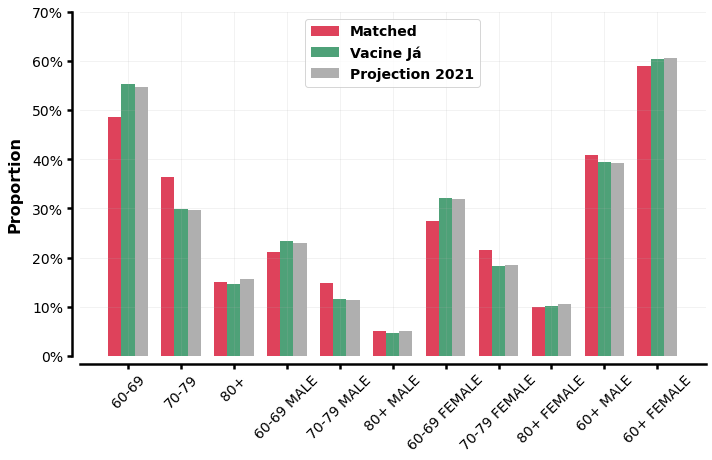

In [215]:
fig5, ax5_1 = plt.subplots(1, figsize=(10,6.5))
quant_df1 = quant_df.drop("TOTAL", axis=0)

labels = quant_df1.index
x = np.arange(len(labels))
width = 0.25

#"#84D288"
#ax5_1.bar(x - width, quant_df1["Matched (%)"], width, label="Matched", color='#4ea178')
ax5_1.bar(x - width, quant_df1["Matched (%)"], width, label="Matched", color='#de425b')
ax5_1.bar(x, quant_df1["Vacine Já (%)"], width, label="Vacine Já", color="#4ea178")
ax5_1.bar(x + width, quant_df1["Projected Population - 2021 (%)"], width, label="Projection 2021", color="#AFAFAF")

ax5_1.legend(prop={'size': 14, 'weight': 'bold'}, markerscale=6)
ax5_1.set_ylim([0,70])
ax5_1.grid(alpha=0.2)
for j in ["left", "right", "bottom", "top"]:
    ax5_1.spines[j].set_linewidth(2.5)
ax5_1.spines['top'].set_color('none')
ax5_1.spines['right'].set_color('none')
ax5_1.spines['left'].set_position(('outward', 8))
ax5_1.spines['bottom'].set_position(('outward', 8))
ax5_1.set_xticklabels(quant_df.drop("TOTAL", axis=0).reset_index()["index"], rotation=40)
ax5_1.tick_params(labelsize=12)
ax5_1.set_xlabel("")
ax5_1.set_ylabel("Proportion", fontsize=16, weight='bold', labelpad=10)
ax5_1.tick_params(labelsize=14, length=5, width=2.5)
ax5_1.set_xticklabels(labels, rotation=45)
ax5_1.set_xticks(x, rotation=25)
ax5_1.yaxis.set_major_formatter(ticker.PercentFormatter())

plt.tight_layout()

In [216]:
fig5.savefig(os.path.join(fig_folder, "DEMOGRAPHICS", f"FIG_5_1.svg"))
fig5.savefig(os.path.join(fig_folder, "DEMOGRAPHICS", f"FIG_5_1.png"), dpi=200, transparent=False, facecolor='white')
fig5.savefig(os.path.join(fig_folder, "DEMOGRAPHICS", f"FIG_5_1.pdf"))

## **COHORT DIAGRAM**

In [555]:
init_cohort = dt.datetime(2021, 1, 21)
fschema["IDADE_1"] = fschema["DATA NASCIMENTO"].apply(lambda x: relativedelta(init_cohort, x).year)

In [561]:
filter_pop = (fschema["IDADE"]>=60) & (fschema["TESTE POSITIVO ANTES COORTE"]==False) & ((fschema["OBITO ANTES COORTE"]==False)) & ((fschema["HOSPITALIZACAO ANTES COORTE"]==False))
sub_schema = fschema[filter_pop]

In [562]:
sub_schema.shape

(358140, 54)

In [551]:
print(f"Total population: {fschema.shape[0]:,}")
print(f"Total of eligible individuals: {df_eligible.shape[0]:,}")

Total population: 2,275,309
Total of eligible individuals: 324,302


In [583]:
groups_vac = df_eligible.groupby("VACINA APLICADA")["STATUS VACINACAO DURANTE COORTE"].value_counts()

corona_dict = groups_vac.loc['CORONAVAC'].to_dict()
astra_dict = groups_vac.loc['ASTRAZENECA'].to_dict()
pfizer_dict = groups_vac.loc['PFIZER'].to_dict()
janssen_dict = groups_vac.loc['JANSSEN'].to_dict()
unvac_dict = groups_vac.loc['NAO VACINADO'].to_dict()
print(astra_dict)
print(pfizer_dict)
print(janssen_dict)

print(f"CORONAVAC: {corona_dict['(D1)(D2)']+corona_dict['(D1)']}")
print(f"ASTRAZENECA: {astra_dict['(D1)(D2)']+astra_dict['(D1)']}")
print(f"PFIZER: {pfizer_dict['(D1)(D2)']+pfizer_dict['(D1)']}")
print(f"JANSSEN: {janssen_dict['(D4)']}")
print(f"NAO VACINADO: {unvac_dict['']}")

{'(D1)(D2)': 112069, '(D1)': 10684, '': 1290}
{'(D1)': 2807, '': 2386, '(D1)(D2)': 2281, '(D4)': 2}
{'(D4)': 468, '': 236}
CORONAVAC: 170385
ASTRAZENECA: 122753
PFIZER: 5088
JANSSEN: 468
NAO VACINADO: 18715


In [588]:
f"{(18715/147024)*100:.1f}"

'12.7'

## **FIGURE 6: KAPLAN-MEIER CURVES**

### **D2**

In [25]:
def pprint_km(pareamento_folder, vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, seed, strat=None, ylim=None):
    '''
    
    '''
    fig, ax = plt.subplots(1,figsize=(7,5))
    ax.tick_params(direction="out", width=1.5, length=4, top=False, right=False, labelsize=11)
    ax.set_xlim(0, 90)
    ax.set_xticks([0, 14, 28, 42, 56, 70, 84])
    ax.grid(alpha=0.2)
    
    
    event_hash = {
        "OBITO": "DEATH", "HOSPITAL": "HOSPITALIZATION", "UTI": "ADMISSION TO ICU",
    }
    
    #ax.text(-0.25, 1.2, f"Kaplan-Meier curves for dose {dose} ({vaccine}) - {event_hash[event]}", fontsize=13, weight="bold", transform=ax.transAxes)
    hdi_hash = {
        0: "[0.0-1.0]", 1: "[0.00-0.25-0.35-0.50-1.00]", 2: "[0.000-0.499-0.599-0.699-0.799-1.000]"
    }
    #ax.text(-0.25, 1.12, f"HDI stratification for matching: {hdi_hash[hdi_index]}", fontsize=11, transform=ax.transAxes)
    
    # --> KM DATA
    if strat is None:
        strat = "KM_DOSE"
    df = etc_utils.open_km(pareamento_folder, vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, seed, strat=f"{strat}")
    # --> Number of at risk and number of outcomes
    caso_risk_cumm = df["at_risk(caso)"]
    controle_risk_cumm = df["at_risk(controle)"]
    caso_outcome_cumm = df["observed(caso)"].cumsum()
    controle_outcome_cumm = df["observed(controle)"].cumsum()
    
    ax.text(-0.25, -0.16, "At risk", fontsize=11, weight="bold", transform=ax.transAxes)
    ax.text(-0.25, -0.22, "Unvaccinated", fontsize=11, transform=ax.transAxes)
    ax.text(-0.25, -0.27, "Vaccinated", fontsize=11, transform=ax.transAxes)
    
    ax.text(-0.25, -0.35, "Cumulative No. Outcomes", fontsize=11, weight="bold", transform=ax.transAxes)
    ax.text(-0.25, -0.41, "Unvaccinated", fontsize=11, transform=ax.transAxes)
    ax.text(-0.25, -0.46, "Vaccinated", fontsize=11, transform=ax.transAxes)
    
    start = -0.005
    step = 0.155
    for t in [0, 14, 28, 42, 56, 70, 84]:
        ax.text(start, -0.22, int(controle_risk_cumm.loc[t]),  transform=ax.transAxes)
        ax.text(start, -0.27, int(caso_risk_cumm.loc[t]),  transform=ax.transAxes)
        ax.text(start, -0.41, int(controle_outcome_cumm.loc[t]),  transform=ax.transAxes)
        ax.text(start, -0.46, int(caso_outcome_cumm.loc[t]),  transform=ax.transAxes)
        start += step
        
    for j in ['top', 'bottom', 'left', 'right']:
        ax.spines[j].set_linewidth(1.5)
    ax.spines["top"].set_linewidth(0)
    ax.spines["right"].set_linewidth(0)
    ax.spines["left"].set_position(("outward", 8))
    ax.spines["bottom"].set_position(("outward", 8))
    ax.set_xlabel("Days", weight="bold", fontsize=12)
    ax.set_ylabel("Cumulative Incidence \n(Kaplan-Meier)", weight="bold", fontsize=12)
    
    ax.axvline(14, 0, 2, color="#303030", lw=1.5, ls=":", alpha=0.8)
    ax.axvline(14, 0, 2, color="#303030", lw=1.5, ls=":", alpha=0.8)
    
    # Plot the Kaplan-Meier 
    df["KM(caso)"] = df["KM(caso)"]*100
    df["KM(controle)"] = df["KM(controle)"]*100
    df["KM_lower_0.95(caso)"] = df["KM_lower_0.95(caso)"]*100
    df["KM_upper_0.95(caso)"] = df["KM_upper_0.95(caso)"]*100
    df["KM_lower_0.95(controle)"] = df["KM_lower_0.95(controle)"]*100
    df["KM_upper_0.95(controle)"] = df["KM_upper_0.95(controle)"]*100
    sns.lineplot(x="t", y="KM(caso)", data=df, ax=ax, color="tab:blue", label="Vaccinated", lw=1.5)
    ax.fill_between(df["t"], df["KM_lower_0.95(caso)"], df["KM_upper_0.95(caso)"], color="tab:blue", alpha=0.2)
    sns.lineplot(x="t", y="KM(controle)", data=df, ax=ax, color="tab:orange", label="Unvaccinated", lw=1.5)
    ax.fill_between(df["t"], df["KM_lower_0.95(controle)"], df["KM_upper_0.95(controle)"], color="tab:orange", alpha=0.2)
    ax.legend(prop={'size':14}, loc=2, framealpha=1.0)
    if ylim is not None:
        ax.set_ylim(ylim)
    return fig

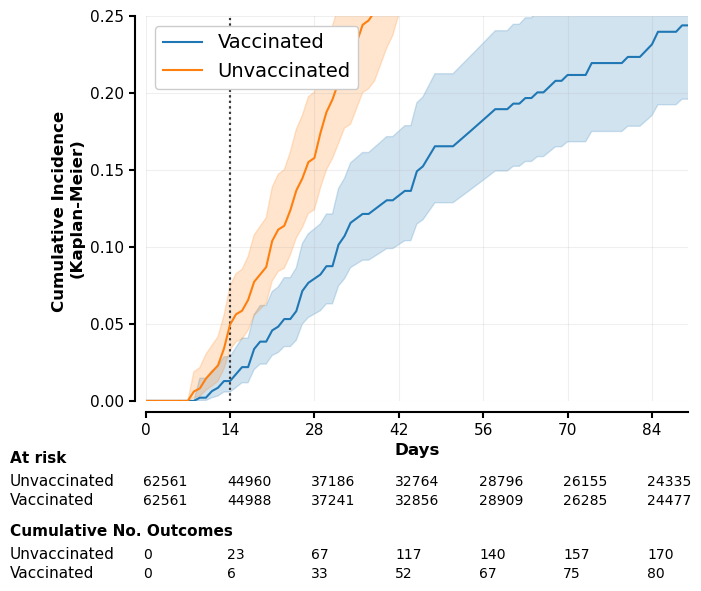

In [28]:
seed = 21
event = "HOSPITAL"
km_fig = pprint_km(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG", hdi_index=2, dose="D2", cohort_str="21JAN2021_31AUG2021", event=event, day_risk=7, seed=seed, strat="KM_DOSE", ylim=[0.0, 0.25])

In [100]:
km_fig.savefig(os.path.join(fig_folder, "KAPLAN_MEIER", f"KM_{event}_14_seed{seed}.svg"))
km_fig.savefig(os.path.join(fig_folder, "KAPLAN_MEIER", f"KM_{event}_14_seed{seed}.png"))
km_fig.savefig(os.path.join(fig_folder, "KAPLAN_MEIER", f"KM_{event}_14_seed{seed}.pdf"))

### **D1**

In [7]:
def pprint_km_d1(pareamento_folder, vaccine, test_prefix, hdi_index, cohort_str, event, day_risk, seed, strat=None, ylim=None):
    '''
    
    '''
    dose = "D1"
    fig, ax = plt.subplots(1,figsize=(7,5))
    ax.tick_params(direction="out", width=2., length=4, top=False, right=False, labelsize=11)
    ax.set_xlim(0, 30)
    ax.set_xticks([0, 7, 14, 21, 28])
    ax.grid(alpha=0.2)
    
    
    #ax.text(-0.25, 1.2, f"Kaplan-Meier curves for dose {dose} ({vaccine}) - {event}", fontsize=13, weight="bold", transform=ax.transAxes)
    hdi_hash = {
        0: "[0.0-1.0]", 1: "[0.00-0.25-0.35-0.50-1.00]", 2: "[0.000-0.499-0.599-0.699-0.799-1.000]"
    }
    #ax.text(-0.25, 1.12, f"HDI stratification for matching: {hdi_hash[hdi_index]}", fontsize=11, transform=ax.transAxes)
    
    # --> KM DATA
    if strat is None:
        strat = "KM_DOSE"
    df = etc_utils.open_km(pareamento_folder, vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, seed, strat=f"{strat}")
    # --> Number of at risk and number of outcomes
    caso_risk_cumm = df["at_risk(caso)"]
    controle_risk_cumm = df["at_risk(controle)"]
    caso_outcome_cumm = df["observed(caso)"].cumsum()
    controle_outcome_cumm = df["observed(controle)"].cumsum()
    
    ax.text(-0.25, -0.17, "At risk", fontsize=11, weight="bold", transform=ax.transAxes)
    ax.text(-0.25, -0.23, "Unvaccinated", fontsize=11, transform=ax.transAxes)
    ax.text(-0.25, -0.28, "Vaccinated", fontsize=11, transform=ax.transAxes)
    
    ax.text(-0.25, -0.36, "Cumulative No. Outcomes", fontsize=11, weight="bold", transform=ax.transAxes)
    ax.text(-0.25, -0.42, "Unvaccinated", fontsize=11, transform=ax.transAxes)
    ax.text(-0.25, -0.47, "Vaccinated", fontsize=11, transform=ax.transAxes)
    
    start = -0.005
    step = 0.231
    for t in [0, 7, 14, 21, 28]:
        ax.text(start, -0.23, int(controle_risk_cumm.loc[t]),  transform=ax.transAxes)
        ax.text(start, -0.28, int(caso_risk_cumm.loc[t]),  transform=ax.transAxes)
        ax.text(start, -0.42, int(controle_outcome_cumm.loc[t]),  transform=ax.transAxes)
        ax.text(start, -0.47, int(caso_outcome_cumm.loc[t]),  transform=ax.transAxes)
        start += step
        
    for j in ['top', 'bottom', 'left', 'right']:
        ax.spines[j].set_linewidth(2.)
    ax.spines["top"].set_linewidth(0)
    ax.spines["right"].set_linewidth(0)
    ax.spines["left"].set_position(("outward", 8))
    ax.spines["bottom"].set_position(("outward", 8))
    ax.set_xlabel("Days", weight="bold", fontsize=12)
    ax.set_ylabel("Cumulative Incidence \n(Kaplan-Meier)", weight="bold", fontsize=12)
        
    # Plot the Kaplan-Meier 
    sns.lineplot(x="t", y="KM(caso)", data=df, ax=ax, color="tab:blue", label="Vaccinated", lw=1.5)
    ax.fill_between(df["t"], df["KM_lower_0.95(caso)"], df["KM_upper_0.95(caso)"], color="tab:blue", alpha=0.2)
    sns.lineplot(x="t", y="KM(controle)", data=df, ax=ax, color="tab:orange", label="Unvaccinated", lw=1.5)
    ax.fill_between(df["t"], df["KM_lower_0.95(controle)"], df["KM_upper_0.95(controle)"], color="tab:orange", alpha=0.2)
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.legend(prop={'size':14}, loc=2)
    return fig

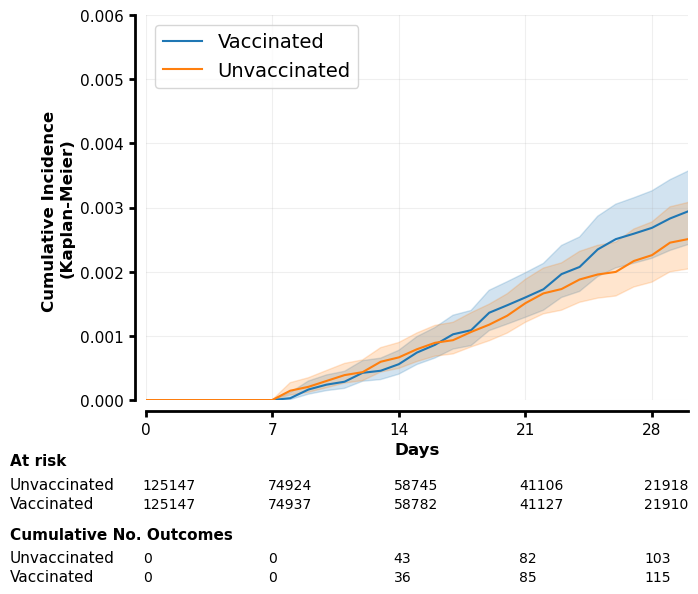

In [16]:
seed = 10
event = "HOSPITAL"
km_fig = pprint_km_d1(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG", hdi_index=2, cohort_str="21JAN2021_31AUG2021", event=event, day_risk=7, seed=seed, strat="KM_DOSE", ylim=[0.0,0.006])

In [321]:
km_fig.savefig(os.path.join(fig_folder, "FIG6", f"FIG_6_D1_{event}_7_seed{seed}.svg"))
km_fig.savefig(os.path.join(fig_folder, "FIG6", f"FIG_6_D1_{event}_7_seed{seed}.png"))
km_fig.savefig(os.path.join(fig_folder, "FIG6", f"FIG_6_D1_{event}_7_seed{seed}.pdf"))

## **FIGURE 7: VE SINGLE DOSE 0-13**

In [12]:
def risk_ratio_d1(seeds, event, days_risk):
    '''
    
    '''
    period = []
    for seed in seeds:
        km_event = etc_utils.open_km(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG", 2, "D1", "21JAN2021_31AUG2021", event, days_risk, seed)
        temp_df = km_event["KM_DOSE"].set_index("t").loc[0:20]
        period.append((temp_df["KM(caso)"]*1000)/(temp_df["KM(controle)"]*1000))
    simul_rr = pd.concat(period, axis=1)
    mean = simul_rr.mean(axis=1)
    std = simul_rr.std(axis=1)
    simul_rr["mean"] = mean
    simul_rr["std"] = std
    return simul_rr

In [13]:
seeds = np.arange(1,31,1)
simul_hospital = risk_ratio_d1(seeds, "HOSPITAL", 7)
#simul_uti = risk_ratio_d1(seeds, "UTI")
#simul_obito = risk_ratio_d1(seeds, "OBITO")

In [14]:
simul_hospital

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,mean,std
t,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.124982,0.374923,0.222177,0.249967,0.333255,0.249945,0.499905,0.399936,0.333285,0.199959,...,0.399930,0.142828,0.285647,0.374956,0.428471,0.249956,0.428490,0.249963,0.289362,0.134036


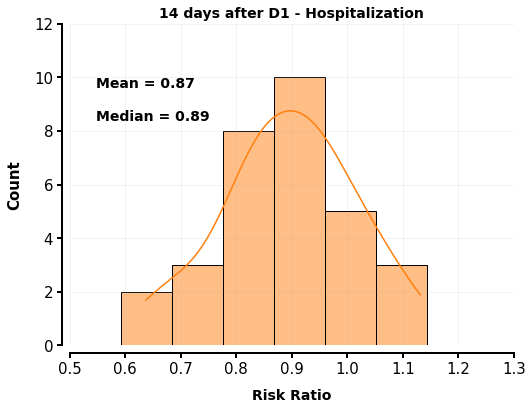

In [225]:
fig_7, ax7_1 = plt.subplots(1,1, figsize=(7.5,5.8))
day = 15
sns.histplot(data=simul_hospital.loc[day].array[:31], bins=np.arange(0.5, 1.6, 0.092), color="tab:orange", ax=ax7_1, kde=True)

for axis in [ax7_1]:
    axis.grid(alpha=0.2)
    axis.spines["top"].set_linewidth(0)
    axis.spines["right"].set_linewidth(0)
    axis.spines["left"].set_linewidth(2)
    axis.spines["bottom"].set_linewidth(2)
    axis.spines['left'].set_position(('outward', 8))
    axis.spines['bottom'].set_position(('outward',8))
    axis.tick_params(labelsize=15, width=2, length=5)
    #axis.set_xlim([0,1])
    axis.set_xlabel("Risk Ratio", weight='bold', fontsize=14, labelpad=12)
    axis.yaxis.set_major_locator(MaxNLocator(integer=True))
    
ax7_1.set_title("14 days after D1 - Hospitalization", fontsize=14, weight='bold')
ax7_1.set_ylabel("Count", fontsize=15, weight='bold', labelpad=12)
ax7_1.set_xlim([0.5, 1.3])
ax7_1.set_ylim([0, 12])

# --> Mean and Median
mean_1 = np.mean(simul_hospital.loc[day].array[:10])
median_1 = np.median(simul_hospital.loc[day].array[:10])
ax7_1.text(0.06, 0.8, f"Mean = {mean_1:.2f}", weight='bold', fontsize=14, transform=ax7_1.transAxes)
ax7_1.text(0.06, 0.7, f"Median = {median_1:.2f}", weight='bold', fontsize=14, transform=ax7_1.transAxes)
plt.tight_layout()

In [226]:
fig_7.savefig(os.path.join(fig_folder, "DIVERGENCE_D1", "divergence_d1_dayrisk7.svg"))
fig_7.savefig(os.path.join(fig_folder, "DIVERGENCE_D1", "divergence_d1_dayrisk7.png"), dpi=200, transparent=False, facecolor='white')
#fig_7.savefig(os.path.join(fig_folder, "DIVERGENCE_D1", "divergence_d1_dayrisk7.jpg"), dpi=200)
fig_7.savefig(os.path.join(fig_folder, "DIVERGENCE_D1", "divergence_d1_dayrisk7.pdf"))

## **FIGURE 8: VE DISTRIBUTION**

In [227]:
ve_matrix_hospital = etc_utils.ve_mean(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG", 2, "D2", "21JAN2021_31AUG2021", "HOSPITAL", 14, seeds=np.arange(1,31,1))
ve_matrix_uti = etc_utils.ve_mean(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG", 2, "D2", "21JAN2021_31AUG2021", "UTI", 14, seeds=np.arange(1,31,1))
ve_matrix_death = etc_utils.ve_mean(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG", 2, "D2", "21JAN2021_31AUG2021", "OBITO", 14, seeds=np.arange(1,31,1))

0.5255242637589299
0.5638991777860581
0.8138239556846764


### V1

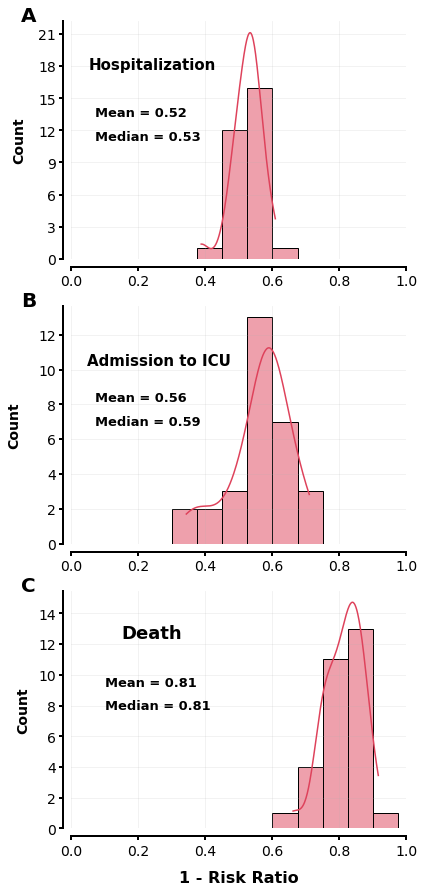

In [260]:
#fig_x, (ax1_x, ax2_x, ax3_x) = plt.subplots(1,3, figsize=(14,4.5), sharey=True)
#ax1_x.set_ylabel("Count", fontsize=14, weight='bold')
# -- fig form
fig_x, (ax1_x, ax2_x, ax3_x) = plt.subplots(3,1, figsize=(6,12.5))
ax1_x.set_ylabel("Count", fontsize=14, weight='bold', labelpad=12)
ax2_x.set_ylabel("Count", fontsize=14, weight='bold', labelpad=17)
ax3_x.set_ylabel("Count", fontsize=14, weight='bold', labelpad=8)

sns.histplot(data=ve_matrix_hospital.loc[90].array[1:31], bins=np.arange(0,1,0.075), color="#de425b", ax=ax1_x, kde=True)
sns.histplot(data=ve_matrix_uti.loc[90].array[1:31], bins=np.arange(0,1,0.075), color='#de425b', ax=ax2_x, kde=True)
sns.histplot(data=ve_matrix_death.loc[90].array[1:31], bins=np.arange(0,1,0.075), color='#de425b', ax=ax3_x, kde=True)

for axis in [ax1_x, ax2_x, ax3_x]:
    axis.grid(alpha=0.2)
    axis.spines["top"].set_linewidth(0)
    axis.spines["right"].set_linewidth(0)
    axis.spines["left"].set_linewidth(2)
    axis.spines["bottom"].set_linewidth(2)
    axis.spines['left'].set_position(('outward', 8))
    axis.spines['bottom'].set_position(('outward',8))
    axis.tick_params(labelsize=14, width=2, length=4)
    axis.set_xlim([0,1])
    axis.set_xlabel("1 - Risk Ratio", weight='bold', fontsize=16, labelpad=12)
    axis.yaxis.set_major_locator(MaxNLocator(integer=True))
    
#ax1_x.set_title("Hospitalization", fontsize=14, weight='bold')
ax1_x.set_xlabel("")
#ax2_x.set_title("Admission to ICU", fontsize=14, weight='bold')
ax2_x.set_xlabel("")
#ax3_x.set_title("Death", fontsize=14, weight='bold')

# --> Mean and Median
mean_1 = np.mean(ve_matrix_hospital.loc[90].array[1:22])
mean_2 = np.mean(ve_matrix_uti.loc[90].array[1:22])
mean_3 = np.mean(ve_matrix_death.loc[90].array[1:22])
median_1 = np.median(ve_matrix_hospital.loc[90].array[1:22])
median_2 = np.median(ve_matrix_uti.loc[90].array[1:22])
median_3 = np.median(ve_matrix_death.loc[90].array[1:22])

ax1_x.text(0.05, 0.8, f"Hospitalization", weight='bold', fontsize=15, transform=ax1_x.transAxes)
ax2_x.text(0.045, 0.75, f"Admission to ICU", weight='bold', fontsize=15, transform=ax2_x.transAxes)
ax3_x.text(0.15, 0.8, f"Death", weight='bold', fontsize=18, transform=ax3_x.transAxes)
# --
ax1_x.text(-0.15, 1.0, f"A", weight='bold', fontsize=20, transform=ax1_x.transAxes)
ax1_x.text(0.07, 0.6, f"Mean = {mean_1:.2f}", weight='bold', fontsize=13, transform=ax1_x.transAxes)
ax2_x.text(0.07, 0.6, f"Mean = {mean_2:.2f}", weight='bold', fontsize=13, transform=ax2_x.transAxes)
ax2_x.text(-0.15, 1.0, f"B", weight='bold', fontsize=20, transform=ax2_x.transAxes)
ax3_x.text(0.1, 0.6, f"Mean = {mean_3:.2f}", weight='bold', fontsize=13, transform=ax3_x.transAxes)
ax3_x.text(-0.15, 1.0, f"C", weight='bold', fontsize=20, transform=ax3_x.transAxes)
# --
ax1_x.text(0.07, 0.5, f"Median = {median_1:.2f}", weight='bold', fontsize=13, transform=ax1_x.transAxes)
ax2_x.text(0.07, 0.5, f"Median = {median_2:.2f}", weight='bold', fontsize=13, transform=ax2_x.transAxes)
ax3_x.text(0.1, 0.5, f"Median = {median_3:.2f}", weight='bold', fontsize=13, transform=ax3_x.transAxes)

#ax1_x.set_ylim([0, 16])
#ax1_x.set_yticks([0,4,8,12,16])
#ax2_x.set_ylim([0, 8])
#ax2_x.set_yticks([0,2,4,6,8])
#ax3_x.set_ylim([0, 10])
#ax3_x.set_yticks([0,2,4,6,8,10])

plt.tight_layout()
plt.subplots_adjust(hspace=0.2)

### V2

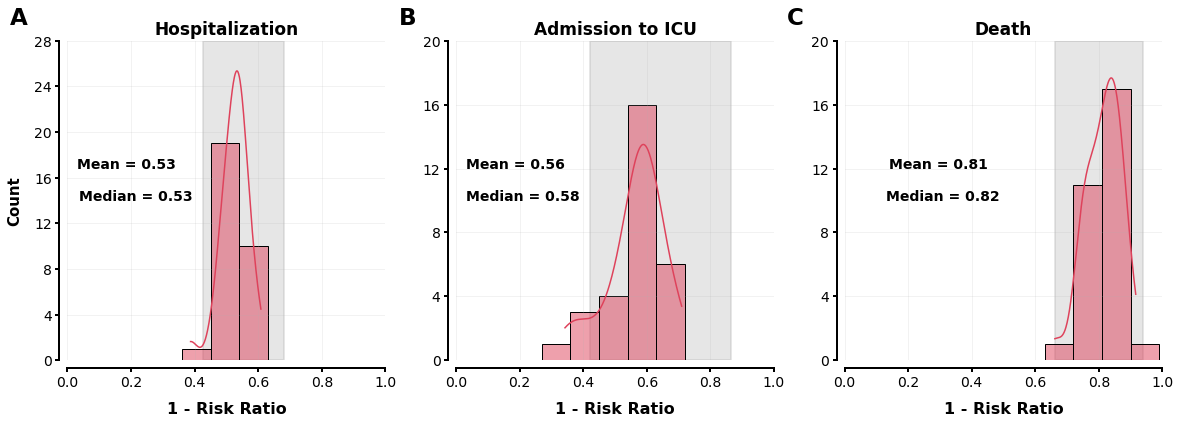

In [347]:
# -- fig form
fig_x, (ax1_x, ax2_x, ax3_x) = plt.subplots(1,3, figsize=(16.5,6.))
ax1_x.set_ylabel("Count", fontsize=15, weight='bold', labelpad=12)
#ax2_x.set_ylabel("Count", fontsize=14, weight='bold', labelpad=17)
#ax3_x.set_ylabel("Count", fontsize=14, weight='bold', labelpad=8)

ax1_x.axvspan(0.427, 0.681, alpha=.3, color="#afafaf", lw=2, edgecolor="#4d4d4d")
ax2_x.axvspan(0.423, 0.864, alpha=.3, color="#afafaf", lw=2, edgecolor="#4d4d4d")
ax3_x.axvspan(0.663, 0.939, alpha=.3, color="#afafaf", lw=2, edgecolor="#4d4d4d")
#42.3-86.4
#66.3-93.9

sns.histplot(data=ve_matrix_hospital.loc[90].array[1:31], bins=np.arange(0,1,0.09), color="#de425b", ax=ax1_x, kde=True)
sns.histplot(data=ve_matrix_uti.loc[90].array[1:31], bins=np.arange(0,1,0.09), color='#de425b', ax=ax2_x, kde=True)
sns.histplot(data=ve_matrix_death.loc[90].array[1:31], bins=np.arange(0,1,0.09), color='#de425b', ax=ax3_x, kde=True)

for axis in [ax1_x, ax2_x, ax3_x]:
    axis.grid(alpha=0.2)
    axis.spines["top"].set_linewidth(0)
    axis.spines["right"].set_linewidth(0)
    axis.spines["left"].set_linewidth(2)
    axis.spines["bottom"].set_linewidth(2)
    axis.spines['left'].set_position(('outward', 8))
    axis.spines['bottom'].set_position(('outward',8))
    axis.tick_params(labelsize=14, width=2, length=4)
    axis.set_xlim([0,1])
    axis.set_xlabel("1 - Risk Ratio", weight='bold', fontsize=16, labelpad=12)
    axis.yaxis.set_major_locator(MaxNLocator(integer=True))
    
ax1_x.set_title("Hospitalization", fontsize=17, weight='bold')
ax2_x.set_ylabel("")
ax2_x.set_title("Admission to ICU", fontsize=17, weight='bold')
ax3_x.set_ylabel("")
ax3_x.set_title("Death", fontsize=17, weight='bold')

# --> Mean and Median
mean_1 = np.mean(ve_matrix_hospital.loc[90].array[1:31])
mean_2 = np.mean(ve_matrix_uti.loc[90].array[1:31])
mean_3 = np.mean(ve_matrix_death.loc[90].array[1:31])
median_1 = np.median(ve_matrix_hospital.loc[90].array[1:31])
median_2 = np.median(ve_matrix_uti.loc[90].array[1:31])
median_3 = np.median(ve_matrix_death.loc[90].array[1:31])

#ax1_x.text(0.05, 0.8, f"Hospitalization", weight='bold', fontsize=15, transform=ax1_x.transAxes)
#ax2_x.text(0.045, 0.75, f"Admission to ICU", weight='bold', fontsize=15, transform=ax2_x.transAxes)
#ax3_x.text(0.15, 0.8, f"Death", weight='bold', fontsize=18, transform=ax3_x.transAxes)
# --
ax1_x.text(-0.18, 1.05, f"A", weight='bold', fontsize=23, transform=ax1_x.transAxes)
ax1_x.text(0.03, 0.6, f"Mean = {mean_1:.2f}", weight='bold', fontsize=14, transform=ax1_x.transAxes)
ax2_x.text(0.03, 0.6, f"Mean = {mean_2:.2f}", weight='bold', fontsize=14, transform=ax2_x.transAxes)
ax2_x.text(-0.18, 1.05, f"B", weight='bold', fontsize=23, transform=ax2_x.transAxes)
ax3_x.text(0.14, 0.6, f"Mean = {mean_3:.2f}", weight='bold', fontsize=14, transform=ax3_x.transAxes)
ax3_x.text(-0.18, 1.05, f"C", weight='bold', fontsize=23, transform=ax3_x.transAxes)
# --
ax1_x.text(0.035, 0.5, f"Median = {median_1:.2f}", weight='bold', fontsize=14, transform=ax1_x.transAxes)
ax2_x.text(0.03, 0.5, f"Median = {median_2:.2f}", weight='bold', fontsize=14, transform=ax2_x.transAxes)
ax3_x.text(0.13, 0.5, f"Median = {median_3:.2f}", weight='bold', fontsize=14, transform=ax3_x.transAxes)

ax1_x.set_ylim([0, 28])
ax1_x.set_yticks([0,4,8,12,16,20,24, 28])
ax2_x.set_ylim([0, 20])
ax2_x.set_yticks([0,4,8,12,16, 20])
ax3_x.set_ylim([0, 20])
ax3_x.set_yticks([0,4,8,12,16, 20])

plt.tight_layout()

In [348]:
fig_x.savefig(os.path.join(fig_folder, "DISTRIBUTION_VE", "VEDIST_dayrisk14_V3.svg"))
fig_x.savefig(os.path.join(fig_folder, "DISTRIBUTION_VE", "VEDIST_dayrisk14_V3.png"), dpi=200, transparent=False, facecolor='white')
fig_x.savefig(os.path.join(fig_folder, "DISTRIBUTION_VE", "VEDIST_dayrisk14_V3.jpg"))
fig_x.savefig(os.path.join(fig_folder, "DISTRIBUTION_VE", "VEDIST_dayrisk14_V3.pdf"))

### V2 - SEX

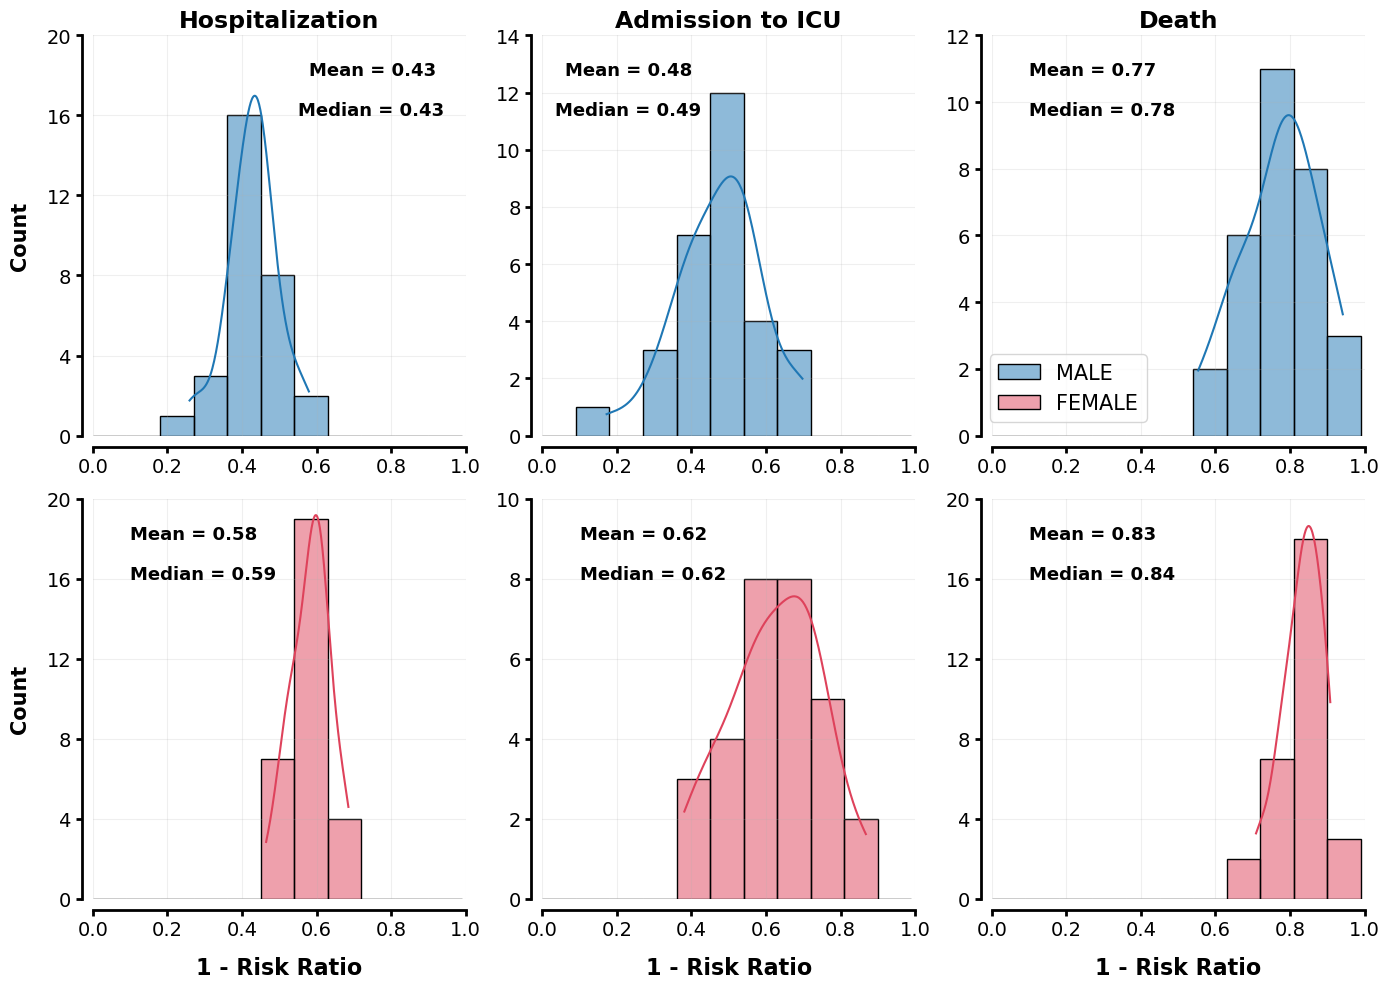

In [121]:
# -- fig form
fig_sex, AX_x = plt.subplots(2,3, figsize=(14.,10.))
AX_x[0,0].set_ylabel("Count", fontsize=15, weight='bold', labelpad=12)
AX_x[1,0].set_ylabel("Count", fontsize=15, weight='bold', labelpad=12)
#ax2_x.set_ylabel("Count", fontsize=14, weight='bold', labelpad=17)
#ax3_x.set_ylabel("Count", fontsize=14, weight='bold', labelpad=8)

#ax1_x.axvspan(0.427, 0.681, alpha=.3, color="#afafaf", lw=2, edgecolor="#4d4d4d")
#ax2_x.axvspan(0.423, 0.864, alpha=.3, color="#afafaf", lw=2, edgecolor="#4d4d4d")
#ax3_x.axvspan(0.663, 0.939, alpha=.3, color="#afafaf", lw=2, edgecolor="#4d4d4d")
#42.3-86.4
#66.3-93.9

sns.histplot(data=ve_matrix_hospital_male.loc[90].array[1:31], bins=np.arange(0,1,0.09), color="tab:blue", ax=AX_x[0,0], kde=True, label="MALE")
sns.histplot(data=ve_matrix_uti_male.loc[90].array[1:31], bins=np.arange(0,1,0.09), color='tab:blue', ax=AX_x[0,1], kde=True)
sns.histplot(data=ve_matrix_death_male.loc[90].array[1:31], bins=np.arange(0,1,0.09), color='tab:blue', ax=AX_x[0,2], kde=True)

sns.histplot(data=ve_matrix_hospital_female.loc[90].array[1:31], bins=np.arange(0,1,0.09), color="#de425b", ax=AX_x[1,0], kde=True)
sns.histplot(data=ve_matrix_uti_female.loc[90].array[1:31], bins=np.arange(0,1,0.09), color='#de425b', ax=AX_x[1,1], kde=True)
sns.histplot(data=ve_matrix_death_female.loc[90].array[1:31], bins=np.arange(0,1,0.09), color='#de425b', ax=AX_x[1,2], kde=True, label="FEMALE")

for axis in [AX_x[0, 0], AX_x[0, 1], AX_x[0, 2], AX_x[1, 0], AX_x[1, 1], AX_x[1, 2]]:
    axis.grid(alpha=0.2)
    axis.spines["top"].set_linewidth(0)
    axis.spines["right"].set_linewidth(0)
    axis.spines["left"].set_linewidth(2)
    axis.spines["bottom"].set_linewidth(2)
    axis.spines['left'].set_position(('outward', 8))
    axis.spines['bottom'].set_position(('outward',8))
    axis.tick_params(labelsize=14, width=2, length=4)
    axis.set_xlim([0,1])
    axis.set_xlabel("1 - Risk Ratio", weight='bold', fontsize=16, labelpad=12)
    axis.yaxis.set_major_locator(MaxNLocator(integer=True))
    
for axis in [AX_x[0,0], AX_x[0,1], AX_x[0,2]]:
    axis.set_xlabel("")
fig_sex.legend(prop={'size':15}, edgecolor=None, bbox_to_anchor=(0.83,0.65))
    
AX_x[0,0].set_title("Hospitalization", fontsize=17, weight='bold')
AX_x[0,1].set_ylabel("")
AX_x[1,1].set_ylabel("")
AX_x[0,1].set_title("Admission to ICU", fontsize=17, weight='bold')
AX_x[0,2].set_ylabel("")
AX_x[1,2].set_ylabel("")
AX_x[0,2].set_title("Death", fontsize=17, weight='bold')

# --> Mean and Median
#mean_1 = np.mean(ve_matrix_hospital_male.loc[90].array[1:31])
#mean_2 = np.mean(ve_matrix_uti_male.loc[90].array[1:31])
#mean_3 = np.mean(ve_matrix_death_male.loc[90].array[1:31])
mmedian_1 = np.median(ve_matrix_hospital_male.loc[90].array[1:31])
mmedian_2 = np.median(ve_matrix_uti_male.loc[90].array[1:31])
mmedian_3 = np.median(ve_matrix_death_male.loc[90].array[1:31])
fmedian_1 = np.median(ve_matrix_hospital_female.loc[90].array[1:31])
fmedian_2 = np.median(ve_matrix_uti_female.loc[90].array[1:31])
fmedian_3 = np.median(ve_matrix_death_female.loc[90].array[1:31])

mmean_1 = np.mean(ve_matrix_hospital_male.loc[90].array[1:31])
mmean_2 = np.mean(ve_matrix_uti_male.loc[90].array[1:31])
mmean_3 = np.mean(ve_matrix_death_male.loc[90].array[1:31])
fmean_1 = np.mean(ve_matrix_hospital_female.loc[90].array[1:31])
fmean_2 = np.mean(ve_matrix_uti_female.loc[90].array[1:31])
fmean_3 = np.mean(ve_matrix_death_female.loc[90].array[1:31])

#ax1_x.text(0.05, 0.8, f"Hospitalization", weight='bold', fontsize=15, transform=ax1_x.transAxes)
#ax2_x.text(0.045, 0.75, f"Admission to ICU", weight='bold', fontsize=15, transform=ax2_x.transAxes)
#ax3_x.text(0.15, 0.8, f"Death", weight='bold', fontsize=18, transform=ax3_x.transAxes)
# --
#ax1_x.text(-0.18, 1.05, f"A", weight='bold', fontsize=23, transform=ax1_x.transAxes)
#ax1_x.text(0.03, 0.6, f"Mean = {mean_1:.2f}", weight='bold', fontsize=14, transform=ax1_x.transAxes)
#ax2_x.text(0.03, 0.6, f"Mean = {mean_2:.2f}", weight='bold', fontsize=14, transform=ax2_x.transAxes)
#ax2_x.text(-0.18, 1.05, f"B", weight='bold', fontsize=23, transform=ax2_x.transAxes)
#ax3_x.text(0.14, 0.6, f"Mean = {mean_3:.2f}", weight='bold', fontsize=14, transform=ax3_x.transAxes)
#ax3_x.text(-0.18, 1.05, f"C", weight='bold', fontsize=23, transform=ax3_x.transAxes)
# --
AX_x[0,0].text(0.55, 0.8, f"Median = {mmedian_1:.2f}", weight='bold', fontsize=13, transform=AX_x[0,0].transAxes)
AX_x[0,1].text(0.035, 0.8, f"Median = {mmedian_2:.2f}", weight='bold', fontsize=13, transform=AX_x[0,1].transAxes)
AX_x[0,2].text(0.1, 0.8, f"Median = {mmedian_3:.2f}", weight='bold', fontsize=13, transform=AX_x[0,2].transAxes)

AX_x[1,0].text(0.1, 0.8, f"Median = {fmedian_1:.2f}", weight='bold', fontsize=13, transform=AX_x[1,0].transAxes)
AX_x[1,1].text(0.1, 0.8, f"Median = {fmedian_2:.2f}", weight='bold', fontsize=13, transform=AX_x[1,1].transAxes)
AX_x[1,2].text(0.1, 0.8, f"Median = {fmedian_3:.2f}", weight='bold', fontsize=13, transform=AX_x[1,2].transAxes)

AX_x[0,0].text(0.58, 0.9, f"Mean = {mmean_1:.2f}", weight='bold', fontsize=13, transform=AX_x[0,0].transAxes)
AX_x[0,1].text(0.06, 0.9, f"Mean = {mmean_2:.2f}", weight='bold', fontsize=13, transform=AX_x[0,1].transAxes)
AX_x[0,2].text(0.1, 0.9, f"Mean = {mmean_3:.2f}", weight='bold', fontsize=13, transform=AX_x[0,2].transAxes)

AX_x[1,0].text(0.1, 0.9, f"Mean = {fmean_1:.2f}", weight='bold', fontsize=13, transform=AX_x[1,0].transAxes)
AX_x[1,1].text(0.1, 0.9, f"Mean = {fmean_2:.2f}", weight='bold', fontsize=13, transform=AX_x[1,1].transAxes)
AX_x[1,2].text(0.1, 0.9, f"Mean = {fmean_3:.2f}", weight='bold', fontsize=13, transform=AX_x[1,2].transAxes)

AX_x[0,0].set_ylim([0, 20])
AX_x[0,0].set_yticks([0,4,8,12,16,20])
AX_x[0,1].set_ylim([0, 14])
AX_x[0,1].set_yticks([0,2,4,6,8,10,12,14])
AX_x[0,2].set_ylim([0, 12])
AX_x[0,2].set_yticks([0,2,4,6,8,10,12])

AX_x[1,0].set_ylim([0, 20])
AX_x[1,0].set_yticks([0,4,8,12,16,20])
AX_x[1,1].set_ylim([0, 10])
AX_x[1,1].set_yticks([0,2,4,6,8,10])
AX_x[1,2].set_ylim([0, 20])
AX_x[1,2].set_yticks([0,4,8,12,16,20])

plt.tight_layout()

In [76]:
fig_sex.savefig(os.path.join(fig_folder, "DISTRIBUTION_VE", "VEDIST_SEX_dayrisk14_V3.svg"))
fig_sex.savefig(os.path.join(fig_folder, "DISTRIBUTION_VE", "VEDIST_SEX_dayrisk14_V3.png"), dpi=200, transparent=False, facecolor='white', bbox_inches="tight")
fig_sex.savefig(os.path.join(fig_folder, "DISTRIBUTION_VE", "VEDIST_SEX_dayrisk14_V3.jpg"))
fig_sex.savefig(os.path.join(fig_folder, "DISTRIBUTION_VE", "VEDIST_SEX_dayrisk14_V3.pdf"))

### V2 - AGE

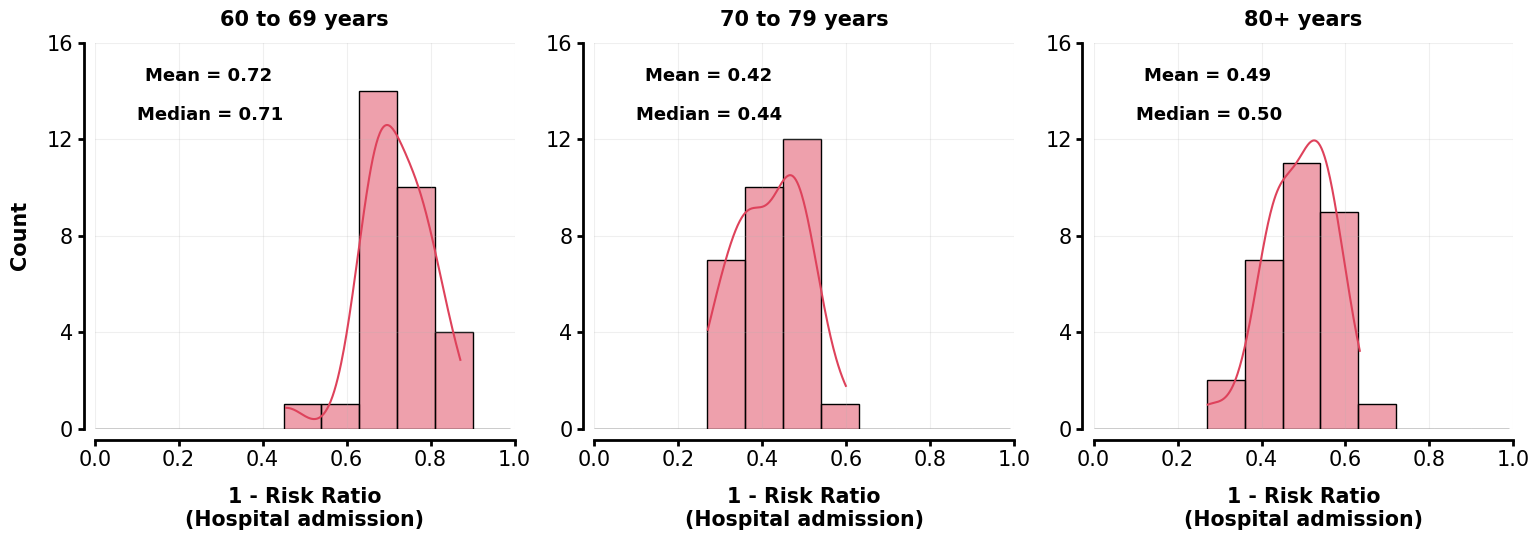

In [109]:
# -- fig form
fig_age, (a1, a2, a3) = plt.subplots(1,3, figsize=(15.5,5.5))
a1.set_ylabel("Count", fontsize=15, weight='bold', labelpad=12)
#AX_x[1,0].set_ylabel("Count", fontsize=15, weight='bold', labelpad=12)
#AX_x[2,0].set_ylabel("Count", fontsize=15, weight='bold', labelpad=12)
#ax2_x.set_ylabel("Count", fontsize=14, weight='bold', labelpad=17)
#ax3_x.set_ylabel("Count", fontsize=14, weight='bold', labelpad=8)

#ax1_x.axvspan(0.427, 0.681, alpha=.3, color="#afafaf", lw=2, edgecolor="#4d4d4d")
#ax2_x.axvspan(0.423, 0.864, alpha=.3, color="#afafaf", lw=2, edgecolor="#4d4d4d")
#ax3_x.axvspan(0.663, 0.939, alpha=.3, color="#afafaf", lw=2, edgecolor="#4d4d4d")
#42.3-86.4
#66.3-93.9

sns.histplot(data=ve_matrix_hospital_6069.loc[90].array[1:31], bins=np.arange(0,1,0.09), color="#de425b", ax=a1, kde=True, label="60-69")
#sns.histplot(data=ve_matrix_uti_6069.loc[90].array[1:31], bins=np.arange(0,1,0.09), color='tab:blue', ax=AX_x[0,1], kde=True)
#sns.histplot(data=ve_matrix_death_6069.loc[90].array[1:31], bins=np.arange(0,1,0.09), color='tab:blue', ax=AX_x[0,2], kde=True)

sns.histplot(data=ve_matrix_hospital_7079.loc[90].array[1:31], bins=np.arange(0,1,0.09), color="#de425b", ax=a2, kde=True)
#sns.histplot(data=ve_matrix_uti_7079.loc[90].array[1:31], bins=np.arange(0,1,0.09), color='#de425b', ax=AX_x[1,1], kde=True)
#sns.histplot(data=ve_matrix_death_7079.loc[90].array[1:31], bins=np.arange(0,1,0.09), color='#de425b', ax=AX_x[1,2], kde=True, label="70-79")

sns.histplot(data=ve_matrix_hospital_80p.loc[90].array[1:31], bins=np.arange(0,1,0.09), color="#de425b", ax=a3, kde=True )
#sns.histplot(data=ve_matrix_uti_80p.loc[90].array[1:31], bins=np.arange(0,1,0.09), color='#de425b', ax=AX_x[2,1], kde=True)
#sns.histplot(data=ve_matrix_death_80p.loc[90].array[1:31], bins=np.arange(0,1,0.09), color='#de425b', ax=AX_x[2,2], kde=True, label="80+")

for axis in [a1,a2,a3]:
    axis.grid(alpha=0.2)
    axis.spines["top"].set_linewidth(0)
    axis.spines["right"].set_linewidth(0)
    axis.spines["left"].set_linewidth(2)
    axis.spines["bottom"].set_linewidth(2)
    axis.spines['left'].set_position(('outward', 8))
    axis.spines['bottom'].set_position(('outward',8))
    axis.tick_params(labelsize=15, width=2, length=4)
    axis.set_xlim([0,1])
    axis.set_xlabel("1 - Risk Ratio\n(Hospital admission)", weight='bold', fontsize=14.75, labelpad=12)
    axis.yaxis.set_major_locator(MaxNLocator(integer=True))
    
#for axis in [AX_x[0,0], AX_x[0,1], AX_x[0,2], AX_x[1, 0], AX_x[1, 1], AX_x[1, 2]]:
#    axis.set_xlabel("")
#fig_sex.legend(prop={'size':15}, edgecolor=None, bbox_to_anchor=(0.83,0.65))
    
#AX_x[0,0].set_title("Hospitalization", fontsize=17, weight='bold')
a1.set_title("60 to 69 years", pad=12, fontsize=15, weight='bold')
a2.set_title("70 to 79 years", pad=12, fontsize=15, weight='bold')
a3.set_title("80+ years", pad=12, fontsize=15, weight='bold')

a2.set_ylabel("")
a3.set_ylabel("")
#AX_x[1,1].set_ylabel("")
#AX_x[0,1].set_title("Admission to ICU", fontsize=17, weight='bold')
#AX_x[0,2].set_ylabel("")
#AX_x[1,2].set_ylabel("")
#AX_x[0,2].set_title("Death", fontsize=17, weight='bold')

# --> Mean and Median
#mean_1 = np.mean(ve_matrix_hospital_male.loc[90].array[1:31])
#mean_2 = np.mean(ve_matrix_uti_male.loc[90].array[1:31])
#mean_3 = np.mean(ve_matrix_death_male.loc[90].array[1:31])
median_6069 = np.median(ve_matrix_hospital_6069.loc[90].array[1:31])
median_7079 = np.median(ve_matrix_hospital_7079.loc[90].array[1:31])
median_80p = np.median(ve_matrix_hospital_80p.loc[90].array[1:31])
mean_6069 = np.mean(ve_matrix_hospital_6069.loc[90].array[1:31])
mean_7079 = np.mean(ve_matrix_hospital_7079.loc[90].array[1:31])
mean_80p = np.mean(ve_matrix_hospital_80p.loc[90].array[1:31])


#ax1_x.text(0.05, 0.8, f"Hospitalization", weight='bold', fontsize=15, transform=ax1_x.transAxes)
#ax2_x.text(0.045, 0.75, f"Admission to ICU", weight='bold', fontsize=15, transform=ax2_x.transAxes)
#ax3_x.text(0.15, 0.8, f"Death", weight='bold', fontsize=18, transform=ax3_x.transAxes)
# --
#ax1_x.text(-0.18, 1.05, f"A", weight='bold', fontsize=23, transform=ax1_x.transAxes)
#ax1_x.text(0.03, 0.6, f"Mean = {mean_1:.2f}", weight='bold', fontsize=14, transform=ax1_x.transAxes)
#ax2_x.text(0.03, 0.6, f"Mean = {mean_2:.2f}", weight='bold', fontsize=14, transform=ax2_x.transAxes)
#ax2_x.text(-0.18, 1.05, f"B", weight='bold', fontsize=23, transform=ax2_x.transAxes)
#ax3_x.text(0.14, 0.6, f"Mean = {mean_3:.2f}", weight='bold', fontsize=14, transform=ax3_x.transAxes)
#ax3_x.text(-0.18, 1.05, f"C", weight='bold', fontsize=23, transform=ax3_x.transAxes)
# --
a1.text(0.12, 0.9, f"Mean = {mean_6069:.2f}", weight='bold', fontsize=13, transform=a1.transAxes)
a2.text(0.12, 0.9, f"Mean = {mean_7079:.2f}", weight='bold', fontsize=13, transform=a2.transAxes)
a3.text(0.12, 0.9, f"Mean = {mean_80p:.2f}", weight='bold', fontsize=13, transform=a3.transAxes)
a1.text(0.1, 0.8, f"Median = {median_6069:.2f}", weight='bold', fontsize=13, transform=a1.transAxes)
a2.text(0.1, 0.8, f"Median = {median_7079:.2f}", weight='bold', fontsize=13, transform=a2.transAxes)
a3.text(0.1, 0.8, f"Median = {median_80p:.2f}", weight='bold', fontsize=13, transform=a3.transAxes)

a1.set_ylim([0,16])
a1.set_yticks([0,4,8,12,16])
a2.set_ylim([0,16])
a2.set_yticks([0,4,8,12,16])
a3.set_ylim([0,14])
a3.set_yticks([0,4,8,12,16])
plt.tight_layout()

In [110]:
fig_age.savefig(os.path.join(fig_folder, "DISTRIBUTION_VE", "VEDIST_AGE_dayrisk14_V3.svg"))
fig_age.savefig(os.path.join(fig_folder, "DISTRIBUTION_VE", "VEDIST_AGE_dayrisk14_V3.png"), dpi=200, transparent=False, facecolor='white', bbox_inches="tight")
fig_age.savefig(os.path.join(fig_folder, "DISTRIBUTION_VE", "VEDIST_AGE_dayrisk14_V3.jpg"))
fig_age.savefig(os.path.join(fig_folder, "DISTRIBUTION_VE", "VEDIST_AGE_dayrisk14_V3.pdf"))

## **QUERY**

#### Table on demographics

In [453]:
pair = etc_utils.get_pairs(pareamento_folder, "CORONAVAC", "NOVO_D1D2REG", 2, "D2", "21JAN2021_31AUG2021", day_risk=7, seed=21)
case_cpf = [ x for x in pair["CPF CASO"].tolist() if x is not None]
controle_cpf = [ x for x in pair["CPF CONTROLE"].tolist() if x is not None]
matched_cpfs = case_cpf + controle_cpf
matched_cpfs = np.unique([ x for x in matched_cpfs if x is not None])

In [454]:
fschema_vac = fschema[fschema["CPF"].isin(case_cpf)]
fschema_unvac = fschema[fschema["CPF"].isin(controle_cpf)]

In [455]:
fschema_unvac.shape

(62643, 53)

In [465]:
n_pairs = fschema_vac.shape[0]
print(f"number of pairs: {n_pairs}")
# MEDIAN
print("vac")
print(fschema_vac["IDADE"].median())
print(np.percentile(fschema_vac["IDADE"], 25))
print(np.percentile(fschema_vac["IDADE"], 75))
print("unvac")
print(fschema_unvac["IDADE"].median())
print(np.percentile(fschema_unvac["IDADE"], 25))
print(np.percentile(fschema_unvac["IDADE"], 75))

# -- answer questions -> AGE
print("---> VACCINATED")
print(f'6069:{fschema_vac[(fschema_vac["IDADE"]>=60) & (fschema_vac["IDADE"]<=69)].shape[0]}' )
print(f'7079:{fschema_vac[(fschema_vac["IDADE"]>=70) & (fschema_vac["IDADE"]<=79)].shape[0]}' )
print(f'8089:{fschema_vac[(fschema_vac["IDADE"]>=80) & (fschema_vac["IDADE"]<=89)].shape[0]}' )
print(f'90+:{fschema_vac[(fschema_vac["IDADE"]>=90) ].shape[0]}')

print(f'6069:{fschema_vac[(fschema_vac["IDADE"]>=60) & (fschema_vac["IDADE"]<=69)].shape[0]/n_pairs:.3f}' )
print(f'7079:{fschema_vac[(fschema_vac["IDADE"]>=70) & (fschema_vac["IDADE"]<=79)].shape[0]/n_pairs:.3f}' )
print(f'8089:{fschema_vac[(fschema_vac["IDADE"]>=80) & (fschema_vac["IDADE"]<=89)].shape[0]/n_pairs:.3f}' )
print(f'90+:{fschema_vac[(fschema_vac["IDADE"]>=90) ].shape[0]/n_pairs:.3f}')

# -- answer questions -> AGE
print("---> UNVACCINATED")
print(f'6069:{fschema_unvac[(fschema_unvac["IDADE"]>=60) & (fschema_unvac["IDADE"]<=69) ].shape[0]}')
print(f'7079:{fschema_unvac[(fschema_unvac["IDADE"]>=70) & (fschema_unvac["IDADE"]<=79) ].shape[0]}')
print(f'8089:{fschema_unvac[(fschema_unvac["IDADE"]>=80) & (fschema_unvac["IDADE"]<=89) ].shape[0]}')
print(f'90+:{fschema_unvac[(fschema_unvac["IDADE"]>=90) ].shape[0]}')

print(f'6069:{fschema_unvac[(fschema_unvac["IDADE"]>=60) & (fschema_unvac["IDADE"]<=69) ].shape[0]/n_pairs:.3f}')
print(f'7079:{fschema_unvac[(fschema_unvac["IDADE"]>=70) & (fschema_unvac["IDADE"]<=79) ].shape[0]/n_pairs:.3f}')
print(f'8089:{fschema_unvac[(fschema_unvac["IDADE"]>=80) & (fschema_unvac["IDADE"]<=89) ].shape[0]/n_pairs:.3f}')
print(f'90+:{fschema_unvac[(fschema_unvac["IDADE"]>=90) ].shape[0]/n_pairs:.3f}')

number of pairs: 62644
vac
70.0
65.0
76.0
unvac
69.0
64.0
75.0
---> VACCINATED
6069:30434
7079:22812
8089:7932
90+:1466
6069:0.486
7079:0.364
8089:0.127
90+:0.023
---> UNVACCINATED
6069:33644
7079:20771
8089:6928
90+:1300
6069:0.537
7079:0.332
8089:0.111
90+:0.021


In [469]:
# --> SEX
# -- answer questions -> AGE
print(f'FEMALE:{fschema_vac[(fschema_vac["SEXO"]=="F")].shape[0]/n_pairs:.3f}' )
print(f'MALE:{fschema_vac[(fschema_vac["SEXO"]=="M")].shape[0]/n_pairs:.3f}' )

# -- answer questions -> AGE
print(f'FEMALE:{fschema_unvac[(fschema_unvac["SEXO"]=="F")].shape[0]}' )
print(f'MALE:{fschema_unvac[(fschema_unvac["SEXO"]=="M")].shape[0]}' )

FEMALE:0.591
MALE:0.409
FEMALE:36998
MALE:25645


In [470]:
# --> HDI
fschema_vac["IDH 2"] = pd.cut(fschema_vac["IDH2010"], [0.0, 0.499, 0.599, 0.699, 0.799, 1.0]).astype(str).map(
            {
                "(0.0, 0.499]": 0, "(0.499, 0.599]": 1, "(0.599, 0.699]": 2, "(0.699, 0.799]": 3, "(0.799, 1.0]": 4
            })
fschema_unvac["IDH 2"] = pd.cut(fschema_unvac["IDH2010"], [0.0, 0.499, 0.599, 0.699, 0.799, 1.0]).astype(str).map(
            {
                "(0.0, 0.499]": 0, "(0.499, 0.599]": 1, "(0.599, 0.699]": 2, "(0.699, 0.799]": 3, "(0.799, 1.0]": 4
            })

In [474]:
hdi_vac = fschema_vac["IDH 2"].value_counts()
print(f"HDI 0: {hdi_vac.loc[0]} ({(hdi_vac.loc[0]/n_pairs)*100:.1f})")
print(f"HDI 1: {hdi_vac.loc[1]} ({(hdi_vac.loc[1]/n_pairs)*100:.1f})")
print(f"HDI 2: {hdi_vac.loc[2]} ({(hdi_vac.loc[2]/n_pairs)*100:.1f})")
print(f"HDI 3: {hdi_vac.loc[3]} ({(hdi_vac.loc[3]/n_pairs)*100:.1f})")
print(f"HDI 4: {hdi_vac.loc[4]} ({(hdi_vac.loc[4]/n_pairs)*100:.1f})")

HDI 0: 47780 (76.3)
HDI 1: 6358 (10.1)
HDI 2: 2670 (4.3)
HDI 3: 1760 (2.8)
HDI 4: 4076 (6.5)


In [475]:
hdi_unvac = fschema_unvac["IDH 2"].value_counts()
print(f"HDI 0: {hdi_unvac.loc[0]} ({(hdi_unvac.loc[0]/n_pairs)*100:.1f})")
print(f"HDI 1: {hdi_unvac.loc[1]} ({(hdi_unvac.loc[1]/n_pairs)*100:.1f})")
print(f"HDI 2: {hdi_unvac.loc[2]} ({(hdi_unvac.loc[2]/n_pairs)*100:.1f})")
print(f"HDI 3: {hdi_unvac.loc[3]} ({(hdi_unvac.loc[3]/n_pairs)*100:.1f})")
print(f"HDI 4: {hdi_unvac.loc[4]} ({(hdi_unvac.loc[4]/n_pairs)*100:.1f})")

HDI 0: 47779 (76.3)
HDI 1: 6358 (10.1)
HDI 2: 2670 (4.3)
HDI 3: 1760 (2.8)
HDI 4: 4076 (6.5)


In [478]:
76.3+10.1+4.3+2.8+6.5

99.99999999999999

In [482]:
# -- VACCINE
print(f'{fschema_vac[ (fschema_vac["VACINA APLICADA"]!="CORONAVAC") & (fschema_vac["STATUS VACINACAO DURANTE COORTE"].str.contains("D1"))].shape[0]}')
print(f'{fschema_vac[ (fschema_vac["VACINA APLICADA"]=="CORONAVAC") & (fschema_vac["STATUS VACINACAO DURANTE COORTE"].str.contains("(D1)(D2)", regex=False))].shape[0]}')

print(f'{fschema_unvac[ (fschema_unvac["VACINA APLICADA"]=="CORONAVAC") & (fschema_unvac["STATUS VACINACAO DURANTE COORTE"].str.contains("D1"))].shape[0]}')
print(f'{fschema_unvac[ (fschema_unvac["VACINA APLICADA"]=="CORONAVAC") & (fschema_unvac["STATUS VACINACAO DURANTE COORTE"].str.contains("(D1)(D2)", regex=False))].shape[0]}')

print(f'{fschema_unvac[ (fschema_unvac["VACINA APLICADA"]=="CORONAVAC") & (fschema_unvac["STATUS VACINACAO DURANTE COORTE"].str.contains("D1"))].shape[0]/n_pairs}')
print(f'{fschema_unvac[ (fschema_unvac["VACINA APLICADA"]=="CORONAVAC") & (fschema_unvac["STATUS VACINACAO DURANTE COORTE"].str.contains("(D1)(D2)", regex=False))].shape[0]/n_pairs}')

print(f'{fschema_unvac[ (fschema_unvac["VACINA APLICADA"]!="CORONAVAC") & (pd.notna(fschema_unvac["DATA D1"])) & (fschema_unvac["STATUS VACINACAO DURANTE COORTE"].str.contains("D1"))].shape[0]}')
print(f'{fschema_unvac[ (fschema_unvac["VACINA APLICADA"]!="CORONAVAC") & (pd.notna(fschema_unvac["DATA D1"])) & (pd.notna(fschema_unvac["DATA D2"])) & (fschema_unvac["STATUS VACINACAO DURANTE COORTE"].str.contains("(D1)(D2)", regex=False))].shape[0]}')

print(f'{fschema_unvac[ (fschema_unvac["VACINA APLICADA"]!="CORONAVAC") & (pd.notna(fschema_unvac["DATA D1"])) & (fschema_unvac["STATUS VACINACAO DURANTE COORTE"].str.contains("D1"))].shape[0]/n_pairs}')
print(f'{fschema_unvac[ (fschema_unvac["VACINA APLICADA"]!="CORONAVAC") & (pd.notna(fschema_unvac["DATA D1"])) & (pd.notna(fschema_unvac["DATA D2"])) & (fschema_unvac["STATUS VACINACAO DURANTE COORTE"].str.contains("(D1)(D2)", regex=False))].shape[0]/n_pairs}')


0
62644
18789
17579
0.2999329544728945
0.28061745737820065
22177
14305
0.35401634633803714
0.22835387267735138


In [420]:
fschema_vac["STATUS VACINACAO DURANTE COORTE"].value_counts()

(D1)(D2)    62722
Name: STATUS VACINACAO DURANTE COORTE, dtype: int64

In [1]:
1970**2

3880900